Steps are:

- select a reconstruction time
- the code determines which paleogeography stage this falls within, gets the start and end times
- load the relevant precomputed multipoint files, and in the process assign an integer to the different types for use in interpolation steps (e.g. set land to be 1, shallow marine to be 2, etc)

- for land and marine



In [23]:
import pygplates
import glob, re
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import xarray as xr

#import gprm.utils.polygon_processing as pp
import gprm.utils.paleogeography as pg
#import gprm.utils.paleogeography_tweening as pgt
import gprm.utils.paleotopography as pt

from ptt.utils.proximity_query import *
from gprm.utils.create_gpml import create_gpml_regular_long_lat_mesh
from gprm.utils.sphere import sampleOnSphere

import ptt.utils.points_spatial_tree
import ptt.utils.points_in_polygons
from ptt.utils.call_system_command import call_system_command
import tempfile

%matplotlib inline
%load_ext autoreload
%autoreload 2


reconstruction_basedir = '/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles/'
tween_basedir = './tween_feature_collections/'
file_format = 'gpmlz'

output_dir = './grids2/'

netcdf3_output = False

#rotation_model = pygplates.RotationModel(['%s/Global_EB_250-0Ma_GK07_Matthews++.rot' % reconstruction_basedir,
#                                          '%s/Global_EB_410-250Ma_GK07_Matthews++.rot' % reconstruction_basedir])
#rotation_file = '%s/Global_EarthByte_230-0Ma_GK07_AREPS.rot' % reconstruction_basedir
MODELDIR = '/Users/simon/Data/EByteSVN/EByteDeformingModels/Global_1000-0_Model_2017/'
rotation_file = ['%s/1000_0_rotfile_Merdith_et_al.rot' % MODELDIR]




COBterrane_file = '%s/tmp.gpml' % MODELDIR

#agegrid_file_template = '/Users/Simon/Data/AgeGrids/Agegrids_30m_20151002_2015_v1_r756/agegrid_30m_%d.grd'
#agegrid_file_template = '/Users/Simon/cloudstor/age_grids/2016_v5_r1031/raw/sphtmp_mask_%0.1fMa.nc'
agegrid_file_template = '/Users/simon/GIT/agegrid-dev/M700_SVN_Ecogenie/masked/M700_seafloor_age_mask_%0.1fMa.nc'


#############################################
## Set the heights for different environment
#############################################
depth_for_unknown_ocean = -1000
# ----------------------------------
shallow_marine_elevation = -200.
# ----------------------------------
lowland_elevation = 200.
# ----------------------------------
max_mountain_elevation = 1500.
# NOTE - this height is actually the mountain height IN ADDITION TO the lowland height
# so that the maximum absolute elevation would be [lowland_elevation + max_mountain_elevation]
# TODO should call this 'mountain_relief'???
#############################################

# the grid sampling for the output
sampling = 0.5

# this number controls how small polygons are exclude when merging the COB terranes into 
# land/sea masking polygons
area_threshold = 0.0001

# used for quadtree
subdivision_depth = 2

# this buffer defines the smoothness of the topography at the transition from 'lowland' to 'mountain'
# the distance defined here is the distance over which heights ramp from the lowland elevation to the 
# mountain elevation defined above. (the ramping takes place from the edge of the mountain range inwards
# towards the mountain interior). Any parts of the mountain range greater than this buffer distance from 
# the edge will have a uniform height equal to max_mountain_elevation
mountain_buffer_distance_degrees = 0.001
#mountain_buffer_distance_degrees = 2.

# choose here either 'ocean' or 'land'
# this determines which grid takes precedence where both the age grid and the 
# paleogeographies overlap and contain valid values
land_or_ocean_precedence = 'ocean'

# this number is used in the final grdfilter step to smooth the output 
# NOTE this value is ignored if 'merge_with_bathymetry' is set to False
grid_smoothing_wavelength_kms = 200.

time_min = 0.
time_max = 401.
time_step = 1.

merge_with_bathymetry = True


####################################################

# make a sorted list of the (midpoint) times for paleogeography polygons
tmp = glob.glob('%s/*/' % reconstruction_basedir)

paleogeography_timeslice_list = []
for tm in tmp:
    paleogeography_timeslice_list.append(float(re.findall(r'\d+Ma+',tm)[1][:-2]))

paleogeography_timeslice_list.sort()

paleogeography_timeslice_list = np.array(paleogeography_timeslice_list)

print(paleogeography_timeslice_list)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[  6.  14.  22.  33.  45.  53.  76.  90. 105. 126. 140. 152. 169. 195.
 218. 232. 255. 277. 287. 302. 328. 348. 368. 396.]


Working on Time 0.00Ma

Selected Time is in the stage 0.00Ma to 6.00Ma
Temporary fix for valid time
./present_day_paleogeography.gmt


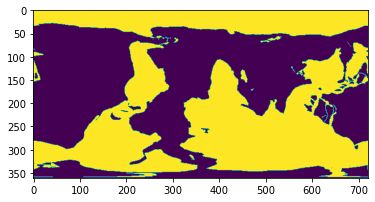

Working on Time 1.00Ma

Selected Time is in the stage 0.00Ma to 6.00Ma
./present_day_paleogeography.gmt
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_6Ma/m_fig64_11_2_PresentDay_Paleogeog_Matthews2016_6.00Ma.shp']


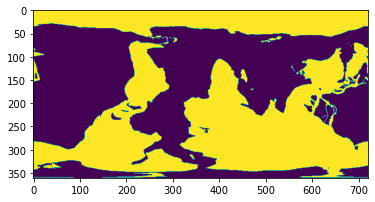

Working on Time 2.00Ma

Selected Time is in the stage 0.00Ma to 6.00Ma
./present_day_paleogeography.gmt
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_6Ma/m_fig64_11_2_PresentDay_Paleogeog_Matthews2016_6.00Ma.shp']


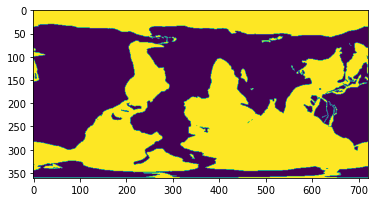

Working on Time 3.00Ma

Selected Time is in the stage 0.00Ma to 6.00Ma
./present_day_paleogeography.gmt
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_6Ma/m_fig64_11_2_PresentDay_Paleogeog_Matthews2016_6.00Ma.shp']


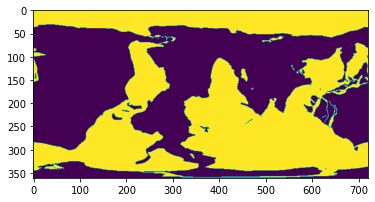

Working on Time 4.00Ma

Selected Time is in the stage 0.00Ma to 6.00Ma
./present_day_paleogeography.gmt
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_6Ma/m_fig64_11_2_PresentDay_Paleogeog_Matthews2016_6.00Ma.shp']


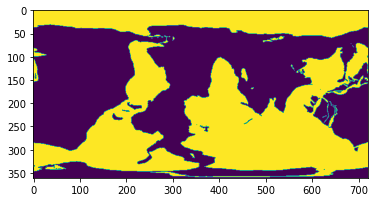

Working on Time 5.00Ma

Selected Time is in the stage 0.00Ma to 6.00Ma
./present_day_paleogeography.gmt
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_6Ma/m_fig64_11_2_PresentDay_Paleogeog_Matthews2016_6.00Ma.shp']


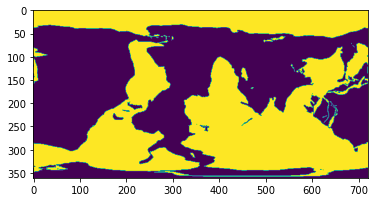

Working on Time 6.00Ma

Selected Time is in the stage 6.00Ma to 14.00Ma
Temporary fix for valid time
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_6Ma/m_fig64_11_2_PresentDay_Paleogeog_Matthews2016_6.00Ma.shp']


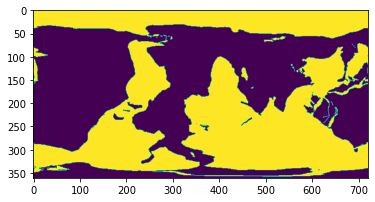

Working on Time 7.00Ma

Selected Time is in the stage 6.00Ma to 14.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_6Ma/m_fig64_11_2_PresentDay_Paleogeog_Matthews2016_6.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_14Ma/m_fig62_20_11_PresentDay_Paleogeog_Matthews2016_14.00Ma.shp']


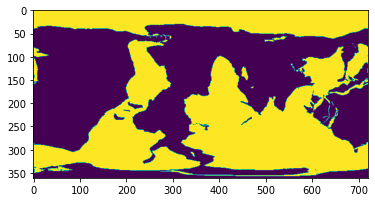

Working on Time 8.00Ma

Selected Time is in the stage 6.00Ma to 14.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_6Ma/m_fig64_11_2_PresentDay_Paleogeog_Matthews2016_6.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_14Ma/m_fig62_20_11_PresentDay_Paleogeog_Matthews2016_14.00Ma.shp']


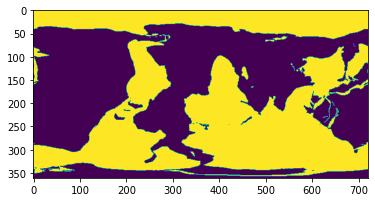

Working on Time 9.00Ma

Selected Time is in the stage 6.00Ma to 14.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_6Ma/m_fig64_11_2_PresentDay_Paleogeog_Matthews2016_6.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_14Ma/m_fig62_20_11_PresentDay_Paleogeog_Matthews2016_14.00Ma.shp']


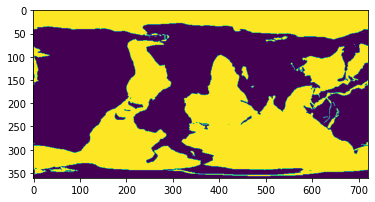

Working on Time 10.00Ma

Selected Time is in the stage 6.00Ma to 14.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_6Ma/m_fig64_11_2_PresentDay_Paleogeog_Matthews2016_6.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_14Ma/m_fig62_20_11_PresentDay_Paleogeog_Matthews2016_14.00Ma.shp']


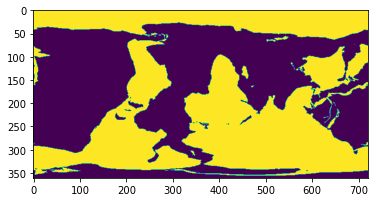

Working on Time 11.00Ma

Selected Time is in the stage 6.00Ma to 14.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_6Ma/m_fig64_11_2_PresentDay_Paleogeog_Matthews2016_6.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_14Ma/m_fig62_20_11_PresentDay_Paleogeog_Matthews2016_14.00Ma.shp']


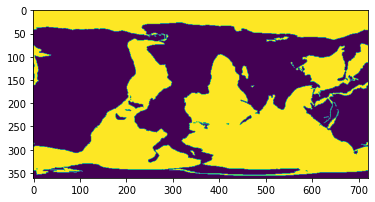

Working on Time 12.00Ma

Selected Time is in the stage 6.00Ma to 14.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_6Ma/m_fig64_11_2_PresentDay_Paleogeog_Matthews2016_6.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_14Ma/m_fig62_20_11_PresentDay_Paleogeog_Matthews2016_14.00Ma.shp']


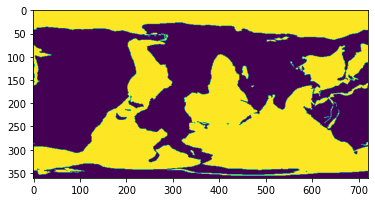

Working on Time 13.00Ma

Selected Time is in the stage 6.00Ma to 14.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_6Ma/m_fig64_11_2_PresentDay_Paleogeog_Matthews2016_6.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_14Ma/m_fig62_20_11_PresentDay_Paleogeog_Matthews2016_14.00Ma.shp']


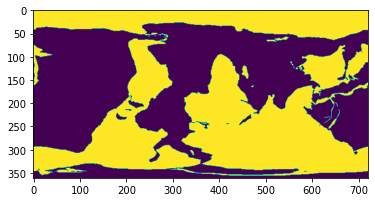

Working on Time 14.00Ma

Selected Time is in the stage 14.00Ma to 22.00Ma
Temporary fix for valid time
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_14Ma/m_fig62_20_11_PresentDay_Paleogeog_Matthews2016_14.00Ma.shp']


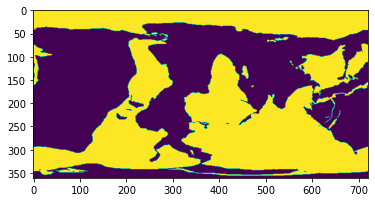

Working on Time 15.00Ma

Selected Time is in the stage 14.00Ma to 22.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_14Ma/m_fig62_20_11_PresentDay_Paleogeog_Matthews2016_14.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_22Ma/m_fig60_29_20_PresentDay_Paleogeog_Matthews2016_22.00Ma.shp']


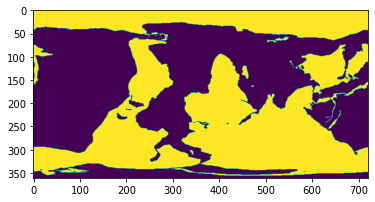

Working on Time 16.00Ma

Selected Time is in the stage 14.00Ma to 22.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_14Ma/m_fig62_20_11_PresentDay_Paleogeog_Matthews2016_14.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_22Ma/m_fig60_29_20_PresentDay_Paleogeog_Matthews2016_22.00Ma.shp']


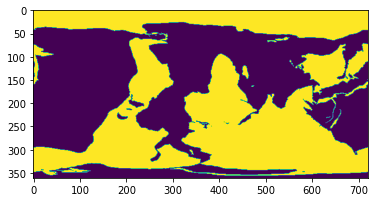

Working on Time 17.00Ma

Selected Time is in the stage 14.00Ma to 22.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_14Ma/m_fig62_20_11_PresentDay_Paleogeog_Matthews2016_14.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_22Ma/m_fig60_29_20_PresentDay_Paleogeog_Matthews2016_22.00Ma.shp']


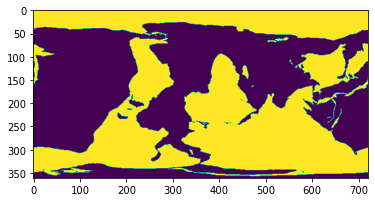

Working on Time 18.00Ma

Selected Time is in the stage 14.00Ma to 22.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_14Ma/m_fig62_20_11_PresentDay_Paleogeog_Matthews2016_14.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_22Ma/m_fig60_29_20_PresentDay_Paleogeog_Matthews2016_22.00Ma.shp']


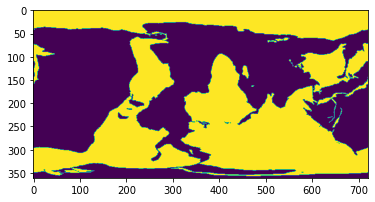

Working on Time 19.00Ma

Selected Time is in the stage 14.00Ma to 22.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_14Ma/m_fig62_20_11_PresentDay_Paleogeog_Matthews2016_14.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_22Ma/m_fig60_29_20_PresentDay_Paleogeog_Matthews2016_22.00Ma.shp']


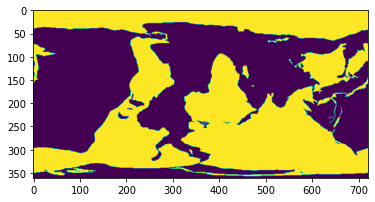

Working on Time 20.00Ma

Selected Time is in the stage 14.00Ma to 22.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_14Ma/m_fig62_20_11_PresentDay_Paleogeog_Matthews2016_14.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_22Ma/m_fig60_29_20_PresentDay_Paleogeog_Matthews2016_22.00Ma.shp']


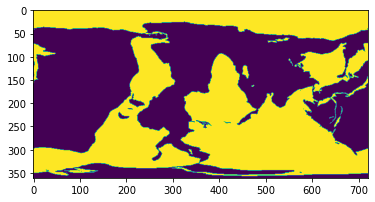

Working on Time 21.00Ma

Selected Time is in the stage 14.00Ma to 22.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_14Ma/m_fig62_20_11_PresentDay_Paleogeog_Matthews2016_14.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_22Ma/m_fig60_29_20_PresentDay_Paleogeog_Matthews2016_22.00Ma.shp']


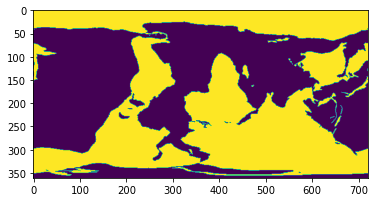

Working on Time 22.00Ma

Selected Time is in the stage 22.00Ma to 33.00Ma
Temporary fix for valid time
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_22Ma/m_fig60_29_20_PresentDay_Paleogeog_Matthews2016_22.00Ma.shp']


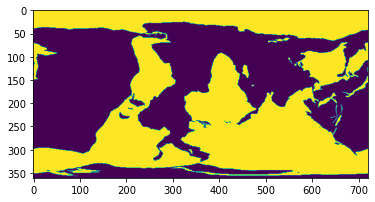

Working on Time 23.00Ma

Selected Time is in the stage 22.00Ma to 33.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_22Ma/m_fig60_29_20_PresentDay_Paleogeog_Matthews2016_22.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_33Ma/m_fig58_37_29_PresentDay_Paleogeog_Matthews2016_33.00Ma.shp']


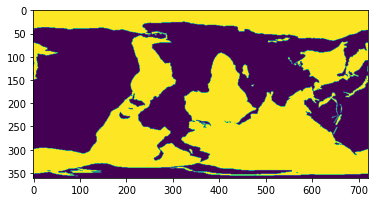

Working on Time 24.00Ma

Selected Time is in the stage 22.00Ma to 33.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_22Ma/m_fig60_29_20_PresentDay_Paleogeog_Matthews2016_22.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_33Ma/m_fig58_37_29_PresentDay_Paleogeog_Matthews2016_33.00Ma.shp']


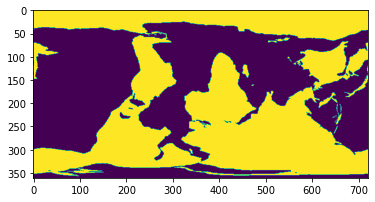

Working on Time 25.00Ma

Selected Time is in the stage 22.00Ma to 33.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_22Ma/m_fig60_29_20_PresentDay_Paleogeog_Matthews2016_22.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_33Ma/m_fig58_37_29_PresentDay_Paleogeog_Matthews2016_33.00Ma.shp']


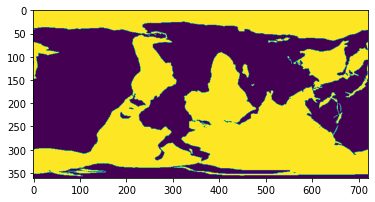

Working on Time 26.00Ma

Selected Time is in the stage 22.00Ma to 33.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_22Ma/m_fig60_29_20_PresentDay_Paleogeog_Matthews2016_22.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_33Ma/m_fig58_37_29_PresentDay_Paleogeog_Matthews2016_33.00Ma.shp']


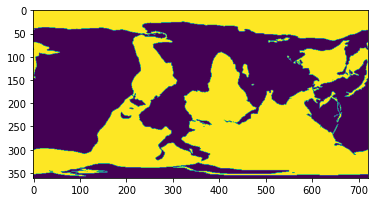

Working on Time 27.00Ma

Selected Time is in the stage 22.00Ma to 33.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_22Ma/m_fig60_29_20_PresentDay_Paleogeog_Matthews2016_22.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_33Ma/m_fig58_37_29_PresentDay_Paleogeog_Matthews2016_33.00Ma.shp']


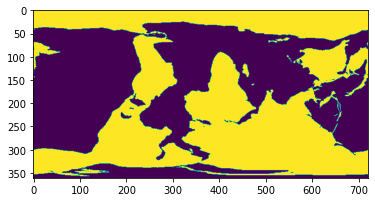

Working on Time 28.00Ma

Selected Time is in the stage 22.00Ma to 33.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_22Ma/m_fig60_29_20_PresentDay_Paleogeog_Matthews2016_22.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_33Ma/m_fig58_37_29_PresentDay_Paleogeog_Matthews2016_33.00Ma.shp']


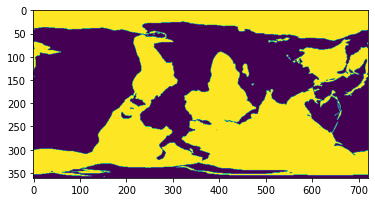

Working on Time 29.00Ma

Selected Time is in the stage 22.00Ma to 33.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_22Ma/m_fig60_29_20_PresentDay_Paleogeog_Matthews2016_22.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_33Ma/m_fig58_37_29_PresentDay_Paleogeog_Matthews2016_33.00Ma.shp']


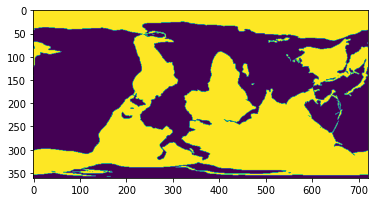

Working on Time 30.00Ma

Selected Time is in the stage 22.00Ma to 33.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_22Ma/m_fig60_29_20_PresentDay_Paleogeog_Matthews2016_22.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_33Ma/m_fig58_37_29_PresentDay_Paleogeog_Matthews2016_33.00Ma.shp']


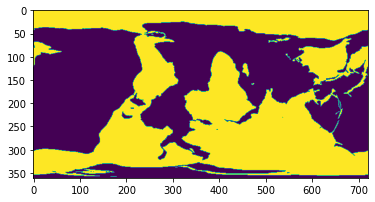

Working on Time 31.00Ma

Selected Time is in the stage 22.00Ma to 33.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_22Ma/m_fig60_29_20_PresentDay_Paleogeog_Matthews2016_22.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_33Ma/m_fig58_37_29_PresentDay_Paleogeog_Matthews2016_33.00Ma.shp']


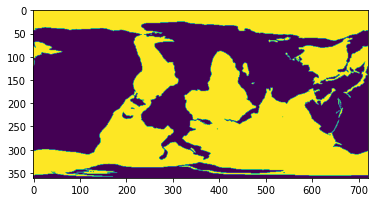

Working on Time 32.00Ma

Selected Time is in the stage 22.00Ma to 33.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_22Ma/m_fig60_29_20_PresentDay_Paleogeog_Matthews2016_22.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_33Ma/m_fig58_37_29_PresentDay_Paleogeog_Matthews2016_33.00Ma.shp']


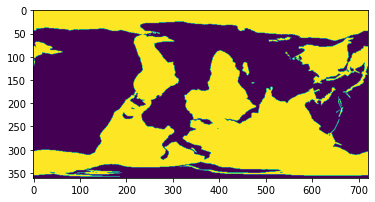

Working on Time 33.00Ma

Selected Time is in the stage 33.00Ma to 45.00Ma
Temporary fix for valid time
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_33Ma/m_fig58_37_29_PresentDay_Paleogeog_Matthews2016_33.00Ma.shp']


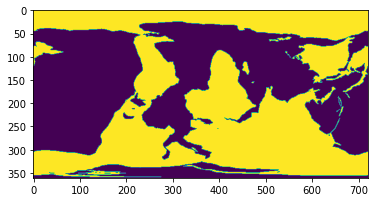

Working on Time 34.00Ma

Selected Time is in the stage 33.00Ma to 45.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_33Ma/m_fig58_37_29_PresentDay_Paleogeog_Matthews2016_33.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_45Ma/m_fig56_49_37_PresentDay_Paleogeog_Matthews2016_45.00Ma.shp']


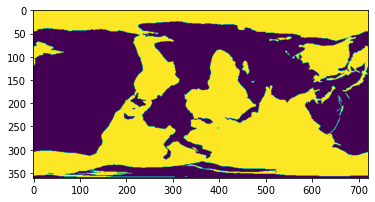

Working on Time 35.00Ma

Selected Time is in the stage 33.00Ma to 45.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_33Ma/m_fig58_37_29_PresentDay_Paleogeog_Matthews2016_33.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_45Ma/m_fig56_49_37_PresentDay_Paleogeog_Matthews2016_45.00Ma.shp']


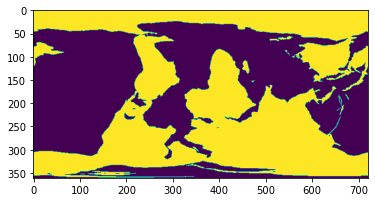

Working on Time 36.00Ma

Selected Time is in the stage 33.00Ma to 45.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_33Ma/m_fig58_37_29_PresentDay_Paleogeog_Matthews2016_33.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_45Ma/m_fig56_49_37_PresentDay_Paleogeog_Matthews2016_45.00Ma.shp']


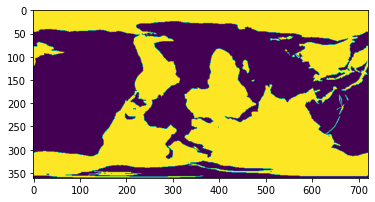

Working on Time 37.00Ma

Selected Time is in the stage 33.00Ma to 45.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_33Ma/m_fig58_37_29_PresentDay_Paleogeog_Matthews2016_33.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_45Ma/m_fig56_49_37_PresentDay_Paleogeog_Matthews2016_45.00Ma.shp']


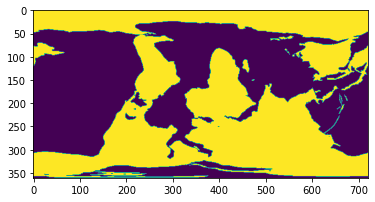

Working on Time 38.00Ma

Selected Time is in the stage 33.00Ma to 45.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_33Ma/m_fig58_37_29_PresentDay_Paleogeog_Matthews2016_33.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_45Ma/m_fig56_49_37_PresentDay_Paleogeog_Matthews2016_45.00Ma.shp']


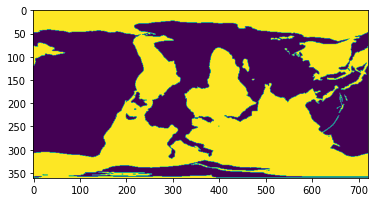

Working on Time 39.00Ma

Selected Time is in the stage 33.00Ma to 45.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_33Ma/m_fig58_37_29_PresentDay_Paleogeog_Matthews2016_33.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_45Ma/m_fig56_49_37_PresentDay_Paleogeog_Matthews2016_45.00Ma.shp']


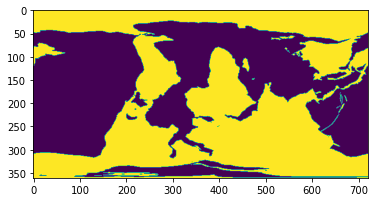

Working on Time 40.00Ma

Selected Time is in the stage 33.00Ma to 45.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_33Ma/m_fig58_37_29_PresentDay_Paleogeog_Matthews2016_33.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_45Ma/m_fig56_49_37_PresentDay_Paleogeog_Matthews2016_45.00Ma.shp']


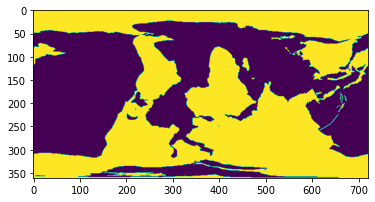

Working on Time 41.00Ma

Selected Time is in the stage 33.00Ma to 45.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_33Ma/m_fig58_37_29_PresentDay_Paleogeog_Matthews2016_33.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_45Ma/m_fig56_49_37_PresentDay_Paleogeog_Matthews2016_45.00Ma.shp']


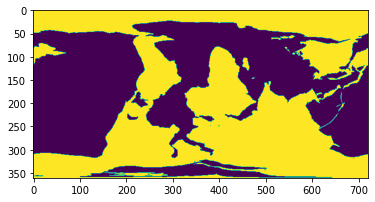

Working on Time 42.00Ma

Selected Time is in the stage 33.00Ma to 45.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_33Ma/m_fig58_37_29_PresentDay_Paleogeog_Matthews2016_33.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_45Ma/m_fig56_49_37_PresentDay_Paleogeog_Matthews2016_45.00Ma.shp']


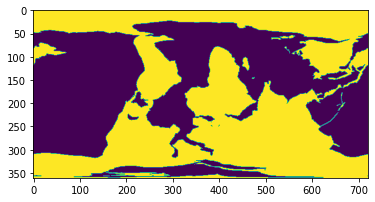

Working on Time 43.00Ma

Selected Time is in the stage 33.00Ma to 45.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_33Ma/m_fig58_37_29_PresentDay_Paleogeog_Matthews2016_33.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_45Ma/m_fig56_49_37_PresentDay_Paleogeog_Matthews2016_45.00Ma.shp']


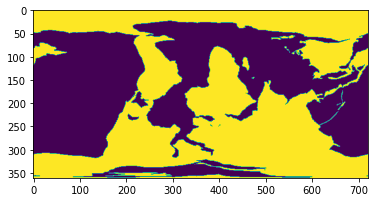

Working on Time 44.00Ma

Selected Time is in the stage 33.00Ma to 45.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_33Ma/m_fig58_37_29_PresentDay_Paleogeog_Matthews2016_33.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_45Ma/m_fig56_49_37_PresentDay_Paleogeog_Matthews2016_45.00Ma.shp']


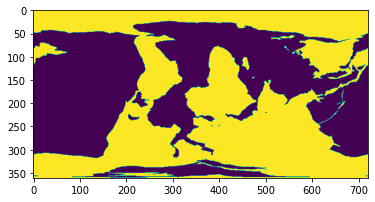

Working on Time 45.00Ma

Selected Time is in the stage 45.00Ma to 53.00Ma
Temporary fix for valid time
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_45Ma/m_fig56_49_37_PresentDay_Paleogeog_Matthews2016_45.00Ma.shp']


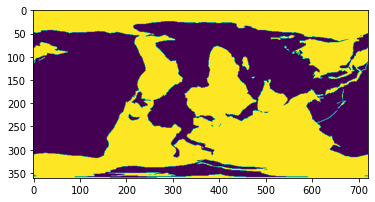

Working on Time 46.00Ma

Selected Time is in the stage 45.00Ma to 53.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_45Ma/m_fig56_49_37_PresentDay_Paleogeog_Matthews2016_45.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_53Ma/m_fig54_58_49_PresentDay_Paleogeog_Matthews2016_53.00Ma.shp']


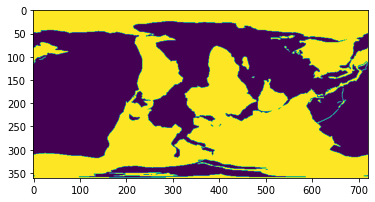

Working on Time 47.00Ma

Selected Time is in the stage 45.00Ma to 53.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_45Ma/m_fig56_49_37_PresentDay_Paleogeog_Matthews2016_45.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_53Ma/m_fig54_58_49_PresentDay_Paleogeog_Matthews2016_53.00Ma.shp']


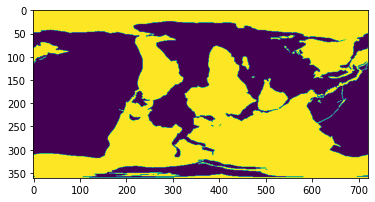

Working on Time 48.00Ma

Selected Time is in the stage 45.00Ma to 53.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_45Ma/m_fig56_49_37_PresentDay_Paleogeog_Matthews2016_45.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_53Ma/m_fig54_58_49_PresentDay_Paleogeog_Matthews2016_53.00Ma.shp']


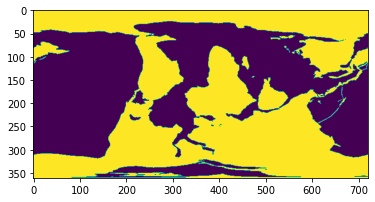

Working on Time 49.00Ma

Selected Time is in the stage 45.00Ma to 53.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_45Ma/m_fig56_49_37_PresentDay_Paleogeog_Matthews2016_45.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_53Ma/m_fig54_58_49_PresentDay_Paleogeog_Matthews2016_53.00Ma.shp']


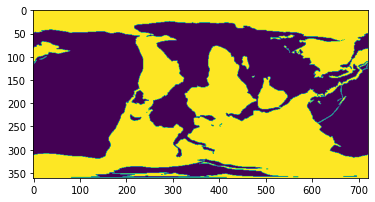

Working on Time 50.00Ma

Selected Time is in the stage 45.00Ma to 53.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_45Ma/m_fig56_49_37_PresentDay_Paleogeog_Matthews2016_45.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_53Ma/m_fig54_58_49_PresentDay_Paleogeog_Matthews2016_53.00Ma.shp']


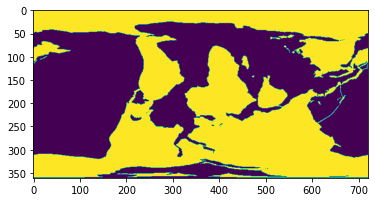

Working on Time 51.00Ma

Selected Time is in the stage 45.00Ma to 53.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_45Ma/m_fig56_49_37_PresentDay_Paleogeog_Matthews2016_45.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_53Ma/m_fig54_58_49_PresentDay_Paleogeog_Matthews2016_53.00Ma.shp']


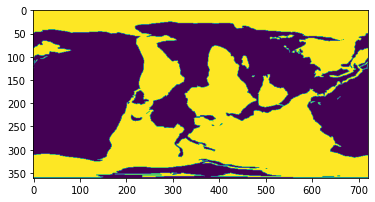

Working on Time 52.00Ma

Selected Time is in the stage 45.00Ma to 53.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_45Ma/m_fig56_49_37_PresentDay_Paleogeog_Matthews2016_45.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_53Ma/m_fig54_58_49_PresentDay_Paleogeog_Matthews2016_53.00Ma.shp']


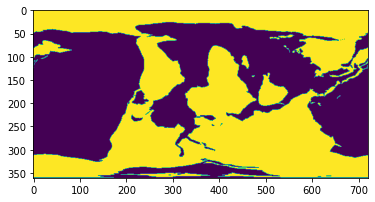

Working on Time 53.00Ma

Selected Time is in the stage 53.00Ma to 76.00Ma
Temporary fix for valid time
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_53Ma/m_fig54_58_49_PresentDay_Paleogeog_Matthews2016_53.00Ma.shp']


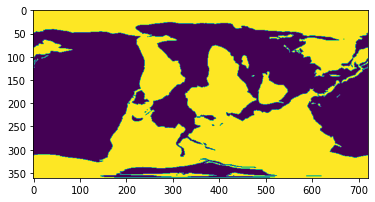

Working on Time 54.00Ma

Selected Time is in the stage 53.00Ma to 76.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_53Ma/m_fig54_58_49_PresentDay_Paleogeog_Matthews2016_53.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_76Ma/m_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']


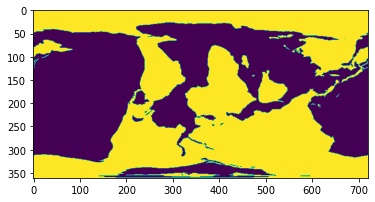

Working on Time 55.00Ma

Selected Time is in the stage 53.00Ma to 76.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_53Ma/m_fig54_58_49_PresentDay_Paleogeog_Matthews2016_53.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_76Ma/m_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']


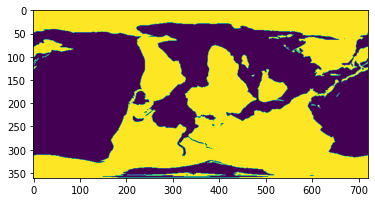

Working on Time 56.00Ma

Selected Time is in the stage 53.00Ma to 76.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_53Ma/m_fig54_58_49_PresentDay_Paleogeog_Matthews2016_53.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_76Ma/m_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']


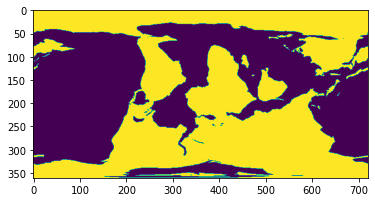

Working on Time 57.00Ma

Selected Time is in the stage 53.00Ma to 76.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_53Ma/m_fig54_58_49_PresentDay_Paleogeog_Matthews2016_53.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_76Ma/m_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']


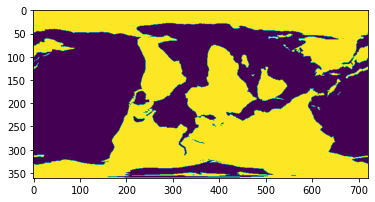

Working on Time 58.00Ma

Selected Time is in the stage 53.00Ma to 76.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_53Ma/m_fig54_58_49_PresentDay_Paleogeog_Matthews2016_53.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_76Ma/m_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']


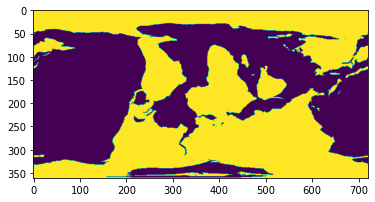

Working on Time 59.00Ma

Selected Time is in the stage 53.00Ma to 76.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_53Ma/m_fig54_58_49_PresentDay_Paleogeog_Matthews2016_53.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_76Ma/m_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']


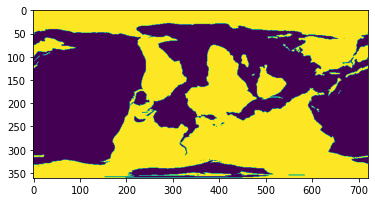

Working on Time 60.00Ma

Selected Time is in the stage 53.00Ma to 76.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_53Ma/m_fig54_58_49_PresentDay_Paleogeog_Matthews2016_53.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_76Ma/m_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']


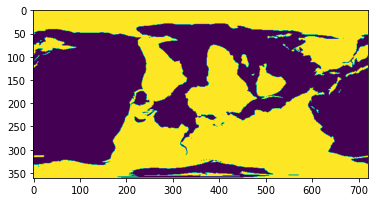

Working on Time 61.00Ma

Selected Time is in the stage 53.00Ma to 76.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_53Ma/m_fig54_58_49_PresentDay_Paleogeog_Matthews2016_53.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_76Ma/m_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']


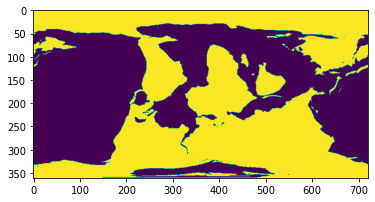

Working on Time 62.00Ma

Selected Time is in the stage 53.00Ma to 76.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_53Ma/m_fig54_58_49_PresentDay_Paleogeog_Matthews2016_53.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_76Ma/m_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']


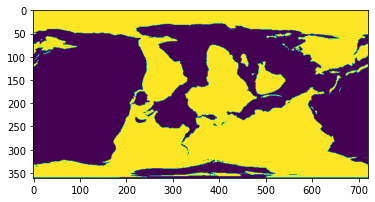

Working on Time 63.00Ma

Selected Time is in the stage 53.00Ma to 76.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_53Ma/m_fig54_58_49_PresentDay_Paleogeog_Matthews2016_53.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_76Ma/m_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']


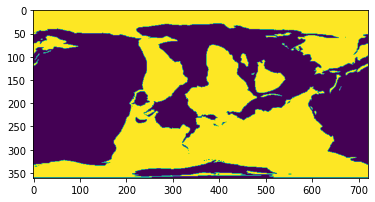

Working on Time 64.00Ma

Selected Time is in the stage 53.00Ma to 76.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_53Ma/m_fig54_58_49_PresentDay_Paleogeog_Matthews2016_53.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_76Ma/m_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']


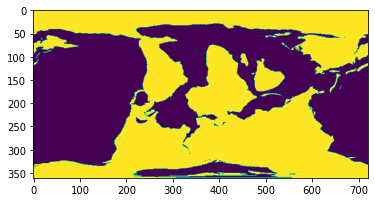

Working on Time 65.00Ma

Selected Time is in the stage 53.00Ma to 76.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_53Ma/m_fig54_58_49_PresentDay_Paleogeog_Matthews2016_53.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_76Ma/m_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']


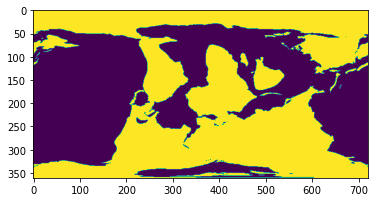

Working on Time 66.00Ma

Selected Time is in the stage 53.00Ma to 76.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_53Ma/m_fig54_58_49_PresentDay_Paleogeog_Matthews2016_53.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_76Ma/m_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']


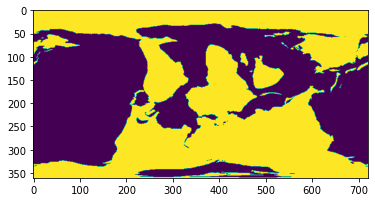

Working on Time 67.00Ma

Selected Time is in the stage 53.00Ma to 76.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_53Ma/m_fig54_58_49_PresentDay_Paleogeog_Matthews2016_53.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_76Ma/m_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']


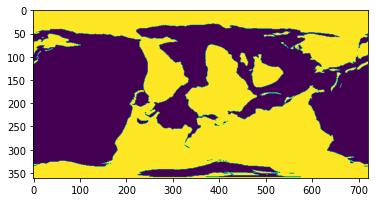

Working on Time 68.00Ma

Selected Time is in the stage 53.00Ma to 76.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_53Ma/m_fig54_58_49_PresentDay_Paleogeog_Matthews2016_53.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_76Ma/m_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']


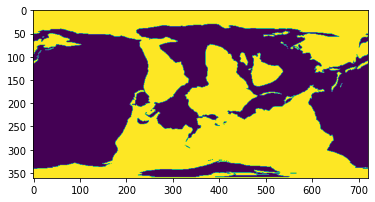

Working on Time 69.00Ma

Selected Time is in the stage 53.00Ma to 76.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_53Ma/m_fig54_58_49_PresentDay_Paleogeog_Matthews2016_53.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_76Ma/m_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']


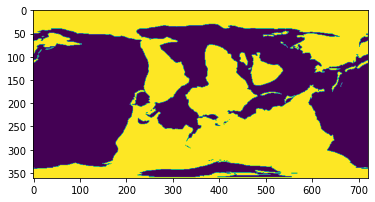

Working on Time 70.00Ma

Selected Time is in the stage 53.00Ma to 76.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_53Ma/m_fig54_58_49_PresentDay_Paleogeog_Matthews2016_53.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_76Ma/m_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']


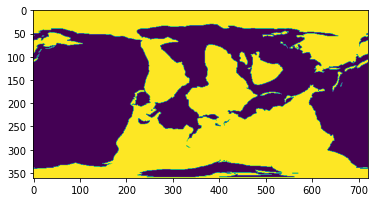

Working on Time 71.00Ma

Selected Time is in the stage 53.00Ma to 76.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_53Ma/m_fig54_58_49_PresentDay_Paleogeog_Matthews2016_53.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_76Ma/m_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']


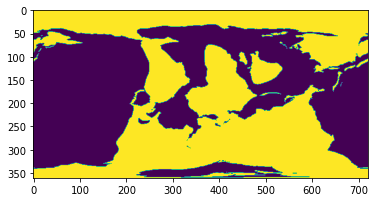

Working on Time 72.00Ma

Selected Time is in the stage 53.00Ma to 76.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_53Ma/m_fig54_58_49_PresentDay_Paleogeog_Matthews2016_53.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_76Ma/m_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']


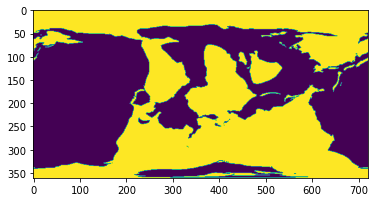

Working on Time 73.00Ma

Selected Time is in the stage 53.00Ma to 76.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_53Ma/m_fig54_58_49_PresentDay_Paleogeog_Matthews2016_53.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_76Ma/m_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']


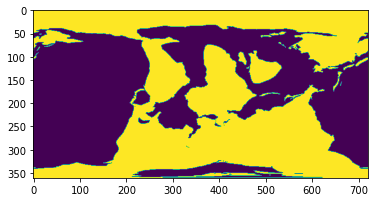

Working on Time 74.00Ma

Selected Time is in the stage 53.00Ma to 76.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_53Ma/m_fig54_58_49_PresentDay_Paleogeog_Matthews2016_53.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_76Ma/m_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']


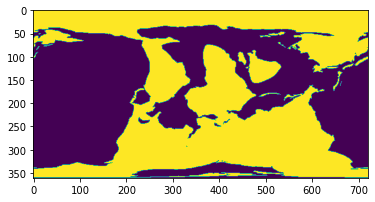

Working on Time 75.00Ma

Selected Time is in the stage 53.00Ma to 76.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_53Ma/m_fig54_58_49_PresentDay_Paleogeog_Matthews2016_53.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_76Ma/m_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']


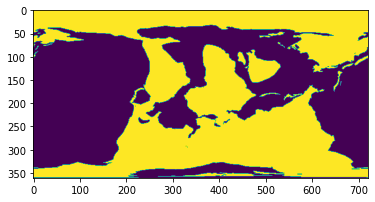

Working on Time 76.00Ma

Selected Time is in the stage 76.00Ma to 90.00Ma
Temporary fix for valid time
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_76Ma/m_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']


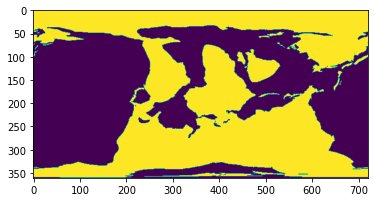

Working on Time 77.00Ma

Selected Time is in the stage 76.00Ma to 90.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_76Ma/m_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_90Ma/m_fig50_94_81_PresentDay_Paleogeog_Matthews2016_90.00Ma.shp']


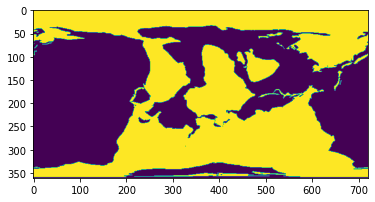

Working on Time 78.00Ma

Selected Time is in the stage 76.00Ma to 90.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_76Ma/m_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_90Ma/m_fig50_94_81_PresentDay_Paleogeog_Matthews2016_90.00Ma.shp']


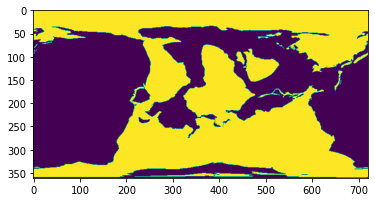

Working on Time 79.00Ma

Selected Time is in the stage 76.00Ma to 90.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_76Ma/m_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_90Ma/m_fig50_94_81_PresentDay_Paleogeog_Matthews2016_90.00Ma.shp']


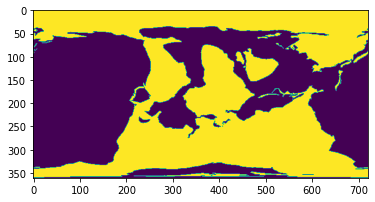

Working on Time 80.00Ma

Selected Time is in the stage 76.00Ma to 90.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_76Ma/m_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_90Ma/m_fig50_94_81_PresentDay_Paleogeog_Matthews2016_90.00Ma.shp']


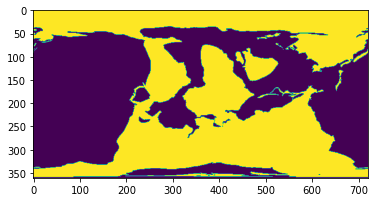

Working on Time 81.00Ma

Selected Time is in the stage 76.00Ma to 90.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_76Ma/m_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_90Ma/m_fig50_94_81_PresentDay_Paleogeog_Matthews2016_90.00Ma.shp']


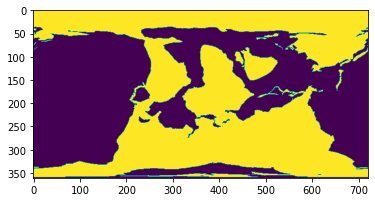

Working on Time 82.00Ma

Selected Time is in the stage 76.00Ma to 90.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_76Ma/m_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_90Ma/m_fig50_94_81_PresentDay_Paleogeog_Matthews2016_90.00Ma.shp']


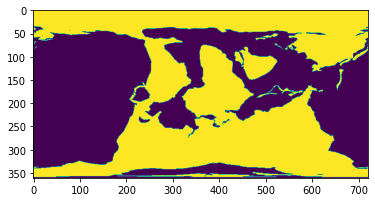

Working on Time 83.00Ma

Selected Time is in the stage 76.00Ma to 90.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_76Ma/m_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_90Ma/m_fig50_94_81_PresentDay_Paleogeog_Matthews2016_90.00Ma.shp']


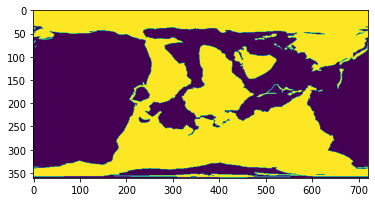

Working on Time 84.00Ma

Selected Time is in the stage 76.00Ma to 90.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_76Ma/m_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_90Ma/m_fig50_94_81_PresentDay_Paleogeog_Matthews2016_90.00Ma.shp']


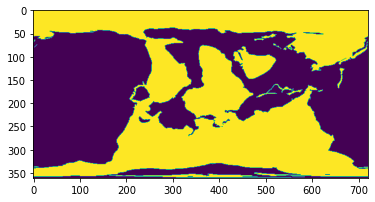

Working on Time 85.00Ma

Selected Time is in the stage 76.00Ma to 90.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_76Ma/m_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_90Ma/m_fig50_94_81_PresentDay_Paleogeog_Matthews2016_90.00Ma.shp']


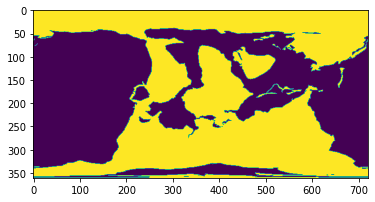

Working on Time 86.00Ma

Selected Time is in the stage 76.00Ma to 90.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_76Ma/m_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_90Ma/m_fig50_94_81_PresentDay_Paleogeog_Matthews2016_90.00Ma.shp']


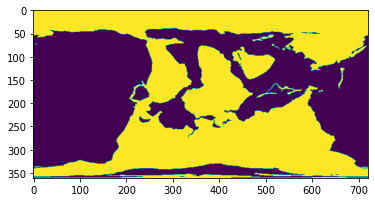

Working on Time 87.00Ma

Selected Time is in the stage 76.00Ma to 90.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_76Ma/m_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_90Ma/m_fig50_94_81_PresentDay_Paleogeog_Matthews2016_90.00Ma.shp']


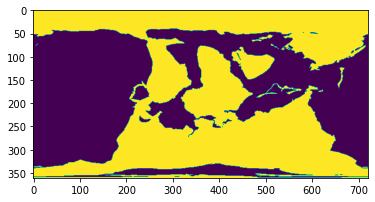

Working on Time 88.00Ma

Selected Time is in the stage 76.00Ma to 90.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_76Ma/m_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_90Ma/m_fig50_94_81_PresentDay_Paleogeog_Matthews2016_90.00Ma.shp']


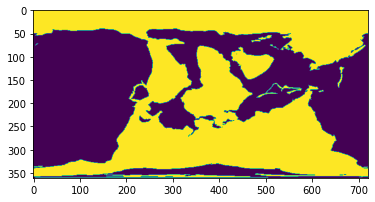

Working on Time 89.00Ma

Selected Time is in the stage 76.00Ma to 90.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_76Ma/m_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_90Ma/m_fig50_94_81_PresentDay_Paleogeog_Matthews2016_90.00Ma.shp']


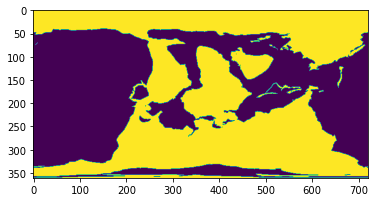

Working on Time 90.00Ma

Selected Time is in the stage 90.00Ma to 105.00Ma
Temporary fix for valid time
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_90Ma/m_fig50_94_81_PresentDay_Paleogeog_Matthews2016_90.00Ma.shp']


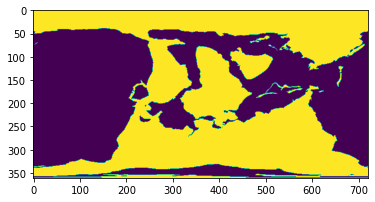

Working on Time 91.00Ma

Selected Time is in the stage 90.00Ma to 105.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_90Ma/m_fig50_94_81_PresentDay_Paleogeog_Matthews2016_90.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_105Ma/m_fig48_117_94_PresentDay_Paleogeog_Matthews2016_105.00Ma.shp']


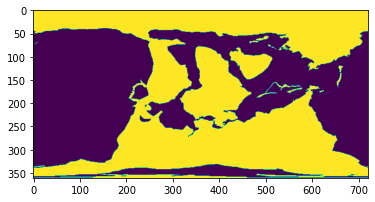

Working on Time 92.00Ma

Selected Time is in the stage 90.00Ma to 105.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_90Ma/m_fig50_94_81_PresentDay_Paleogeog_Matthews2016_90.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_105Ma/m_fig48_117_94_PresentDay_Paleogeog_Matthews2016_105.00Ma.shp']


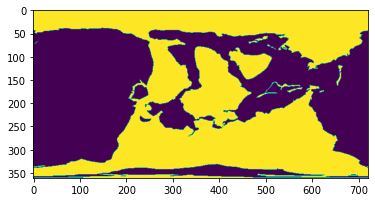

Working on Time 93.00Ma

Selected Time is in the stage 90.00Ma to 105.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_90Ma/m_fig50_94_81_PresentDay_Paleogeog_Matthews2016_90.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_105Ma/m_fig48_117_94_PresentDay_Paleogeog_Matthews2016_105.00Ma.shp']


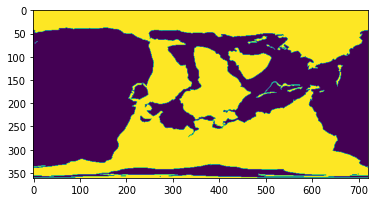

Working on Time 94.00Ma

Selected Time is in the stage 90.00Ma to 105.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_90Ma/m_fig50_94_81_PresentDay_Paleogeog_Matthews2016_90.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_105Ma/m_fig48_117_94_PresentDay_Paleogeog_Matthews2016_105.00Ma.shp']


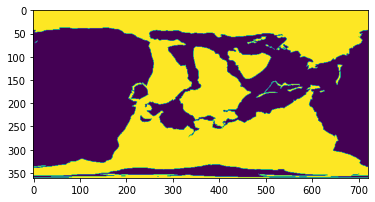

Working on Time 95.00Ma

Selected Time is in the stage 90.00Ma to 105.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_90Ma/m_fig50_94_81_PresentDay_Paleogeog_Matthews2016_90.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_105Ma/m_fig48_117_94_PresentDay_Paleogeog_Matthews2016_105.00Ma.shp']


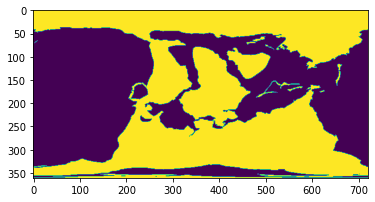

Working on Time 96.00Ma

Selected Time is in the stage 90.00Ma to 105.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_90Ma/m_fig50_94_81_PresentDay_Paleogeog_Matthews2016_90.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_105Ma/m_fig48_117_94_PresentDay_Paleogeog_Matthews2016_105.00Ma.shp']


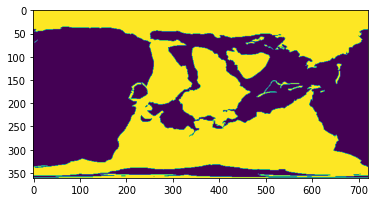

Working on Time 97.00Ma

Selected Time is in the stage 90.00Ma to 105.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_90Ma/m_fig50_94_81_PresentDay_Paleogeog_Matthews2016_90.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_105Ma/m_fig48_117_94_PresentDay_Paleogeog_Matthews2016_105.00Ma.shp']


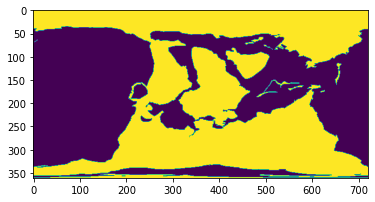

Working on Time 98.00Ma

Selected Time is in the stage 90.00Ma to 105.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_90Ma/m_fig50_94_81_PresentDay_Paleogeog_Matthews2016_90.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_105Ma/m_fig48_117_94_PresentDay_Paleogeog_Matthews2016_105.00Ma.shp']


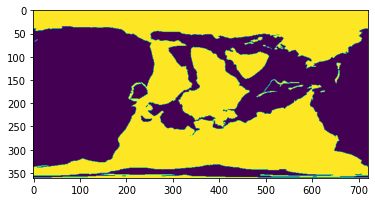

Working on Time 99.00Ma

Selected Time is in the stage 90.00Ma to 105.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_90Ma/m_fig50_94_81_PresentDay_Paleogeog_Matthews2016_90.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_105Ma/m_fig48_117_94_PresentDay_Paleogeog_Matthews2016_105.00Ma.shp']


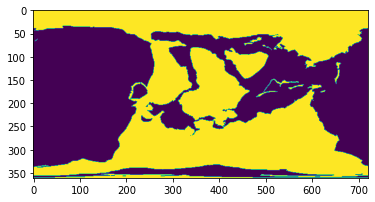

Working on Time 100.00Ma

Selected Time is in the stage 90.00Ma to 105.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_90Ma/m_fig50_94_81_PresentDay_Paleogeog_Matthews2016_90.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_105Ma/m_fig48_117_94_PresentDay_Paleogeog_Matthews2016_105.00Ma.shp']


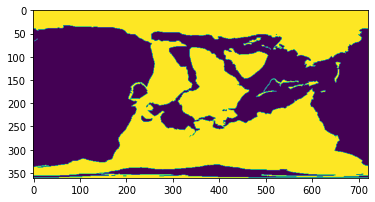

Working on Time 101.00Ma

Selected Time is in the stage 90.00Ma to 105.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_90Ma/m_fig50_94_81_PresentDay_Paleogeog_Matthews2016_90.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_105Ma/m_fig48_117_94_PresentDay_Paleogeog_Matthews2016_105.00Ma.shp']


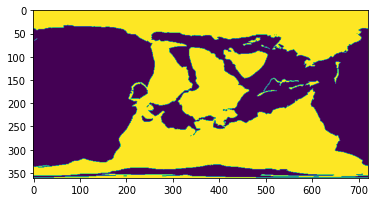

Working on Time 102.00Ma

Selected Time is in the stage 90.00Ma to 105.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_90Ma/m_fig50_94_81_PresentDay_Paleogeog_Matthews2016_90.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_105Ma/m_fig48_117_94_PresentDay_Paleogeog_Matthews2016_105.00Ma.shp']


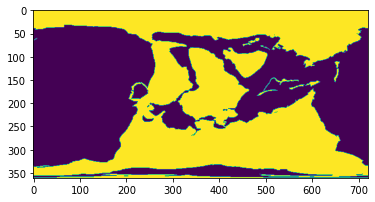

Working on Time 103.00Ma

Selected Time is in the stage 90.00Ma to 105.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_90Ma/m_fig50_94_81_PresentDay_Paleogeog_Matthews2016_90.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_105Ma/m_fig48_117_94_PresentDay_Paleogeog_Matthews2016_105.00Ma.shp']


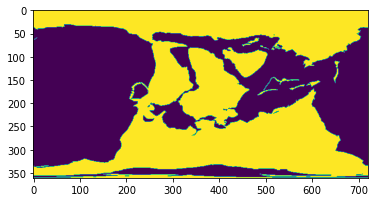

Working on Time 104.00Ma

Selected Time is in the stage 90.00Ma to 105.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_90Ma/m_fig50_94_81_PresentDay_Paleogeog_Matthews2016_90.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_105Ma/m_fig48_117_94_PresentDay_Paleogeog_Matthews2016_105.00Ma.shp']


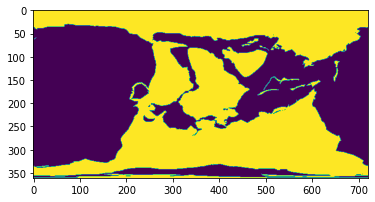

Working on Time 105.00Ma

Selected Time is in the stage 105.00Ma to 126.00Ma
Temporary fix for valid time
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_105Ma/m_fig48_117_94_PresentDay_Paleogeog_Matthews2016_105.00Ma.shp']


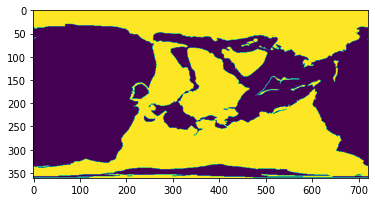

Working on Time 106.00Ma

Selected Time is in the stage 105.00Ma to 126.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_105Ma/m_fig48_117_94_PresentDay_Paleogeog_Matthews2016_105.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_126Ma/m_fig46_135_117_PresentDay_Paleogeog_Matthews2016_126.00Ma.shp']


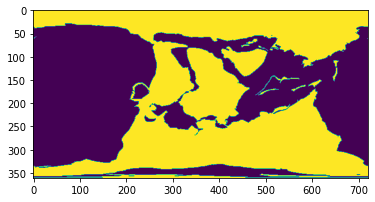

Working on Time 107.00Ma

Selected Time is in the stage 105.00Ma to 126.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_105Ma/m_fig48_117_94_PresentDay_Paleogeog_Matthews2016_105.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_126Ma/m_fig46_135_117_PresentDay_Paleogeog_Matthews2016_126.00Ma.shp']


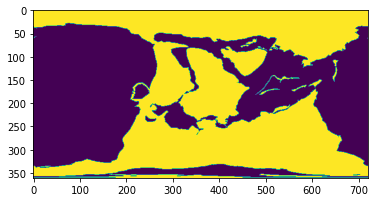

Working on Time 108.00Ma

Selected Time is in the stage 105.00Ma to 126.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_105Ma/m_fig48_117_94_PresentDay_Paleogeog_Matthews2016_105.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_126Ma/m_fig46_135_117_PresentDay_Paleogeog_Matthews2016_126.00Ma.shp']


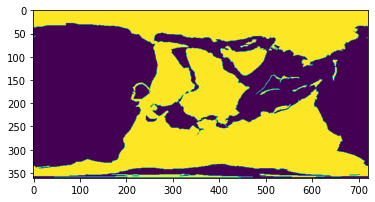

Working on Time 109.00Ma

Selected Time is in the stage 105.00Ma to 126.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_105Ma/m_fig48_117_94_PresentDay_Paleogeog_Matthews2016_105.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_126Ma/m_fig46_135_117_PresentDay_Paleogeog_Matthews2016_126.00Ma.shp']


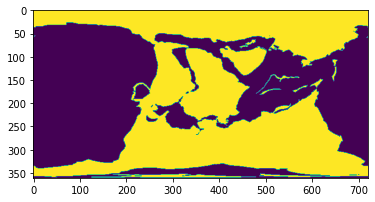

Working on Time 110.00Ma

Selected Time is in the stage 105.00Ma to 126.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_105Ma/m_fig48_117_94_PresentDay_Paleogeog_Matthews2016_105.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_126Ma/m_fig46_135_117_PresentDay_Paleogeog_Matthews2016_126.00Ma.shp']


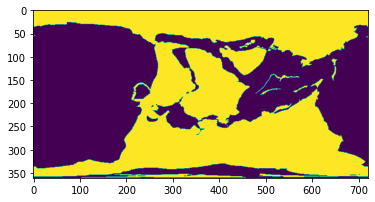

Working on Time 111.00Ma

Selected Time is in the stage 105.00Ma to 126.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_105Ma/m_fig48_117_94_PresentDay_Paleogeog_Matthews2016_105.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_126Ma/m_fig46_135_117_PresentDay_Paleogeog_Matthews2016_126.00Ma.shp']


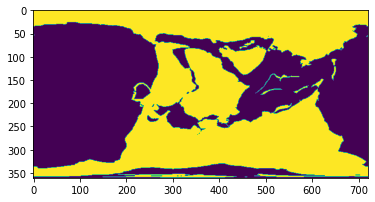

Working on Time 112.00Ma

Selected Time is in the stage 105.00Ma to 126.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_105Ma/m_fig48_117_94_PresentDay_Paleogeog_Matthews2016_105.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_126Ma/m_fig46_135_117_PresentDay_Paleogeog_Matthews2016_126.00Ma.shp']


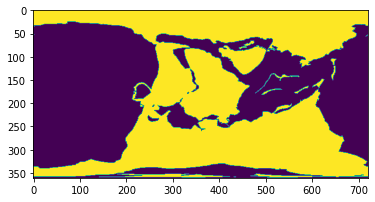

Working on Time 113.00Ma

Selected Time is in the stage 105.00Ma to 126.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_105Ma/m_fig48_117_94_PresentDay_Paleogeog_Matthews2016_105.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_126Ma/m_fig46_135_117_PresentDay_Paleogeog_Matthews2016_126.00Ma.shp']


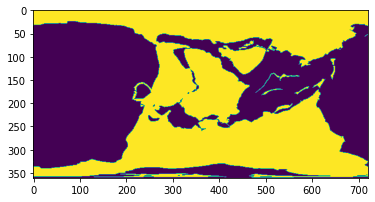

Working on Time 114.00Ma

Selected Time is in the stage 105.00Ma to 126.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_105Ma/m_fig48_117_94_PresentDay_Paleogeog_Matthews2016_105.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_126Ma/m_fig46_135_117_PresentDay_Paleogeog_Matthews2016_126.00Ma.shp']


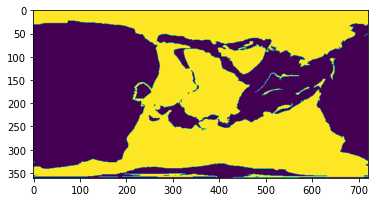

Working on Time 115.00Ma

Selected Time is in the stage 105.00Ma to 126.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_105Ma/m_fig48_117_94_PresentDay_Paleogeog_Matthews2016_105.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_126Ma/m_fig46_135_117_PresentDay_Paleogeog_Matthews2016_126.00Ma.shp']


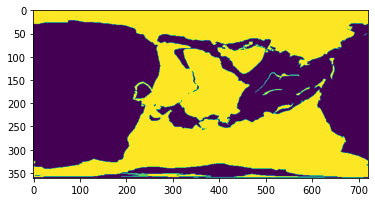

Working on Time 116.00Ma

Selected Time is in the stage 105.00Ma to 126.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_105Ma/m_fig48_117_94_PresentDay_Paleogeog_Matthews2016_105.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_126Ma/m_fig46_135_117_PresentDay_Paleogeog_Matthews2016_126.00Ma.shp']


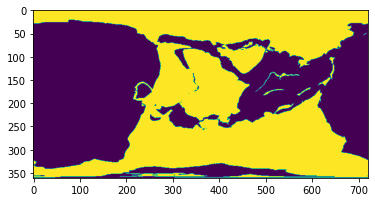

Working on Time 117.00Ma

Selected Time is in the stage 105.00Ma to 126.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_105Ma/m_fig48_117_94_PresentDay_Paleogeog_Matthews2016_105.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_126Ma/m_fig46_135_117_PresentDay_Paleogeog_Matthews2016_126.00Ma.shp']


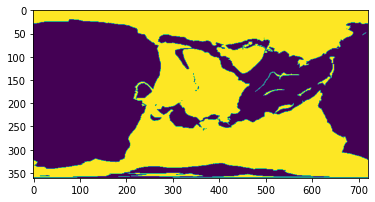

Working on Time 118.00Ma

Selected Time is in the stage 105.00Ma to 126.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_105Ma/m_fig48_117_94_PresentDay_Paleogeog_Matthews2016_105.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_126Ma/m_fig46_135_117_PresentDay_Paleogeog_Matthews2016_126.00Ma.shp']


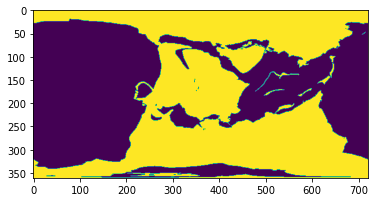

Working on Time 119.00Ma

Selected Time is in the stage 105.00Ma to 126.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_105Ma/m_fig48_117_94_PresentDay_Paleogeog_Matthews2016_105.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_126Ma/m_fig46_135_117_PresentDay_Paleogeog_Matthews2016_126.00Ma.shp']


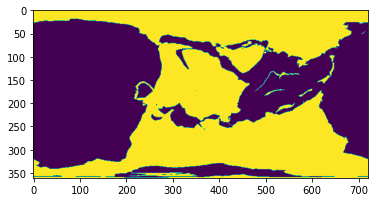

Working on Time 120.00Ma

Selected Time is in the stage 105.00Ma to 126.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_105Ma/m_fig48_117_94_PresentDay_Paleogeog_Matthews2016_105.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_126Ma/m_fig46_135_117_PresentDay_Paleogeog_Matthews2016_126.00Ma.shp']


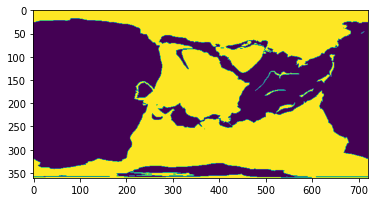

Working on Time 121.00Ma

Selected Time is in the stage 105.00Ma to 126.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_105Ma/m_fig48_117_94_PresentDay_Paleogeog_Matthews2016_105.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_126Ma/m_fig46_135_117_PresentDay_Paleogeog_Matthews2016_126.00Ma.shp']


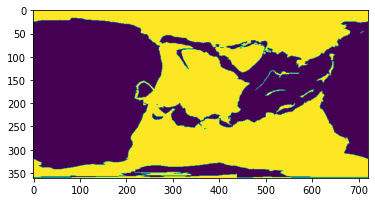

Working on Time 122.00Ma

Selected Time is in the stage 105.00Ma to 126.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_105Ma/m_fig48_117_94_PresentDay_Paleogeog_Matthews2016_105.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_126Ma/m_fig46_135_117_PresentDay_Paleogeog_Matthews2016_126.00Ma.shp']


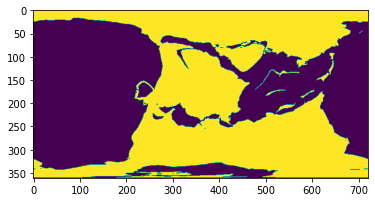

Working on Time 123.00Ma

Selected Time is in the stage 105.00Ma to 126.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_105Ma/m_fig48_117_94_PresentDay_Paleogeog_Matthews2016_105.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_126Ma/m_fig46_135_117_PresentDay_Paleogeog_Matthews2016_126.00Ma.shp']


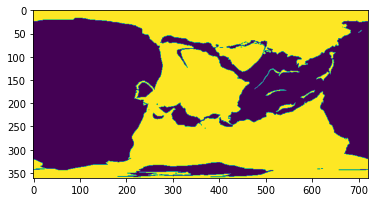

Working on Time 124.00Ma

Selected Time is in the stage 105.00Ma to 126.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_105Ma/m_fig48_117_94_PresentDay_Paleogeog_Matthews2016_105.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_126Ma/m_fig46_135_117_PresentDay_Paleogeog_Matthews2016_126.00Ma.shp']


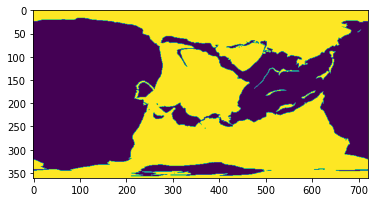

Working on Time 125.00Ma

Selected Time is in the stage 105.00Ma to 126.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_105Ma/m_fig48_117_94_PresentDay_Paleogeog_Matthews2016_105.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_126Ma/m_fig46_135_117_PresentDay_Paleogeog_Matthews2016_126.00Ma.shp']


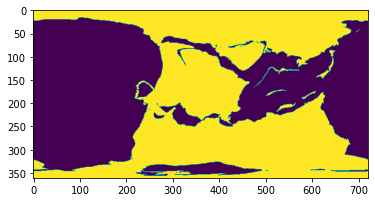

Working on Time 126.00Ma

Selected Time is in the stage 126.00Ma to 140.00Ma
Temporary fix for valid time
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_126Ma/m_fig46_135_117_PresentDay_Paleogeog_Matthews2016_126.00Ma.shp']


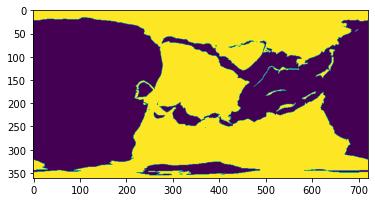

Working on Time 127.00Ma

Selected Time is in the stage 126.00Ma to 140.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_126Ma/m_fig46_135_117_PresentDay_Paleogeog_Matthews2016_126.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_140Ma/m_fig44_146_135_PresentDay_Paleogeog_Matthews2016_140.00Ma.shp']


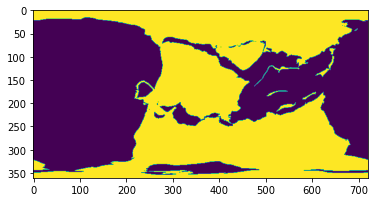

Working on Time 128.00Ma

Selected Time is in the stage 126.00Ma to 140.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_126Ma/m_fig46_135_117_PresentDay_Paleogeog_Matthews2016_126.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_140Ma/m_fig44_146_135_PresentDay_Paleogeog_Matthews2016_140.00Ma.shp']


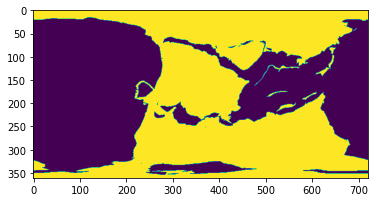

Working on Time 129.00Ma

Selected Time is in the stage 126.00Ma to 140.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_126Ma/m_fig46_135_117_PresentDay_Paleogeog_Matthews2016_126.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_140Ma/m_fig44_146_135_PresentDay_Paleogeog_Matthews2016_140.00Ma.shp']


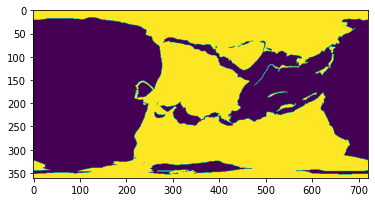

Working on Time 130.00Ma

Selected Time is in the stage 126.00Ma to 140.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_126Ma/m_fig46_135_117_PresentDay_Paleogeog_Matthews2016_126.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_140Ma/m_fig44_146_135_PresentDay_Paleogeog_Matthews2016_140.00Ma.shp']


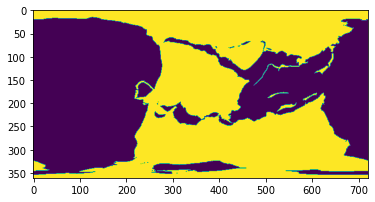

Working on Time 131.00Ma

Selected Time is in the stage 126.00Ma to 140.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_126Ma/m_fig46_135_117_PresentDay_Paleogeog_Matthews2016_126.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_140Ma/m_fig44_146_135_PresentDay_Paleogeog_Matthews2016_140.00Ma.shp']


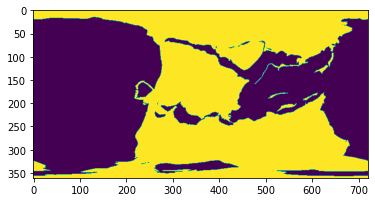

Working on Time 132.00Ma

Selected Time is in the stage 126.00Ma to 140.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_126Ma/m_fig46_135_117_PresentDay_Paleogeog_Matthews2016_126.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_140Ma/m_fig44_146_135_PresentDay_Paleogeog_Matthews2016_140.00Ma.shp']


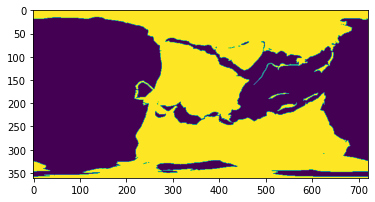

Working on Time 133.00Ma

Selected Time is in the stage 126.00Ma to 140.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_126Ma/m_fig46_135_117_PresentDay_Paleogeog_Matthews2016_126.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_140Ma/m_fig44_146_135_PresentDay_Paleogeog_Matthews2016_140.00Ma.shp']


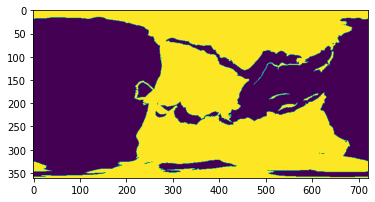

Working on Time 134.00Ma

Selected Time is in the stage 126.00Ma to 140.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_126Ma/m_fig46_135_117_PresentDay_Paleogeog_Matthews2016_126.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_140Ma/m_fig44_146_135_PresentDay_Paleogeog_Matthews2016_140.00Ma.shp']


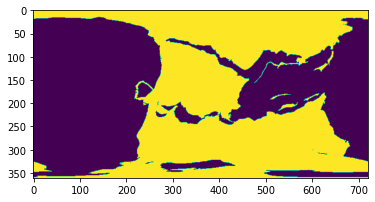

Working on Time 135.00Ma

Selected Time is in the stage 126.00Ma to 140.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_126Ma/m_fig46_135_117_PresentDay_Paleogeog_Matthews2016_126.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_140Ma/m_fig44_146_135_PresentDay_Paleogeog_Matthews2016_140.00Ma.shp']


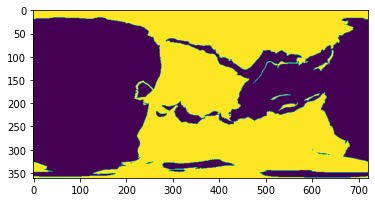

Working on Time 136.00Ma

Selected Time is in the stage 126.00Ma to 140.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_126Ma/m_fig46_135_117_PresentDay_Paleogeog_Matthews2016_126.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_140Ma/m_fig44_146_135_PresentDay_Paleogeog_Matthews2016_140.00Ma.shp']


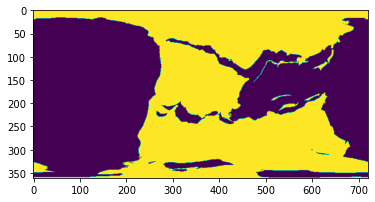

Working on Time 137.00Ma

Selected Time is in the stage 126.00Ma to 140.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_126Ma/m_fig46_135_117_PresentDay_Paleogeog_Matthews2016_126.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_140Ma/m_fig44_146_135_PresentDay_Paleogeog_Matthews2016_140.00Ma.shp']


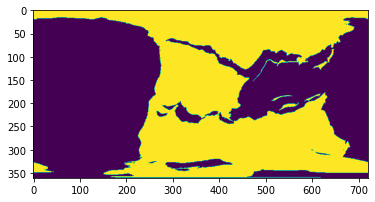

Working on Time 138.00Ma

Selected Time is in the stage 126.00Ma to 140.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_126Ma/m_fig46_135_117_PresentDay_Paleogeog_Matthews2016_126.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_140Ma/m_fig44_146_135_PresentDay_Paleogeog_Matthews2016_140.00Ma.shp']


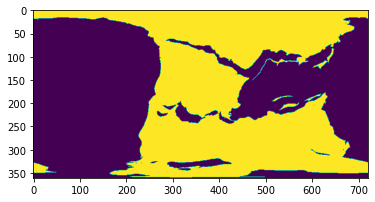

Working on Time 139.00Ma

Selected Time is in the stage 126.00Ma to 140.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_126Ma/m_fig46_135_117_PresentDay_Paleogeog_Matthews2016_126.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_140Ma/m_fig44_146_135_PresentDay_Paleogeog_Matthews2016_140.00Ma.shp']


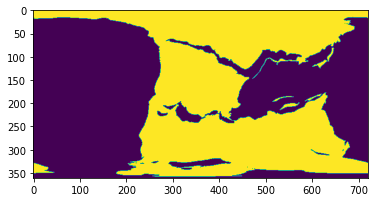

Working on Time 140.00Ma

Selected Time is in the stage 140.00Ma to 152.00Ma
Temporary fix for valid time
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_140Ma/m_fig44_146_135_PresentDay_Paleogeog_Matthews2016_140.00Ma.shp']


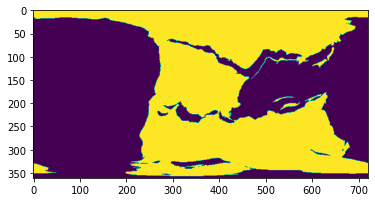

Working on Time 141.00Ma

Selected Time is in the stage 140.00Ma to 152.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_140Ma/m_fig44_146_135_PresentDay_Paleogeog_Matthews2016_140.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_152Ma/m_fig42_166_146_PresentDay_Paleogeog_Matthews2016_152.00Ma.shp']


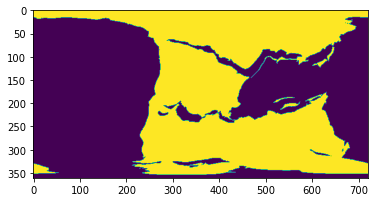

Working on Time 142.00Ma

Selected Time is in the stage 140.00Ma to 152.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_140Ma/m_fig44_146_135_PresentDay_Paleogeog_Matthews2016_140.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_152Ma/m_fig42_166_146_PresentDay_Paleogeog_Matthews2016_152.00Ma.shp']


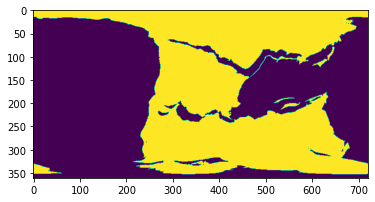

Working on Time 143.00Ma

Selected Time is in the stage 140.00Ma to 152.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_140Ma/m_fig44_146_135_PresentDay_Paleogeog_Matthews2016_140.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_152Ma/m_fig42_166_146_PresentDay_Paleogeog_Matthews2016_152.00Ma.shp']


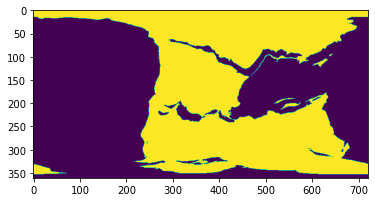

Working on Time 144.00Ma

Selected Time is in the stage 140.00Ma to 152.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_140Ma/m_fig44_146_135_PresentDay_Paleogeog_Matthews2016_140.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_152Ma/m_fig42_166_146_PresentDay_Paleogeog_Matthews2016_152.00Ma.shp']


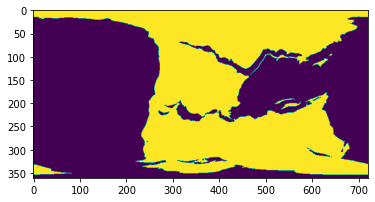

Working on Time 145.00Ma

Selected Time is in the stage 140.00Ma to 152.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_140Ma/m_fig44_146_135_PresentDay_Paleogeog_Matthews2016_140.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_152Ma/m_fig42_166_146_PresentDay_Paleogeog_Matthews2016_152.00Ma.shp']


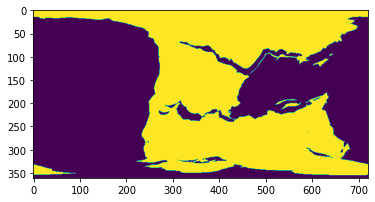

Working on Time 146.00Ma

Selected Time is in the stage 140.00Ma to 152.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_140Ma/m_fig44_146_135_PresentDay_Paleogeog_Matthews2016_140.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_152Ma/m_fig42_166_146_PresentDay_Paleogeog_Matthews2016_152.00Ma.shp']


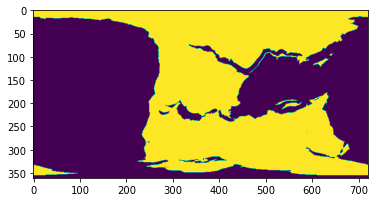

Working on Time 147.00Ma

Selected Time is in the stage 140.00Ma to 152.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_140Ma/m_fig44_146_135_PresentDay_Paleogeog_Matthews2016_140.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_152Ma/m_fig42_166_146_PresentDay_Paleogeog_Matthews2016_152.00Ma.shp']


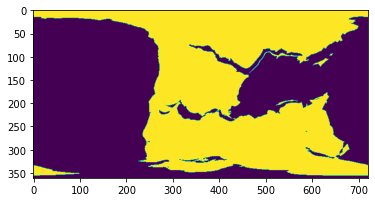

Working on Time 148.00Ma

Selected Time is in the stage 140.00Ma to 152.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_140Ma/m_fig44_146_135_PresentDay_Paleogeog_Matthews2016_140.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_152Ma/m_fig42_166_146_PresentDay_Paleogeog_Matthews2016_152.00Ma.shp']


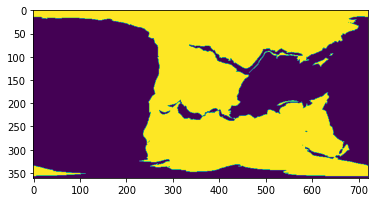

Working on Time 149.00Ma

Selected Time is in the stage 140.00Ma to 152.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_140Ma/m_fig44_146_135_PresentDay_Paleogeog_Matthews2016_140.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_152Ma/m_fig42_166_146_PresentDay_Paleogeog_Matthews2016_152.00Ma.shp']


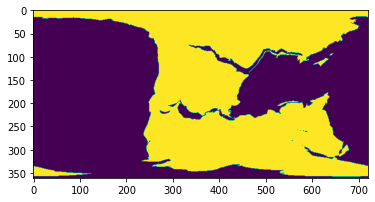

Working on Time 150.00Ma

Selected Time is in the stage 140.00Ma to 152.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_140Ma/m_fig44_146_135_PresentDay_Paleogeog_Matthews2016_140.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_152Ma/m_fig42_166_146_PresentDay_Paleogeog_Matthews2016_152.00Ma.shp']


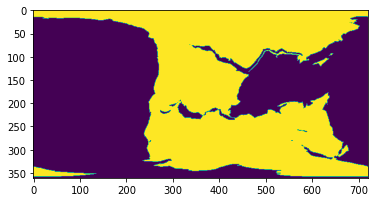

Working on Time 151.00Ma

Selected Time is in the stage 140.00Ma to 152.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_140Ma/m_fig44_146_135_PresentDay_Paleogeog_Matthews2016_140.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_152Ma/m_fig42_166_146_PresentDay_Paleogeog_Matthews2016_152.00Ma.shp']


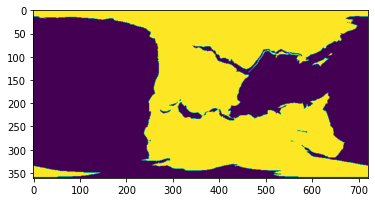

Working on Time 152.00Ma

Selected Time is in the stage 152.00Ma to 169.00Ma
Temporary fix for valid time
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_152Ma/m_fig42_166_146_PresentDay_Paleogeog_Matthews2016_152.00Ma.shp']


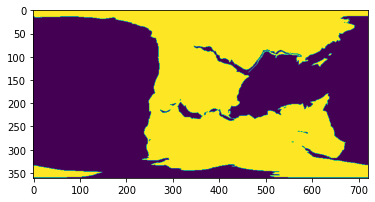

Working on Time 153.00Ma

Selected Time is in the stage 152.00Ma to 169.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_152Ma/m_fig42_166_146_PresentDay_Paleogeog_Matthews2016_152.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_169Ma/m_fig40_179_166_PresentDay_Paleogeog_Matthews2016_169.00Ma.shp']


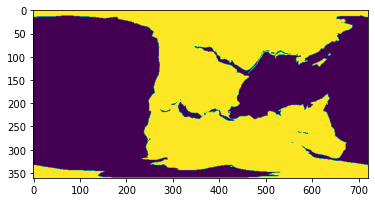

Working on Time 154.00Ma

Selected Time is in the stage 152.00Ma to 169.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_152Ma/m_fig42_166_146_PresentDay_Paleogeog_Matthews2016_152.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_169Ma/m_fig40_179_166_PresentDay_Paleogeog_Matthews2016_169.00Ma.shp']


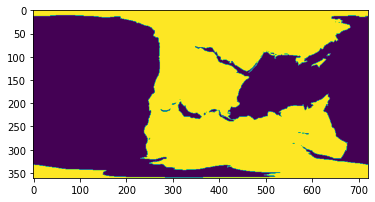

Working on Time 155.00Ma

Selected Time is in the stage 152.00Ma to 169.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_152Ma/m_fig42_166_146_PresentDay_Paleogeog_Matthews2016_152.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_169Ma/m_fig40_179_166_PresentDay_Paleogeog_Matthews2016_169.00Ma.shp']


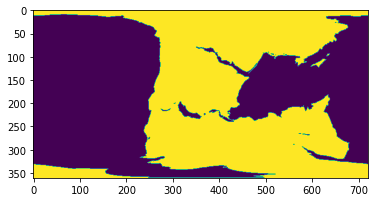

Working on Time 156.00Ma

Selected Time is in the stage 152.00Ma to 169.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_152Ma/m_fig42_166_146_PresentDay_Paleogeog_Matthews2016_152.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_169Ma/m_fig40_179_166_PresentDay_Paleogeog_Matthews2016_169.00Ma.shp']


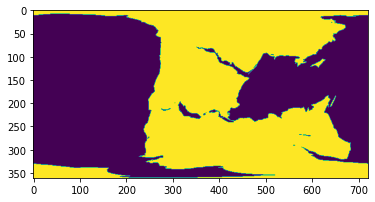

Working on Time 157.00Ma

Selected Time is in the stage 152.00Ma to 169.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_152Ma/m_fig42_166_146_PresentDay_Paleogeog_Matthews2016_152.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_169Ma/m_fig40_179_166_PresentDay_Paleogeog_Matthews2016_169.00Ma.shp']


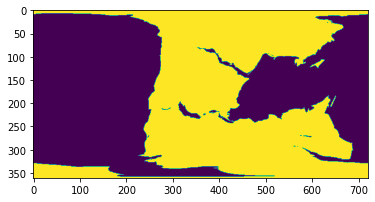

Working on Time 158.00Ma

Selected Time is in the stage 152.00Ma to 169.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_152Ma/m_fig42_166_146_PresentDay_Paleogeog_Matthews2016_152.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_169Ma/m_fig40_179_166_PresentDay_Paleogeog_Matthews2016_169.00Ma.shp']


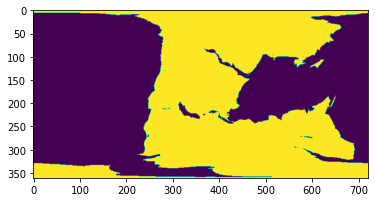

Working on Time 159.00Ma

Selected Time is in the stage 152.00Ma to 169.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_152Ma/m_fig42_166_146_PresentDay_Paleogeog_Matthews2016_152.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_169Ma/m_fig40_179_166_PresentDay_Paleogeog_Matthews2016_169.00Ma.shp']


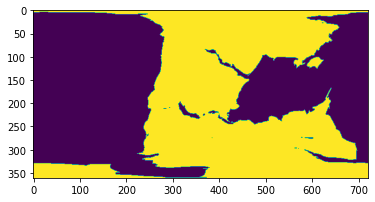

Working on Time 160.00Ma

Selected Time is in the stage 152.00Ma to 169.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_152Ma/m_fig42_166_146_PresentDay_Paleogeog_Matthews2016_152.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_169Ma/m_fig40_179_166_PresentDay_Paleogeog_Matthews2016_169.00Ma.shp']


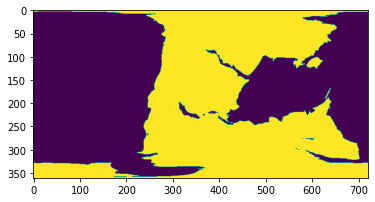

Working on Time 161.00Ma

Selected Time is in the stage 152.00Ma to 169.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_152Ma/m_fig42_166_146_PresentDay_Paleogeog_Matthews2016_152.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_169Ma/m_fig40_179_166_PresentDay_Paleogeog_Matthews2016_169.00Ma.shp']


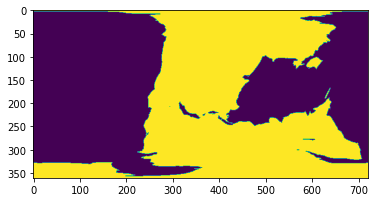

Working on Time 162.00Ma

Selected Time is in the stage 152.00Ma to 169.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_152Ma/m_fig42_166_146_PresentDay_Paleogeog_Matthews2016_152.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_169Ma/m_fig40_179_166_PresentDay_Paleogeog_Matthews2016_169.00Ma.shp']


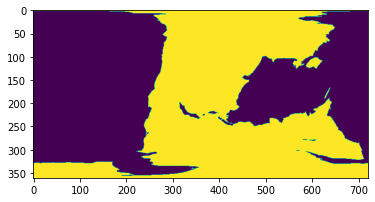

Working on Time 163.00Ma

Selected Time is in the stage 152.00Ma to 169.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_152Ma/m_fig42_166_146_PresentDay_Paleogeog_Matthews2016_152.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_169Ma/m_fig40_179_166_PresentDay_Paleogeog_Matthews2016_169.00Ma.shp']


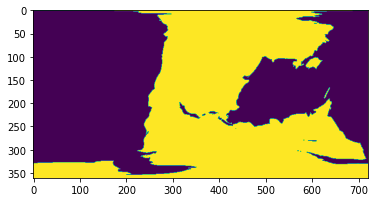

Working on Time 164.00Ma

Selected Time is in the stage 152.00Ma to 169.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_152Ma/m_fig42_166_146_PresentDay_Paleogeog_Matthews2016_152.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_169Ma/m_fig40_179_166_PresentDay_Paleogeog_Matthews2016_169.00Ma.shp']


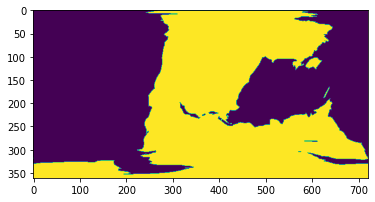

Working on Time 165.00Ma

Selected Time is in the stage 152.00Ma to 169.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_152Ma/m_fig42_166_146_PresentDay_Paleogeog_Matthews2016_152.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_169Ma/m_fig40_179_166_PresentDay_Paleogeog_Matthews2016_169.00Ma.shp']


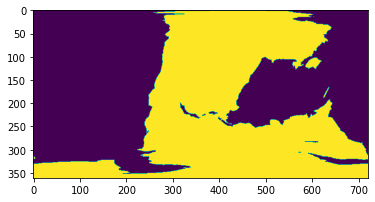

Working on Time 166.00Ma

Selected Time is in the stage 152.00Ma to 169.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_152Ma/m_fig42_166_146_PresentDay_Paleogeog_Matthews2016_152.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_169Ma/m_fig40_179_166_PresentDay_Paleogeog_Matthews2016_169.00Ma.shp']


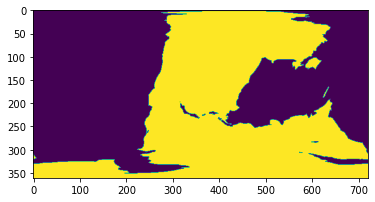

Working on Time 167.00Ma

Selected Time is in the stage 152.00Ma to 169.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_152Ma/m_fig42_166_146_PresentDay_Paleogeog_Matthews2016_152.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_169Ma/m_fig40_179_166_PresentDay_Paleogeog_Matthews2016_169.00Ma.shp']


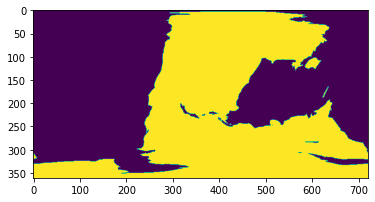

Working on Time 168.00Ma

Selected Time is in the stage 152.00Ma to 169.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_152Ma/m_fig42_166_146_PresentDay_Paleogeog_Matthews2016_152.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_169Ma/m_fig40_179_166_PresentDay_Paleogeog_Matthews2016_169.00Ma.shp']


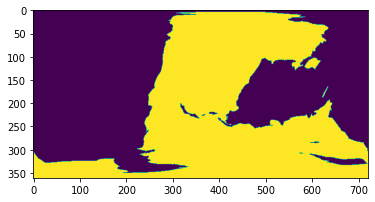

Working on Time 169.00Ma

Selected Time is in the stage 169.00Ma to 195.00Ma
Temporary fix for valid time
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_169Ma/m_fig40_179_166_PresentDay_Paleogeog_Matthews2016_169.00Ma.shp']


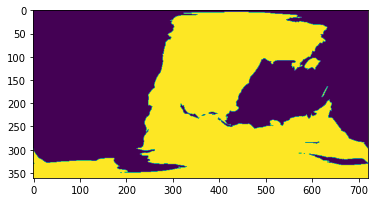

Working on Time 170.00Ma

Selected Time is in the stage 169.00Ma to 195.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_169Ma/m_fig40_179_166_PresentDay_Paleogeog_Matthews2016_169.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_195Ma/m_fig38_203_179_PresentDay_Paleogeog_Matthews2016_195.00Ma.shp']


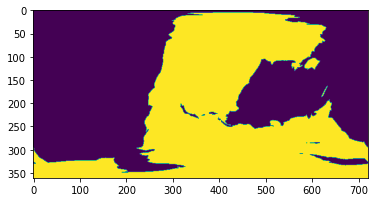

Working on Time 171.00Ma

Selected Time is in the stage 169.00Ma to 195.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_169Ma/m_fig40_179_166_PresentDay_Paleogeog_Matthews2016_169.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_195Ma/m_fig38_203_179_PresentDay_Paleogeog_Matthews2016_195.00Ma.shp']


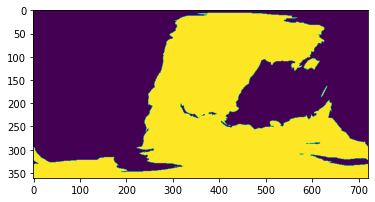

Working on Time 172.00Ma

Selected Time is in the stage 169.00Ma to 195.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_169Ma/m_fig40_179_166_PresentDay_Paleogeog_Matthews2016_169.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_195Ma/m_fig38_203_179_PresentDay_Paleogeog_Matthews2016_195.00Ma.shp']


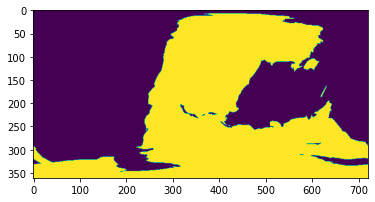

Working on Time 173.00Ma

Selected Time is in the stage 169.00Ma to 195.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_169Ma/m_fig40_179_166_PresentDay_Paleogeog_Matthews2016_169.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_195Ma/m_fig38_203_179_PresentDay_Paleogeog_Matthews2016_195.00Ma.shp']


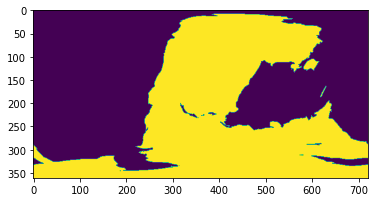

Working on Time 174.00Ma

Selected Time is in the stage 169.00Ma to 195.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_169Ma/m_fig40_179_166_PresentDay_Paleogeog_Matthews2016_169.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_195Ma/m_fig38_203_179_PresentDay_Paleogeog_Matthews2016_195.00Ma.shp']


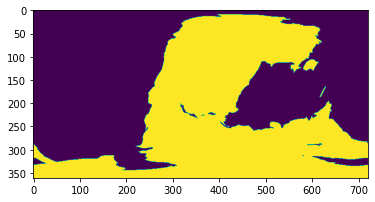

Working on Time 175.00Ma

Selected Time is in the stage 169.00Ma to 195.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_169Ma/m_fig40_179_166_PresentDay_Paleogeog_Matthews2016_169.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_195Ma/m_fig38_203_179_PresentDay_Paleogeog_Matthews2016_195.00Ma.shp']


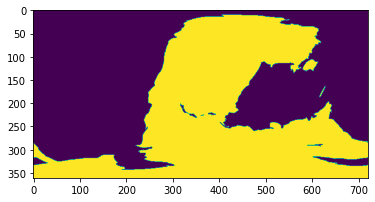

Working on Time 176.00Ma

Selected Time is in the stage 169.00Ma to 195.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_169Ma/m_fig40_179_166_PresentDay_Paleogeog_Matthews2016_169.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_195Ma/m_fig38_203_179_PresentDay_Paleogeog_Matthews2016_195.00Ma.shp']


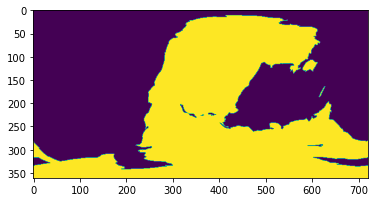

Working on Time 177.00Ma

Selected Time is in the stage 169.00Ma to 195.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_169Ma/m_fig40_179_166_PresentDay_Paleogeog_Matthews2016_169.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_195Ma/m_fig38_203_179_PresentDay_Paleogeog_Matthews2016_195.00Ma.shp']


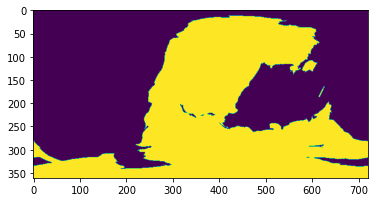

Working on Time 178.00Ma

Selected Time is in the stage 169.00Ma to 195.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_169Ma/m_fig40_179_166_PresentDay_Paleogeog_Matthews2016_169.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_195Ma/m_fig38_203_179_PresentDay_Paleogeog_Matthews2016_195.00Ma.shp']


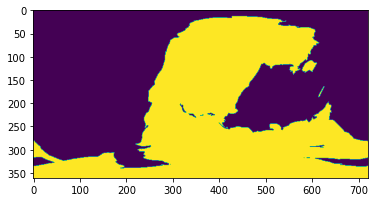

Working on Time 179.00Ma

Selected Time is in the stage 169.00Ma to 195.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_169Ma/m_fig40_179_166_PresentDay_Paleogeog_Matthews2016_169.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_195Ma/m_fig38_203_179_PresentDay_Paleogeog_Matthews2016_195.00Ma.shp']


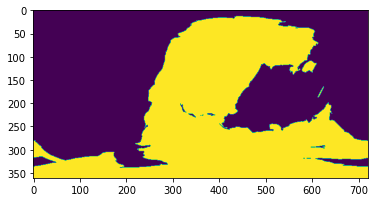

Working on Time 180.00Ma

Selected Time is in the stage 169.00Ma to 195.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_169Ma/m_fig40_179_166_PresentDay_Paleogeog_Matthews2016_169.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_195Ma/m_fig38_203_179_PresentDay_Paleogeog_Matthews2016_195.00Ma.shp']


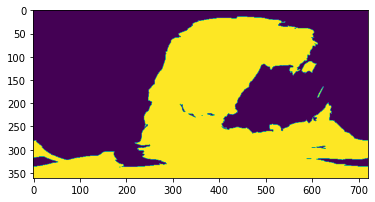

Working on Time 181.00Ma

Selected Time is in the stage 169.00Ma to 195.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_169Ma/m_fig40_179_166_PresentDay_Paleogeog_Matthews2016_169.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_195Ma/m_fig38_203_179_PresentDay_Paleogeog_Matthews2016_195.00Ma.shp']


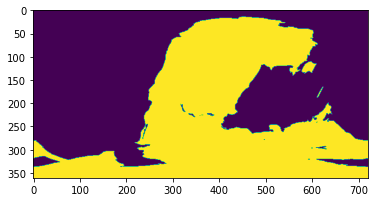

Working on Time 182.00Ma

Selected Time is in the stage 169.00Ma to 195.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_169Ma/m_fig40_179_166_PresentDay_Paleogeog_Matthews2016_169.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_195Ma/m_fig38_203_179_PresentDay_Paleogeog_Matthews2016_195.00Ma.shp']


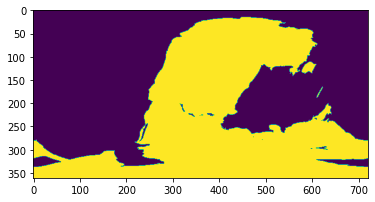

Working on Time 183.00Ma

Selected Time is in the stage 169.00Ma to 195.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_169Ma/m_fig40_179_166_PresentDay_Paleogeog_Matthews2016_169.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_195Ma/m_fig38_203_179_PresentDay_Paleogeog_Matthews2016_195.00Ma.shp']


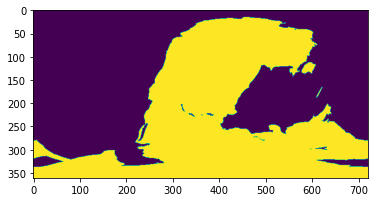

Working on Time 184.00Ma

Selected Time is in the stage 169.00Ma to 195.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_169Ma/m_fig40_179_166_PresentDay_Paleogeog_Matthews2016_169.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_195Ma/m_fig38_203_179_PresentDay_Paleogeog_Matthews2016_195.00Ma.shp']


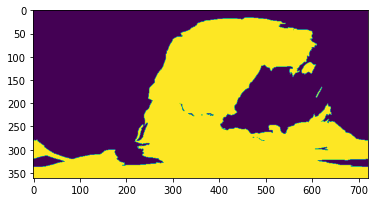

Working on Time 185.00Ma

Selected Time is in the stage 169.00Ma to 195.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_169Ma/m_fig40_179_166_PresentDay_Paleogeog_Matthews2016_169.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_195Ma/m_fig38_203_179_PresentDay_Paleogeog_Matthews2016_195.00Ma.shp']


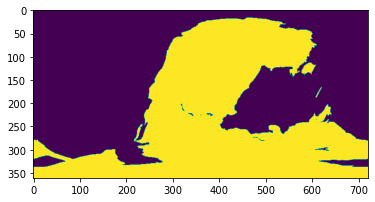

Working on Time 186.00Ma

Selected Time is in the stage 169.00Ma to 195.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_169Ma/m_fig40_179_166_PresentDay_Paleogeog_Matthews2016_169.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_195Ma/m_fig38_203_179_PresentDay_Paleogeog_Matthews2016_195.00Ma.shp']


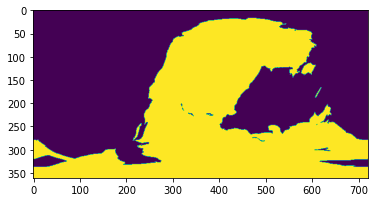

Working on Time 187.00Ma

Selected Time is in the stage 169.00Ma to 195.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_169Ma/m_fig40_179_166_PresentDay_Paleogeog_Matthews2016_169.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_195Ma/m_fig38_203_179_PresentDay_Paleogeog_Matthews2016_195.00Ma.shp']


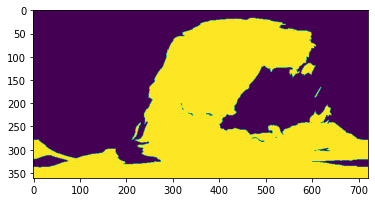

Working on Time 188.00Ma

Selected Time is in the stage 169.00Ma to 195.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_169Ma/m_fig40_179_166_PresentDay_Paleogeog_Matthews2016_169.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_195Ma/m_fig38_203_179_PresentDay_Paleogeog_Matthews2016_195.00Ma.shp']


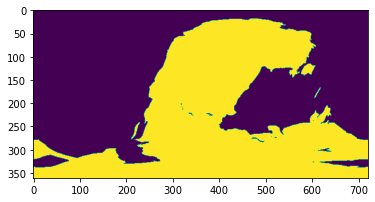

Working on Time 189.00Ma

Selected Time is in the stage 169.00Ma to 195.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_169Ma/m_fig40_179_166_PresentDay_Paleogeog_Matthews2016_169.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_195Ma/m_fig38_203_179_PresentDay_Paleogeog_Matthews2016_195.00Ma.shp']


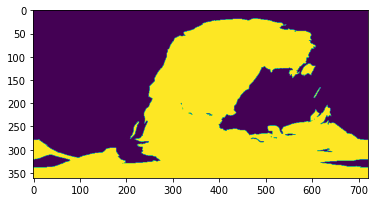

Working on Time 190.00Ma

Selected Time is in the stage 169.00Ma to 195.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_169Ma/m_fig40_179_166_PresentDay_Paleogeog_Matthews2016_169.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_195Ma/m_fig38_203_179_PresentDay_Paleogeog_Matthews2016_195.00Ma.shp']


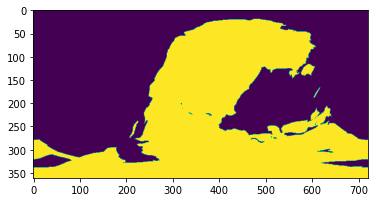

Working on Time 191.00Ma

Selected Time is in the stage 169.00Ma to 195.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_169Ma/m_fig40_179_166_PresentDay_Paleogeog_Matthews2016_169.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_195Ma/m_fig38_203_179_PresentDay_Paleogeog_Matthews2016_195.00Ma.shp']


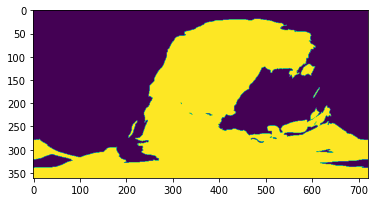

Working on Time 192.00Ma

Selected Time is in the stage 169.00Ma to 195.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_169Ma/m_fig40_179_166_PresentDay_Paleogeog_Matthews2016_169.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_195Ma/m_fig38_203_179_PresentDay_Paleogeog_Matthews2016_195.00Ma.shp']


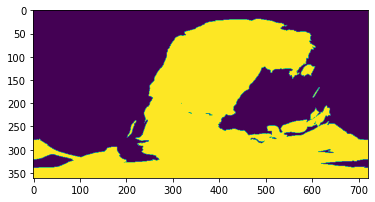

Working on Time 193.00Ma

Selected Time is in the stage 169.00Ma to 195.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_169Ma/m_fig40_179_166_PresentDay_Paleogeog_Matthews2016_169.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_195Ma/m_fig38_203_179_PresentDay_Paleogeog_Matthews2016_195.00Ma.shp']


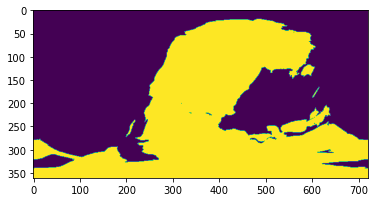

Working on Time 194.00Ma

Selected Time is in the stage 169.00Ma to 195.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_169Ma/m_fig40_179_166_PresentDay_Paleogeog_Matthews2016_169.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_195Ma/m_fig38_203_179_PresentDay_Paleogeog_Matthews2016_195.00Ma.shp']


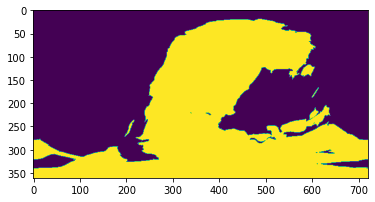

Working on Time 195.00Ma

Selected Time is in the stage 195.00Ma to 218.00Ma
Temporary fix for valid time
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_195Ma/m_fig38_203_179_PresentDay_Paleogeog_Matthews2016_195.00Ma.shp']


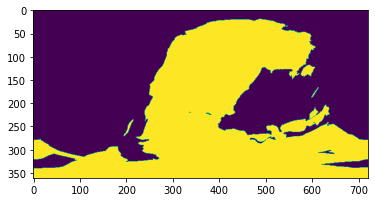

Working on Time 196.00Ma

Selected Time is in the stage 195.00Ma to 218.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_195Ma/m_fig38_203_179_PresentDay_Paleogeog_Matthews2016_195.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_218Ma/m_fig36_224_203_PresentDay_Paleogeog_Matthews2016_218.00Ma.shp']


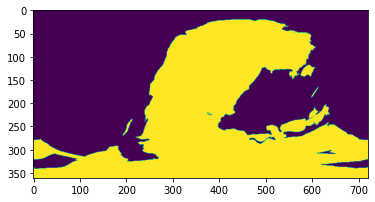

Working on Time 197.00Ma

Selected Time is in the stage 195.00Ma to 218.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_195Ma/m_fig38_203_179_PresentDay_Paleogeog_Matthews2016_195.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_218Ma/m_fig36_224_203_PresentDay_Paleogeog_Matthews2016_218.00Ma.shp']


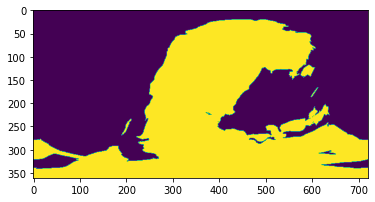

Working on Time 198.00Ma

Selected Time is in the stage 195.00Ma to 218.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_195Ma/m_fig38_203_179_PresentDay_Paleogeog_Matthews2016_195.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_218Ma/m_fig36_224_203_PresentDay_Paleogeog_Matthews2016_218.00Ma.shp']


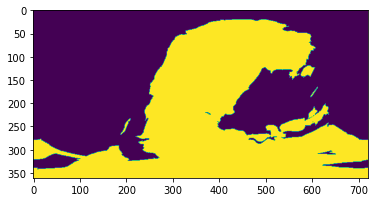

Working on Time 199.00Ma

Selected Time is in the stage 195.00Ma to 218.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_195Ma/m_fig38_203_179_PresentDay_Paleogeog_Matthews2016_195.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_218Ma/m_fig36_224_203_PresentDay_Paleogeog_Matthews2016_218.00Ma.shp']


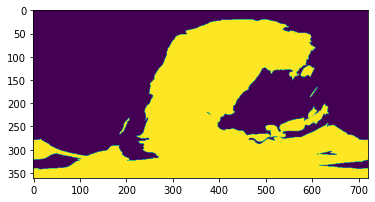

Working on Time 200.00Ma

Selected Time is in the stage 195.00Ma to 218.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_195Ma/m_fig38_203_179_PresentDay_Paleogeog_Matthews2016_195.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_218Ma/m_fig36_224_203_PresentDay_Paleogeog_Matthews2016_218.00Ma.shp']


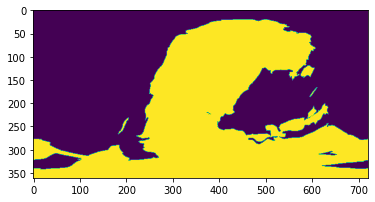

Working on Time 201.00Ma

Selected Time is in the stage 195.00Ma to 218.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_195Ma/m_fig38_203_179_PresentDay_Paleogeog_Matthews2016_195.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_218Ma/m_fig36_224_203_PresentDay_Paleogeog_Matthews2016_218.00Ma.shp']


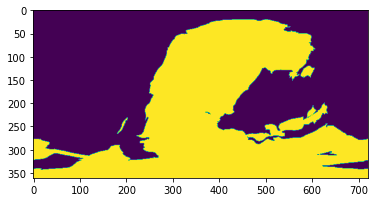

Working on Time 202.00Ma

Selected Time is in the stage 195.00Ma to 218.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_195Ma/m_fig38_203_179_PresentDay_Paleogeog_Matthews2016_195.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_218Ma/m_fig36_224_203_PresentDay_Paleogeog_Matthews2016_218.00Ma.shp']


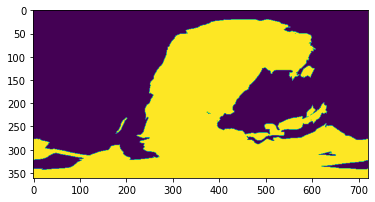

Working on Time 203.00Ma

Selected Time is in the stage 195.00Ma to 218.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_195Ma/m_fig38_203_179_PresentDay_Paleogeog_Matthews2016_195.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_218Ma/m_fig36_224_203_PresentDay_Paleogeog_Matthews2016_218.00Ma.shp']


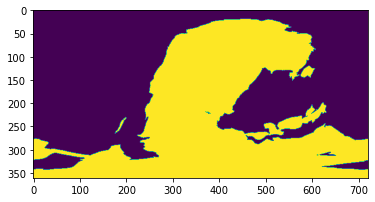

Working on Time 204.00Ma

Selected Time is in the stage 195.00Ma to 218.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_195Ma/m_fig38_203_179_PresentDay_Paleogeog_Matthews2016_195.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_218Ma/m_fig36_224_203_PresentDay_Paleogeog_Matthews2016_218.00Ma.shp']


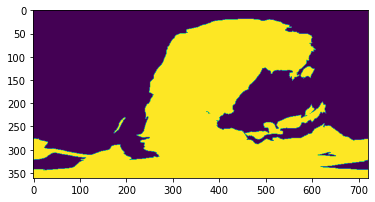

Working on Time 205.00Ma

Selected Time is in the stage 195.00Ma to 218.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_195Ma/m_fig38_203_179_PresentDay_Paleogeog_Matthews2016_195.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_218Ma/m_fig36_224_203_PresentDay_Paleogeog_Matthews2016_218.00Ma.shp']


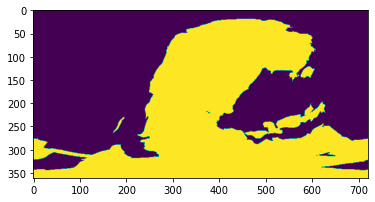

Working on Time 206.00Ma

Selected Time is in the stage 195.00Ma to 218.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_195Ma/m_fig38_203_179_PresentDay_Paleogeog_Matthews2016_195.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_218Ma/m_fig36_224_203_PresentDay_Paleogeog_Matthews2016_218.00Ma.shp']


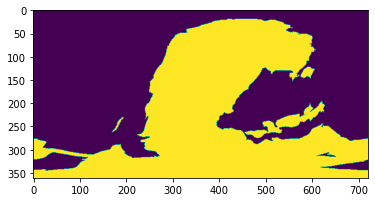

Working on Time 207.00Ma

Selected Time is in the stage 195.00Ma to 218.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_195Ma/m_fig38_203_179_PresentDay_Paleogeog_Matthews2016_195.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_218Ma/m_fig36_224_203_PresentDay_Paleogeog_Matthews2016_218.00Ma.shp']


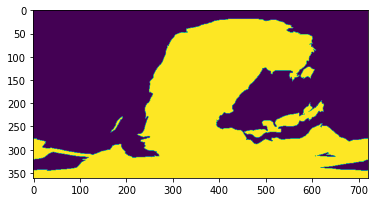

Working on Time 208.00Ma

Selected Time is in the stage 195.00Ma to 218.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_195Ma/m_fig38_203_179_PresentDay_Paleogeog_Matthews2016_195.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_218Ma/m_fig36_224_203_PresentDay_Paleogeog_Matthews2016_218.00Ma.shp']


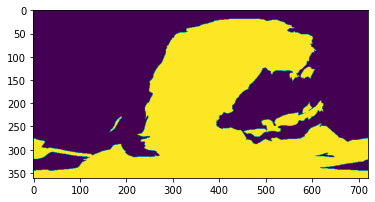

Working on Time 209.00Ma

Selected Time is in the stage 195.00Ma to 218.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_195Ma/m_fig38_203_179_PresentDay_Paleogeog_Matthews2016_195.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_218Ma/m_fig36_224_203_PresentDay_Paleogeog_Matthews2016_218.00Ma.shp']


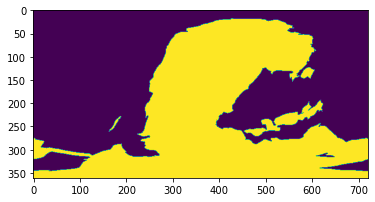

Working on Time 210.00Ma

Selected Time is in the stage 195.00Ma to 218.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_195Ma/m_fig38_203_179_PresentDay_Paleogeog_Matthews2016_195.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_218Ma/m_fig36_224_203_PresentDay_Paleogeog_Matthews2016_218.00Ma.shp']


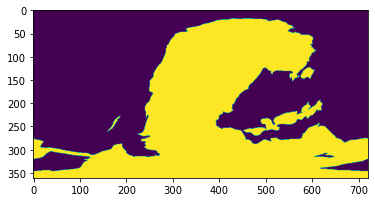

Working on Time 211.00Ma

Selected Time is in the stage 195.00Ma to 218.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_195Ma/m_fig38_203_179_PresentDay_Paleogeog_Matthews2016_195.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_218Ma/m_fig36_224_203_PresentDay_Paleogeog_Matthews2016_218.00Ma.shp']


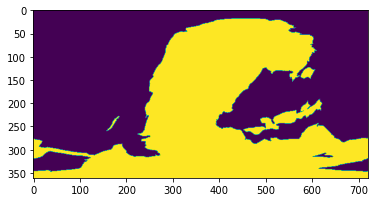

Working on Time 212.00Ma

Selected Time is in the stage 195.00Ma to 218.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_195Ma/m_fig38_203_179_PresentDay_Paleogeog_Matthews2016_195.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_218Ma/m_fig36_224_203_PresentDay_Paleogeog_Matthews2016_218.00Ma.shp']


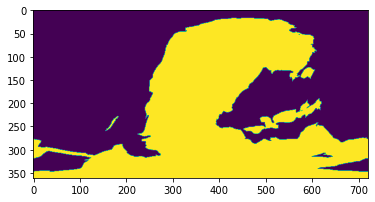

Working on Time 213.00Ma

Selected Time is in the stage 195.00Ma to 218.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_195Ma/m_fig38_203_179_PresentDay_Paleogeog_Matthews2016_195.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_218Ma/m_fig36_224_203_PresentDay_Paleogeog_Matthews2016_218.00Ma.shp']


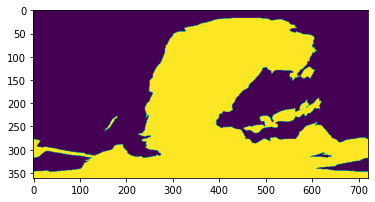

Working on Time 214.00Ma

Selected Time is in the stage 195.00Ma to 218.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_195Ma/m_fig38_203_179_PresentDay_Paleogeog_Matthews2016_195.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_218Ma/m_fig36_224_203_PresentDay_Paleogeog_Matthews2016_218.00Ma.shp']


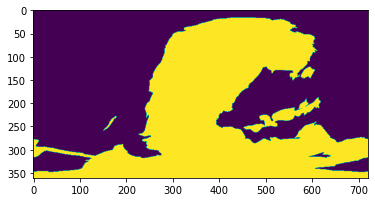

Working on Time 215.00Ma

Selected Time is in the stage 195.00Ma to 218.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_195Ma/m_fig38_203_179_PresentDay_Paleogeog_Matthews2016_195.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_218Ma/m_fig36_224_203_PresentDay_Paleogeog_Matthews2016_218.00Ma.shp']


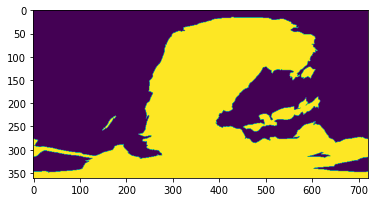

Working on Time 216.00Ma

Selected Time is in the stage 195.00Ma to 218.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_195Ma/m_fig38_203_179_PresentDay_Paleogeog_Matthews2016_195.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_218Ma/m_fig36_224_203_PresentDay_Paleogeog_Matthews2016_218.00Ma.shp']


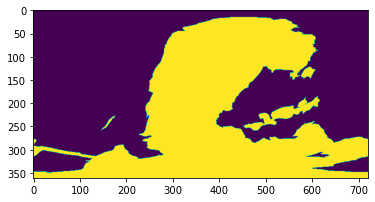

Working on Time 217.00Ma

Selected Time is in the stage 195.00Ma to 218.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_195Ma/m_fig38_203_179_PresentDay_Paleogeog_Matthews2016_195.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_218Ma/m_fig36_224_203_PresentDay_Paleogeog_Matthews2016_218.00Ma.shp']


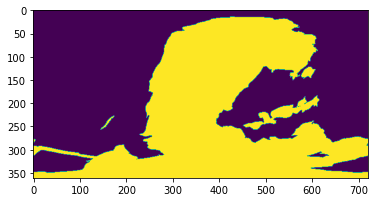

Working on Time 218.00Ma

Selected Time is in the stage 218.00Ma to 232.00Ma
Temporary fix for valid time
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_218Ma/m_fig36_224_203_PresentDay_Paleogeog_Matthews2016_218.00Ma.shp']


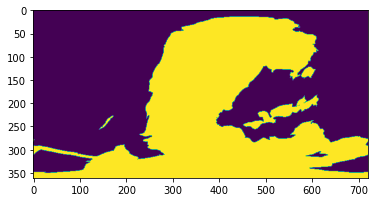

Working on Time 219.00Ma

Selected Time is in the stage 218.00Ma to 232.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_218Ma/m_fig36_224_203_PresentDay_Paleogeog_Matthews2016_218.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_232Ma/m_fig34_248_224_PresentDay_Paleogeog_Matthews2016_232.00Ma.shp']


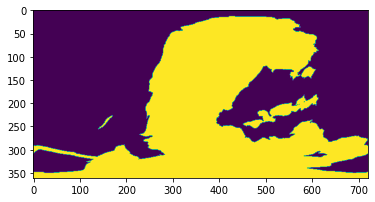

Working on Time 220.00Ma

Selected Time is in the stage 218.00Ma to 232.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_218Ma/m_fig36_224_203_PresentDay_Paleogeog_Matthews2016_218.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_232Ma/m_fig34_248_224_PresentDay_Paleogeog_Matthews2016_232.00Ma.shp']


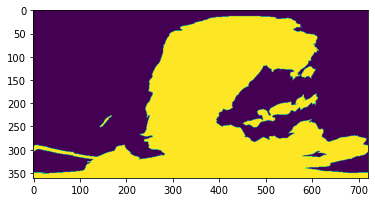

Working on Time 221.00Ma

Selected Time is in the stage 218.00Ma to 232.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_218Ma/m_fig36_224_203_PresentDay_Paleogeog_Matthews2016_218.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_232Ma/m_fig34_248_224_PresentDay_Paleogeog_Matthews2016_232.00Ma.shp']


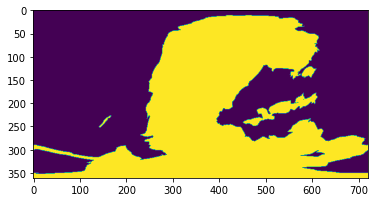

Working on Time 222.00Ma

Selected Time is in the stage 218.00Ma to 232.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_218Ma/m_fig36_224_203_PresentDay_Paleogeog_Matthews2016_218.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_232Ma/m_fig34_248_224_PresentDay_Paleogeog_Matthews2016_232.00Ma.shp']


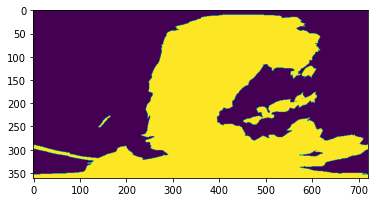

Working on Time 223.00Ma

Selected Time is in the stage 218.00Ma to 232.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_218Ma/m_fig36_224_203_PresentDay_Paleogeog_Matthews2016_218.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_232Ma/m_fig34_248_224_PresentDay_Paleogeog_Matthews2016_232.00Ma.shp']


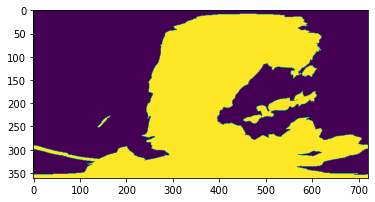

Working on Time 224.00Ma

Selected Time is in the stage 218.00Ma to 232.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_218Ma/m_fig36_224_203_PresentDay_Paleogeog_Matthews2016_218.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_232Ma/m_fig34_248_224_PresentDay_Paleogeog_Matthews2016_232.00Ma.shp']


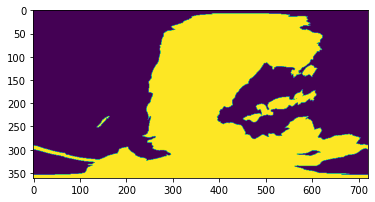

Working on Time 225.00Ma

Selected Time is in the stage 218.00Ma to 232.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_218Ma/m_fig36_224_203_PresentDay_Paleogeog_Matthews2016_218.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_232Ma/m_fig34_248_224_PresentDay_Paleogeog_Matthews2016_232.00Ma.shp']


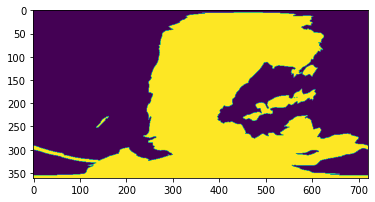

Working on Time 226.00Ma

Selected Time is in the stage 218.00Ma to 232.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_218Ma/m_fig36_224_203_PresentDay_Paleogeog_Matthews2016_218.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_232Ma/m_fig34_248_224_PresentDay_Paleogeog_Matthews2016_232.00Ma.shp']


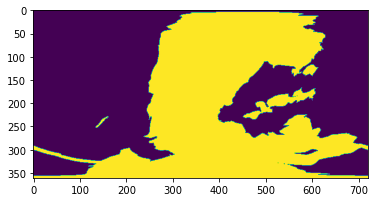

Working on Time 227.00Ma

Selected Time is in the stage 218.00Ma to 232.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_218Ma/m_fig36_224_203_PresentDay_Paleogeog_Matthews2016_218.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_232Ma/m_fig34_248_224_PresentDay_Paleogeog_Matthews2016_232.00Ma.shp']


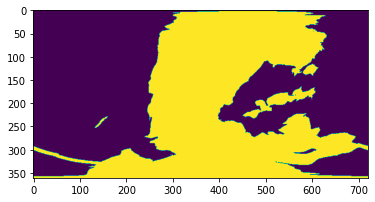

Working on Time 228.00Ma

Selected Time is in the stage 218.00Ma to 232.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_218Ma/m_fig36_224_203_PresentDay_Paleogeog_Matthews2016_218.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_232Ma/m_fig34_248_224_PresentDay_Paleogeog_Matthews2016_232.00Ma.shp']


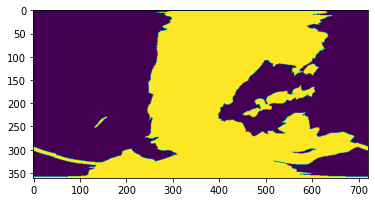

Working on Time 229.00Ma

Selected Time is in the stage 218.00Ma to 232.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_218Ma/m_fig36_224_203_PresentDay_Paleogeog_Matthews2016_218.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_232Ma/m_fig34_248_224_PresentDay_Paleogeog_Matthews2016_232.00Ma.shp']


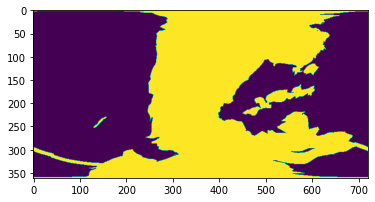

Working on Time 230.00Ma

Selected Time is in the stage 218.00Ma to 232.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_218Ma/m_fig36_224_203_PresentDay_Paleogeog_Matthews2016_218.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_232Ma/m_fig34_248_224_PresentDay_Paleogeog_Matthews2016_232.00Ma.shp']


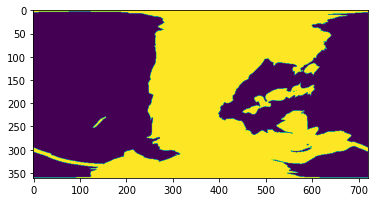

Working on Time 231.00Ma

Selected Time is in the stage 218.00Ma to 232.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_218Ma/m_fig36_224_203_PresentDay_Paleogeog_Matthews2016_218.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_232Ma/m_fig34_248_224_PresentDay_Paleogeog_Matthews2016_232.00Ma.shp']


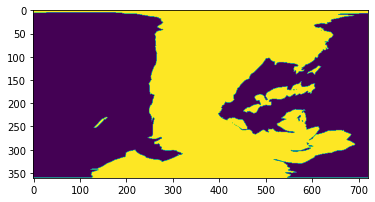

Working on Time 232.00Ma

Selected Time is in the stage 232.00Ma to 255.00Ma
Temporary fix for valid time
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_232Ma/m_fig34_248_224_PresentDay_Paleogeog_Matthews2016_232.00Ma.shp']


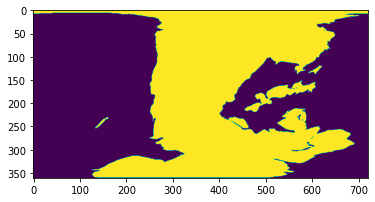

Working on Time 233.00Ma

Selected Time is in the stage 232.00Ma to 255.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_232Ma/m_fig34_248_224_PresentDay_Paleogeog_Matthews2016_232.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_255Ma/m_fig32_269_248_PresentDay_Paleogeog_Matthews2016_255.00Ma.shp']


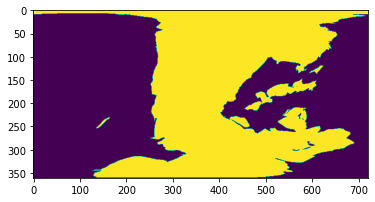

Working on Time 234.00Ma

Selected Time is in the stage 232.00Ma to 255.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_232Ma/m_fig34_248_224_PresentDay_Paleogeog_Matthews2016_232.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_255Ma/m_fig32_269_248_PresentDay_Paleogeog_Matthews2016_255.00Ma.shp']


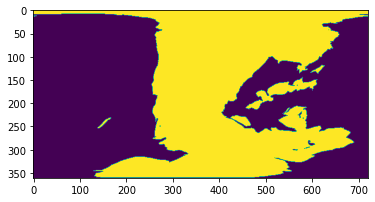

Working on Time 235.00Ma

Selected Time is in the stage 232.00Ma to 255.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_232Ma/m_fig34_248_224_PresentDay_Paleogeog_Matthews2016_232.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_255Ma/m_fig32_269_248_PresentDay_Paleogeog_Matthews2016_255.00Ma.shp']


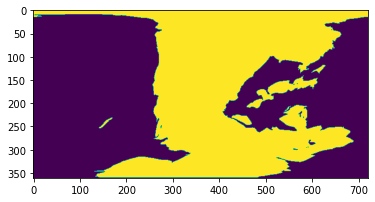

Working on Time 236.00Ma

Selected Time is in the stage 232.00Ma to 255.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_232Ma/m_fig34_248_224_PresentDay_Paleogeog_Matthews2016_232.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_255Ma/m_fig32_269_248_PresentDay_Paleogeog_Matthews2016_255.00Ma.shp']


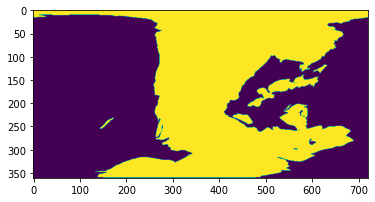

Working on Time 237.00Ma

Selected Time is in the stage 232.00Ma to 255.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_232Ma/m_fig34_248_224_PresentDay_Paleogeog_Matthews2016_232.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_255Ma/m_fig32_269_248_PresentDay_Paleogeog_Matthews2016_255.00Ma.shp']


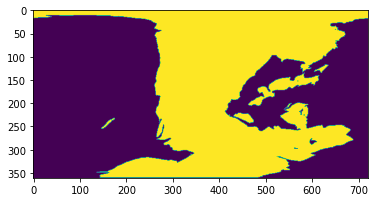

Working on Time 238.00Ma

Selected Time is in the stage 232.00Ma to 255.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_232Ma/m_fig34_248_224_PresentDay_Paleogeog_Matthews2016_232.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_255Ma/m_fig32_269_248_PresentDay_Paleogeog_Matthews2016_255.00Ma.shp']


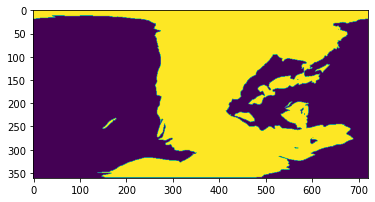

Working on Time 239.00Ma

Selected Time is in the stage 232.00Ma to 255.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_232Ma/m_fig34_248_224_PresentDay_Paleogeog_Matthews2016_232.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_255Ma/m_fig32_269_248_PresentDay_Paleogeog_Matthews2016_255.00Ma.shp']


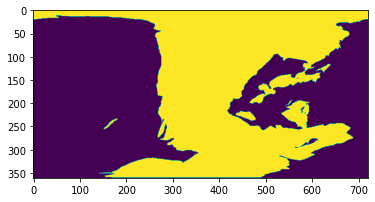

Working on Time 240.00Ma

Selected Time is in the stage 232.00Ma to 255.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_232Ma/m_fig34_248_224_PresentDay_Paleogeog_Matthews2016_232.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_255Ma/m_fig32_269_248_PresentDay_Paleogeog_Matthews2016_255.00Ma.shp']


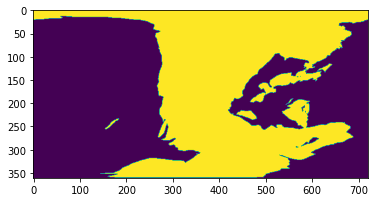

Working on Time 241.00Ma

Selected Time is in the stage 232.00Ma to 255.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_232Ma/m_fig34_248_224_PresentDay_Paleogeog_Matthews2016_232.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_255Ma/m_fig32_269_248_PresentDay_Paleogeog_Matthews2016_255.00Ma.shp']


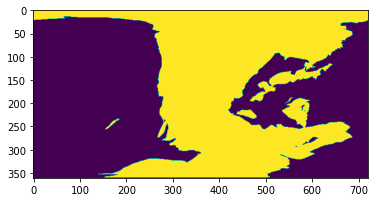

Working on Time 242.00Ma

Selected Time is in the stage 232.00Ma to 255.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_232Ma/m_fig34_248_224_PresentDay_Paleogeog_Matthews2016_232.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_255Ma/m_fig32_269_248_PresentDay_Paleogeog_Matthews2016_255.00Ma.shp']


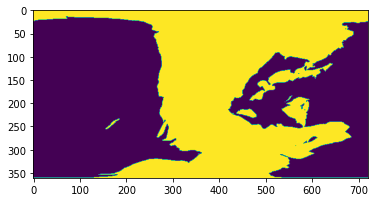

Working on Time 243.00Ma

Selected Time is in the stage 232.00Ma to 255.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_232Ma/m_fig34_248_224_PresentDay_Paleogeog_Matthews2016_232.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_255Ma/m_fig32_269_248_PresentDay_Paleogeog_Matthews2016_255.00Ma.shp']


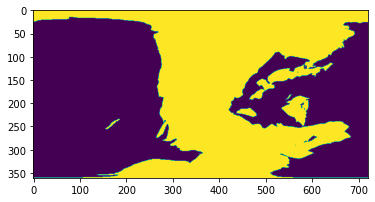

Working on Time 244.00Ma

Selected Time is in the stage 232.00Ma to 255.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_232Ma/m_fig34_248_224_PresentDay_Paleogeog_Matthews2016_232.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_255Ma/m_fig32_269_248_PresentDay_Paleogeog_Matthews2016_255.00Ma.shp']


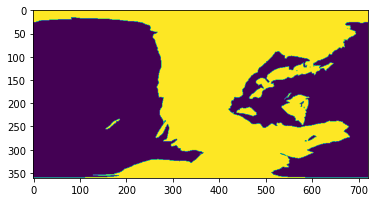

Working on Time 245.00Ma

Selected Time is in the stage 232.00Ma to 255.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_232Ma/m_fig34_248_224_PresentDay_Paleogeog_Matthews2016_232.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_255Ma/m_fig32_269_248_PresentDay_Paleogeog_Matthews2016_255.00Ma.shp']


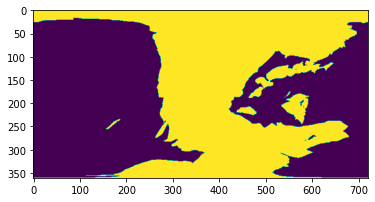

Working on Time 246.00Ma

Selected Time is in the stage 232.00Ma to 255.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_232Ma/m_fig34_248_224_PresentDay_Paleogeog_Matthews2016_232.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_255Ma/m_fig32_269_248_PresentDay_Paleogeog_Matthews2016_255.00Ma.shp']


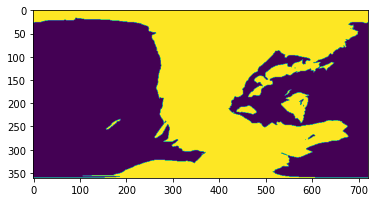

Working on Time 247.00Ma

Selected Time is in the stage 232.00Ma to 255.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_232Ma/m_fig34_248_224_PresentDay_Paleogeog_Matthews2016_232.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_255Ma/m_fig32_269_248_PresentDay_Paleogeog_Matthews2016_255.00Ma.shp']


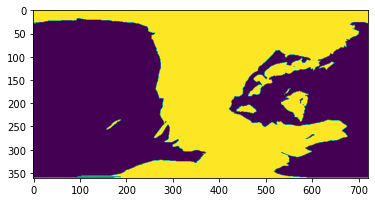

Working on Time 248.00Ma

Selected Time is in the stage 232.00Ma to 255.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_232Ma/m_fig34_248_224_PresentDay_Paleogeog_Matthews2016_232.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_255Ma/m_fig32_269_248_PresentDay_Paleogeog_Matthews2016_255.00Ma.shp']


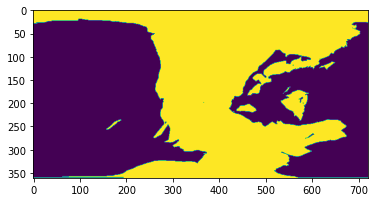

Working on Time 249.00Ma

Selected Time is in the stage 232.00Ma to 255.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_232Ma/m_fig34_248_224_PresentDay_Paleogeog_Matthews2016_232.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_255Ma/m_fig32_269_248_PresentDay_Paleogeog_Matthews2016_255.00Ma.shp']


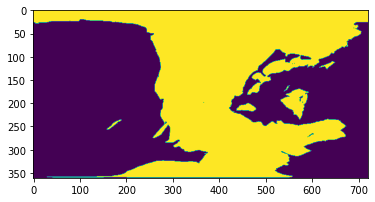

Working on Time 250.00Ma

Selected Time is in the stage 232.00Ma to 255.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_232Ma/m_fig34_248_224_PresentDay_Paleogeog_Matthews2016_232.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_255Ma/m_fig32_269_248_PresentDay_Paleogeog_Matthews2016_255.00Ma.shp']


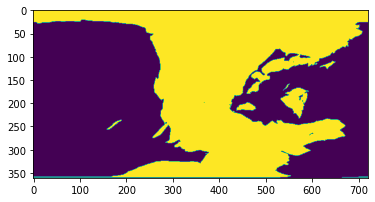

Working on Time 251.00Ma

Selected Time is in the stage 232.00Ma to 255.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_232Ma/m_fig34_248_224_PresentDay_Paleogeog_Matthews2016_232.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_255Ma/m_fig32_269_248_PresentDay_Paleogeog_Matthews2016_255.00Ma.shp']


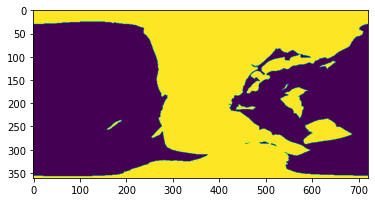

Working on Time 252.00Ma

Selected Time is in the stage 232.00Ma to 255.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_232Ma/m_fig34_248_224_PresentDay_Paleogeog_Matthews2016_232.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_255Ma/m_fig32_269_248_PresentDay_Paleogeog_Matthews2016_255.00Ma.shp']


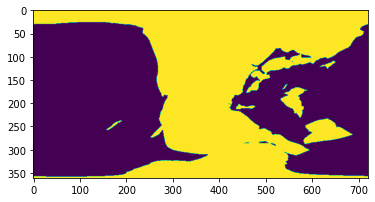

Working on Time 253.00Ma

Selected Time is in the stage 232.00Ma to 255.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_232Ma/m_fig34_248_224_PresentDay_Paleogeog_Matthews2016_232.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_255Ma/m_fig32_269_248_PresentDay_Paleogeog_Matthews2016_255.00Ma.shp']


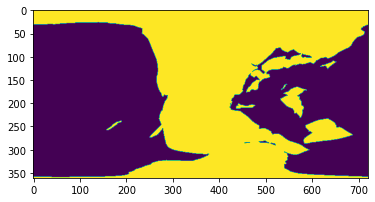

Working on Time 254.00Ma

Selected Time is in the stage 232.00Ma to 255.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_232Ma/m_fig34_248_224_PresentDay_Paleogeog_Matthews2016_232.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_255Ma/m_fig32_269_248_PresentDay_Paleogeog_Matthews2016_255.00Ma.shp']


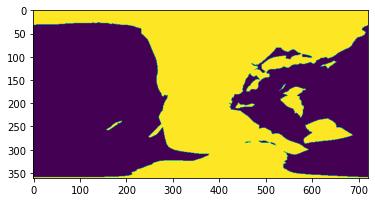

Working on Time 255.00Ma

Selected Time is in the stage 255.00Ma to 277.00Ma
Temporary fix for valid time
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_255Ma/m_fig32_269_248_PresentDay_Paleogeog_Matthews2016_255.00Ma.shp']


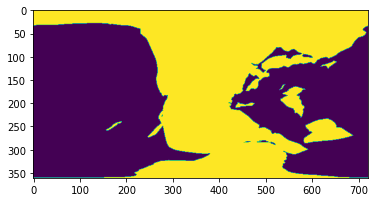

Working on Time 256.00Ma

Selected Time is in the stage 255.00Ma to 277.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_255Ma/m_fig32_269_248_PresentDay_Paleogeog_Matthews2016_255.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_277Ma/m_fig30_285_269_PresentDay_Paleogeog_Matthews2016_277.00Ma.shp']


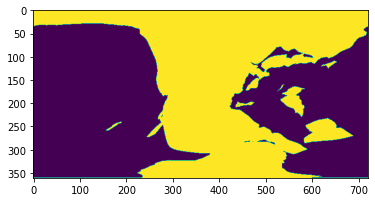

Working on Time 257.00Ma

Selected Time is in the stage 255.00Ma to 277.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_255Ma/m_fig32_269_248_PresentDay_Paleogeog_Matthews2016_255.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_277Ma/m_fig30_285_269_PresentDay_Paleogeog_Matthews2016_277.00Ma.shp']


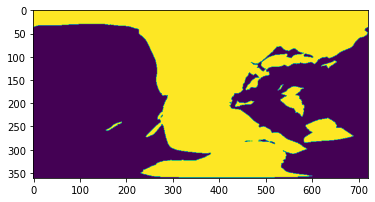

Working on Time 258.00Ma

Selected Time is in the stage 255.00Ma to 277.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_255Ma/m_fig32_269_248_PresentDay_Paleogeog_Matthews2016_255.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_277Ma/m_fig30_285_269_PresentDay_Paleogeog_Matthews2016_277.00Ma.shp']


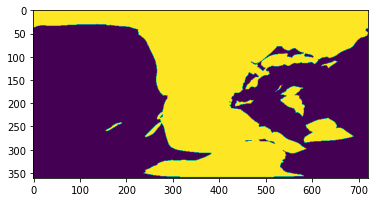

Working on Time 259.00Ma

Selected Time is in the stage 255.00Ma to 277.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_255Ma/m_fig32_269_248_PresentDay_Paleogeog_Matthews2016_255.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_277Ma/m_fig30_285_269_PresentDay_Paleogeog_Matthews2016_277.00Ma.shp']


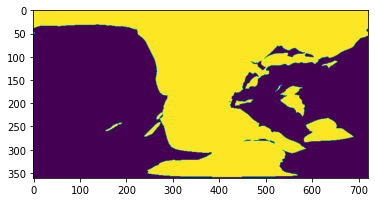

Working on Time 260.00Ma

Selected Time is in the stage 255.00Ma to 277.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_255Ma/m_fig32_269_248_PresentDay_Paleogeog_Matthews2016_255.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_277Ma/m_fig30_285_269_PresentDay_Paleogeog_Matthews2016_277.00Ma.shp']


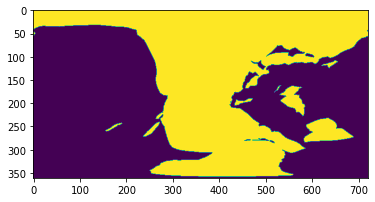

Working on Time 261.00Ma

Selected Time is in the stage 255.00Ma to 277.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_255Ma/m_fig32_269_248_PresentDay_Paleogeog_Matthews2016_255.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_277Ma/m_fig30_285_269_PresentDay_Paleogeog_Matthews2016_277.00Ma.shp']


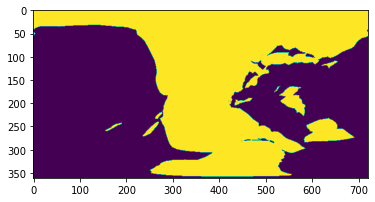

Working on Time 262.00Ma

Selected Time is in the stage 255.00Ma to 277.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_255Ma/m_fig32_269_248_PresentDay_Paleogeog_Matthews2016_255.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_277Ma/m_fig30_285_269_PresentDay_Paleogeog_Matthews2016_277.00Ma.shp']


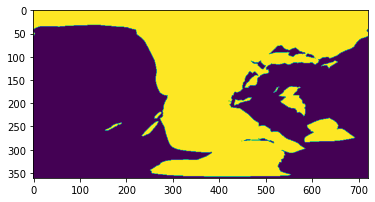

Working on Time 263.00Ma

Selected Time is in the stage 255.00Ma to 277.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_255Ma/m_fig32_269_248_PresentDay_Paleogeog_Matthews2016_255.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_277Ma/m_fig30_285_269_PresentDay_Paleogeog_Matthews2016_277.00Ma.shp']


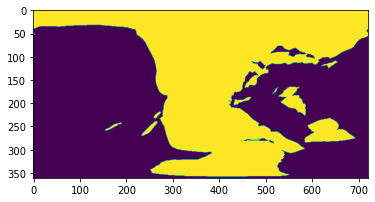

Working on Time 264.00Ma

Selected Time is in the stage 255.00Ma to 277.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_255Ma/m_fig32_269_248_PresentDay_Paleogeog_Matthews2016_255.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_277Ma/m_fig30_285_269_PresentDay_Paleogeog_Matthews2016_277.00Ma.shp']


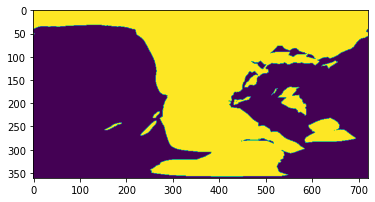

Working on Time 265.00Ma

Selected Time is in the stage 255.00Ma to 277.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_255Ma/m_fig32_269_248_PresentDay_Paleogeog_Matthews2016_255.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_277Ma/m_fig30_285_269_PresentDay_Paleogeog_Matthews2016_277.00Ma.shp']


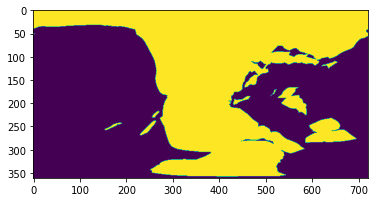

Working on Time 266.00Ma

Selected Time is in the stage 255.00Ma to 277.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_255Ma/m_fig32_269_248_PresentDay_Paleogeog_Matthews2016_255.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_277Ma/m_fig30_285_269_PresentDay_Paleogeog_Matthews2016_277.00Ma.shp']


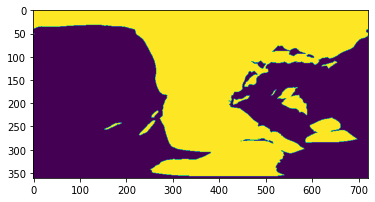

Working on Time 267.00Ma

Selected Time is in the stage 255.00Ma to 277.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_255Ma/m_fig32_269_248_PresentDay_Paleogeog_Matthews2016_255.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_277Ma/m_fig30_285_269_PresentDay_Paleogeog_Matthews2016_277.00Ma.shp']


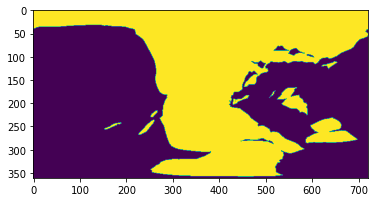

Working on Time 268.00Ma

Selected Time is in the stage 255.00Ma to 277.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_255Ma/m_fig32_269_248_PresentDay_Paleogeog_Matthews2016_255.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_277Ma/m_fig30_285_269_PresentDay_Paleogeog_Matthews2016_277.00Ma.shp']


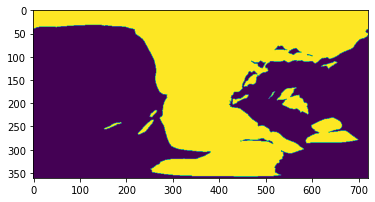

Working on Time 269.00Ma

Selected Time is in the stage 255.00Ma to 277.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_255Ma/m_fig32_269_248_PresentDay_Paleogeog_Matthews2016_255.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_277Ma/m_fig30_285_269_PresentDay_Paleogeog_Matthews2016_277.00Ma.shp']


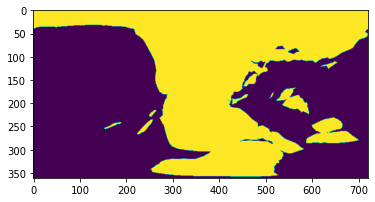

Working on Time 270.00Ma

Selected Time is in the stage 255.00Ma to 277.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_255Ma/m_fig32_269_248_PresentDay_Paleogeog_Matthews2016_255.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_277Ma/m_fig30_285_269_PresentDay_Paleogeog_Matthews2016_277.00Ma.shp']


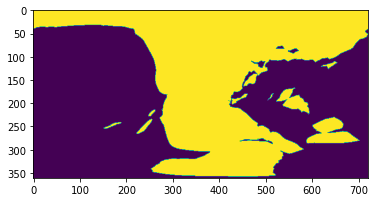

Working on Time 271.00Ma

Selected Time is in the stage 255.00Ma to 277.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_255Ma/m_fig32_269_248_PresentDay_Paleogeog_Matthews2016_255.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_277Ma/m_fig30_285_269_PresentDay_Paleogeog_Matthews2016_277.00Ma.shp']


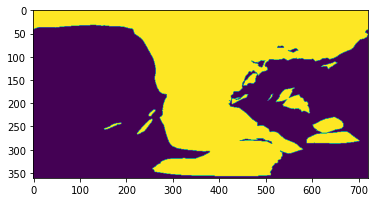

Working on Time 272.00Ma

Selected Time is in the stage 255.00Ma to 277.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_255Ma/m_fig32_269_248_PresentDay_Paleogeog_Matthews2016_255.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_277Ma/m_fig30_285_269_PresentDay_Paleogeog_Matthews2016_277.00Ma.shp']


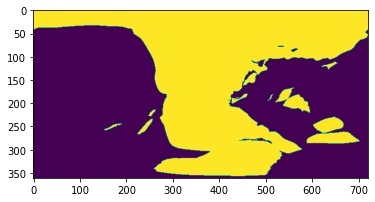

Working on Time 273.00Ma

Selected Time is in the stage 255.00Ma to 277.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_255Ma/m_fig32_269_248_PresentDay_Paleogeog_Matthews2016_255.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_277Ma/m_fig30_285_269_PresentDay_Paleogeog_Matthews2016_277.00Ma.shp']


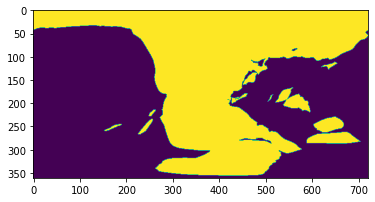

Working on Time 274.00Ma

Selected Time is in the stage 255.00Ma to 277.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_255Ma/m_fig32_269_248_PresentDay_Paleogeog_Matthews2016_255.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_277Ma/m_fig30_285_269_PresentDay_Paleogeog_Matthews2016_277.00Ma.shp']


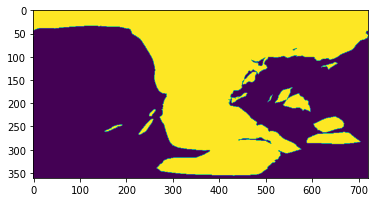

Working on Time 275.00Ma

Selected Time is in the stage 255.00Ma to 277.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_255Ma/m_fig32_269_248_PresentDay_Paleogeog_Matthews2016_255.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_277Ma/m_fig30_285_269_PresentDay_Paleogeog_Matthews2016_277.00Ma.shp']


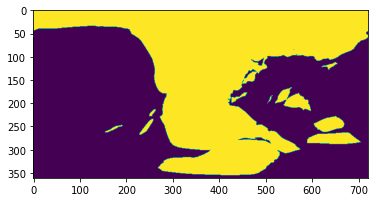

Working on Time 276.00Ma

Selected Time is in the stage 255.00Ma to 277.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_255Ma/m_fig32_269_248_PresentDay_Paleogeog_Matthews2016_255.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_277Ma/m_fig30_285_269_PresentDay_Paleogeog_Matthews2016_277.00Ma.shp']


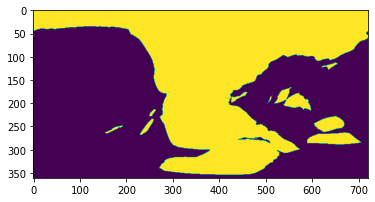

Working on Time 277.00Ma

Selected Time is in the stage 277.00Ma to 287.00Ma
Temporary fix for valid time
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_277Ma/m_fig30_285_269_PresentDay_Paleogeog_Matthews2016_277.00Ma.shp']


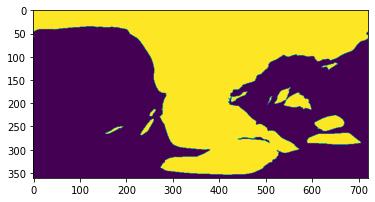

Working on Time 278.00Ma

Selected Time is in the stage 277.00Ma to 287.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_277Ma/m_fig30_285_269_PresentDay_Paleogeog_Matthews2016_277.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_287Ma/m_fig28_296_285_PresentDay_Paleogeog_Matthews2016_287.00Ma.shp']


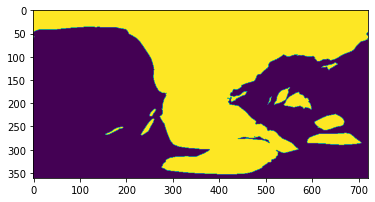

Working on Time 279.00Ma

Selected Time is in the stage 277.00Ma to 287.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_277Ma/m_fig30_285_269_PresentDay_Paleogeog_Matthews2016_277.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_287Ma/m_fig28_296_285_PresentDay_Paleogeog_Matthews2016_287.00Ma.shp']


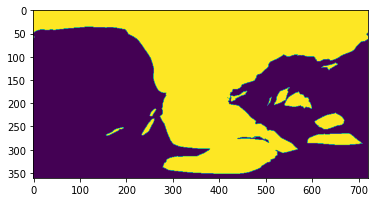

Working on Time 280.00Ma

Selected Time is in the stage 277.00Ma to 287.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_277Ma/m_fig30_285_269_PresentDay_Paleogeog_Matthews2016_277.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_287Ma/m_fig28_296_285_PresentDay_Paleogeog_Matthews2016_287.00Ma.shp']


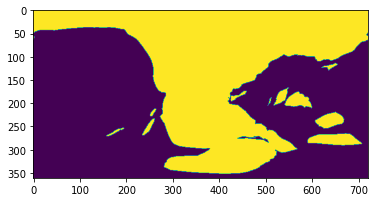

Working on Time 281.00Ma

Selected Time is in the stage 277.00Ma to 287.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_277Ma/m_fig30_285_269_PresentDay_Paleogeog_Matthews2016_277.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_287Ma/m_fig28_296_285_PresentDay_Paleogeog_Matthews2016_287.00Ma.shp']


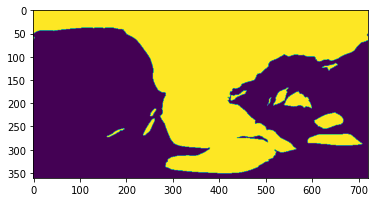

Working on Time 282.00Ma

Selected Time is in the stage 277.00Ma to 287.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_277Ma/m_fig30_285_269_PresentDay_Paleogeog_Matthews2016_277.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_287Ma/m_fig28_296_285_PresentDay_Paleogeog_Matthews2016_287.00Ma.shp']


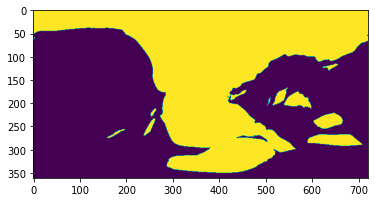

Working on Time 283.00Ma

Selected Time is in the stage 277.00Ma to 287.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_277Ma/m_fig30_285_269_PresentDay_Paleogeog_Matthews2016_277.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_287Ma/m_fig28_296_285_PresentDay_Paleogeog_Matthews2016_287.00Ma.shp']


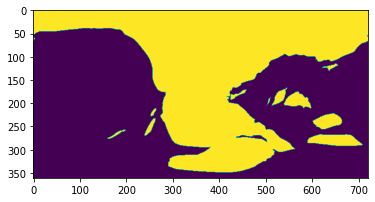

Working on Time 284.00Ma

Selected Time is in the stage 277.00Ma to 287.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_277Ma/m_fig30_285_269_PresentDay_Paleogeog_Matthews2016_277.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_287Ma/m_fig28_296_285_PresentDay_Paleogeog_Matthews2016_287.00Ma.shp']


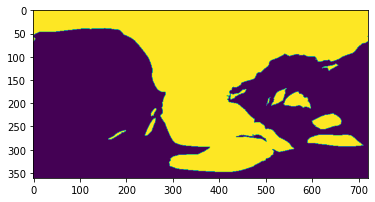

Working on Time 285.00Ma

Selected Time is in the stage 277.00Ma to 287.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_277Ma/m_fig30_285_269_PresentDay_Paleogeog_Matthews2016_277.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_287Ma/m_fig28_296_285_PresentDay_Paleogeog_Matthews2016_287.00Ma.shp']


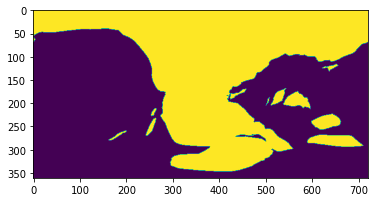

Working on Time 286.00Ma

Selected Time is in the stage 277.00Ma to 287.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_277Ma/m_fig30_285_269_PresentDay_Paleogeog_Matthews2016_277.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_287Ma/m_fig28_296_285_PresentDay_Paleogeog_Matthews2016_287.00Ma.shp']


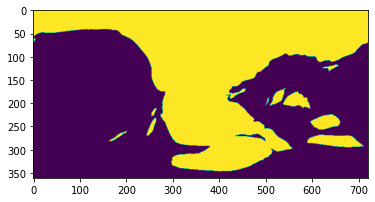

Working on Time 287.00Ma

Selected Time is in the stage 287.00Ma to 302.00Ma
Temporary fix for valid time
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_287Ma/m_fig28_296_285_PresentDay_Paleogeog_Matthews2016_287.00Ma.shp']


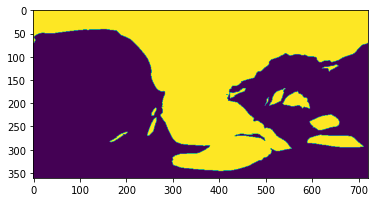

Working on Time 288.00Ma

Selected Time is in the stage 287.00Ma to 302.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_287Ma/m_fig28_296_285_PresentDay_Paleogeog_Matthews2016_287.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_302Ma/m_fig26_323_296_PresentDay_Paleogeog_Matthews2016_302.00Ma.shp']


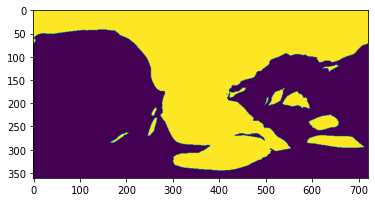

Working on Time 289.00Ma

Selected Time is in the stage 287.00Ma to 302.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_287Ma/m_fig28_296_285_PresentDay_Paleogeog_Matthews2016_287.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_302Ma/m_fig26_323_296_PresentDay_Paleogeog_Matthews2016_302.00Ma.shp']


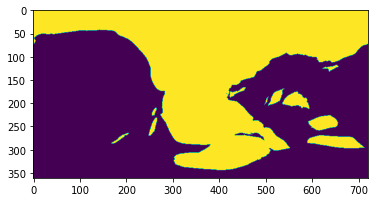

Working on Time 290.00Ma

Selected Time is in the stage 287.00Ma to 302.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_287Ma/m_fig28_296_285_PresentDay_Paleogeog_Matthews2016_287.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_302Ma/m_fig26_323_296_PresentDay_Paleogeog_Matthews2016_302.00Ma.shp']


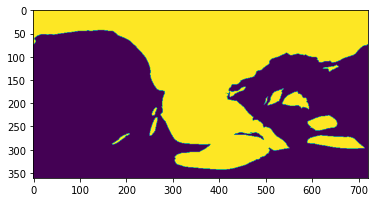

Working on Time 291.00Ma

Selected Time is in the stage 287.00Ma to 302.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_287Ma/m_fig28_296_285_PresentDay_Paleogeog_Matthews2016_287.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_302Ma/m_fig26_323_296_PresentDay_Paleogeog_Matthews2016_302.00Ma.shp']


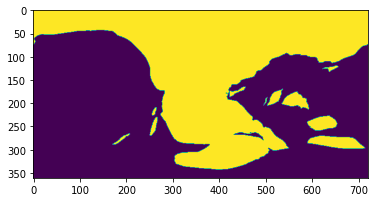

Working on Time 292.00Ma

Selected Time is in the stage 287.00Ma to 302.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_287Ma/m_fig28_296_285_PresentDay_Paleogeog_Matthews2016_287.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_302Ma/m_fig26_323_296_PresentDay_Paleogeog_Matthews2016_302.00Ma.shp']


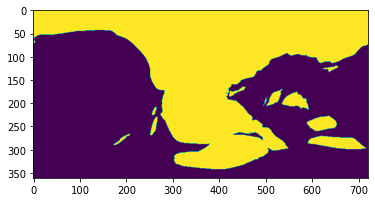

Working on Time 293.00Ma

Selected Time is in the stage 287.00Ma to 302.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_287Ma/m_fig28_296_285_PresentDay_Paleogeog_Matthews2016_287.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_302Ma/m_fig26_323_296_PresentDay_Paleogeog_Matthews2016_302.00Ma.shp']


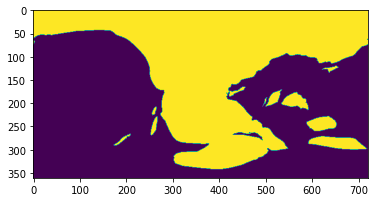

Working on Time 294.00Ma

Selected Time is in the stage 287.00Ma to 302.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_287Ma/m_fig28_296_285_PresentDay_Paleogeog_Matthews2016_287.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_302Ma/m_fig26_323_296_PresentDay_Paleogeog_Matthews2016_302.00Ma.shp']


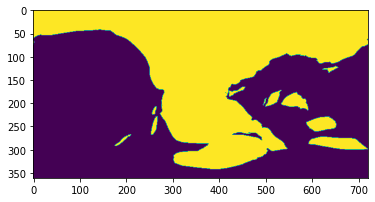

Working on Time 295.00Ma

Selected Time is in the stage 287.00Ma to 302.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_287Ma/m_fig28_296_285_PresentDay_Paleogeog_Matthews2016_287.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_302Ma/m_fig26_323_296_PresentDay_Paleogeog_Matthews2016_302.00Ma.shp']


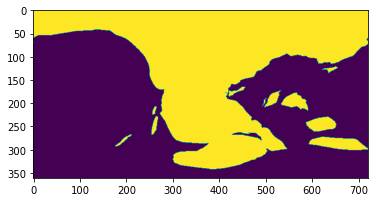

Working on Time 296.00Ma

Selected Time is in the stage 287.00Ma to 302.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_287Ma/m_fig28_296_285_PresentDay_Paleogeog_Matthews2016_287.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_302Ma/m_fig26_323_296_PresentDay_Paleogeog_Matthews2016_302.00Ma.shp']


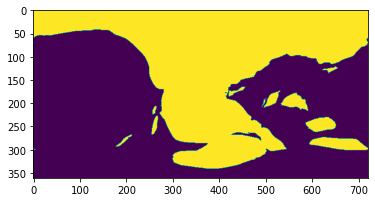

Working on Time 297.00Ma

Selected Time is in the stage 287.00Ma to 302.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_287Ma/m_fig28_296_285_PresentDay_Paleogeog_Matthews2016_287.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_302Ma/m_fig26_323_296_PresentDay_Paleogeog_Matthews2016_302.00Ma.shp']


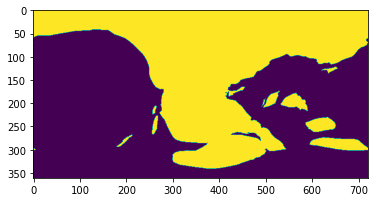

Working on Time 298.00Ma

Selected Time is in the stage 287.00Ma to 302.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_287Ma/m_fig28_296_285_PresentDay_Paleogeog_Matthews2016_287.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_302Ma/m_fig26_323_296_PresentDay_Paleogeog_Matthews2016_302.00Ma.shp']


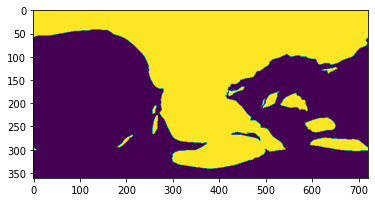

Working on Time 299.00Ma

Selected Time is in the stage 287.00Ma to 302.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_287Ma/m_fig28_296_285_PresentDay_Paleogeog_Matthews2016_287.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_302Ma/m_fig26_323_296_PresentDay_Paleogeog_Matthews2016_302.00Ma.shp']


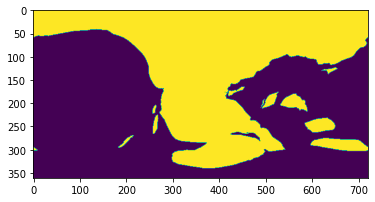

Working on Time 300.00Ma

Selected Time is in the stage 287.00Ma to 302.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_287Ma/m_fig28_296_285_PresentDay_Paleogeog_Matthews2016_287.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_302Ma/m_fig26_323_296_PresentDay_Paleogeog_Matthews2016_302.00Ma.shp']


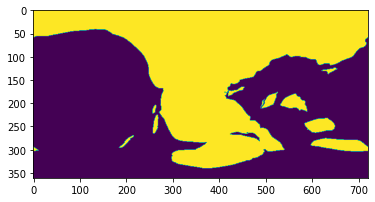

Working on Time 301.00Ma

Selected Time is in the stage 287.00Ma to 302.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_287Ma/m_fig28_296_285_PresentDay_Paleogeog_Matthews2016_287.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_302Ma/m_fig26_323_296_PresentDay_Paleogeog_Matthews2016_302.00Ma.shp']


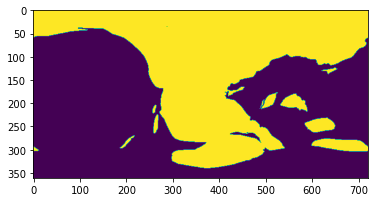

Working on Time 302.00Ma

Selected Time is in the stage 302.00Ma to 328.00Ma
Temporary fix for valid time
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_302Ma/m_fig26_323_296_PresentDay_Paleogeog_Matthews2016_302.00Ma.shp']


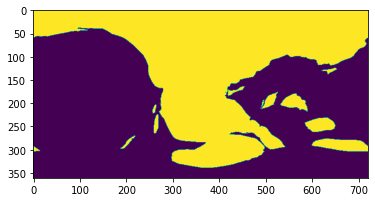

Working on Time 303.00Ma

Selected Time is in the stage 302.00Ma to 328.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_302Ma/m_fig26_323_296_PresentDay_Paleogeog_Matthews2016_302.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_328Ma/m_fig24_338_323_PresentDay_Paleogeog_Matthews2016_328.00Ma.shp']


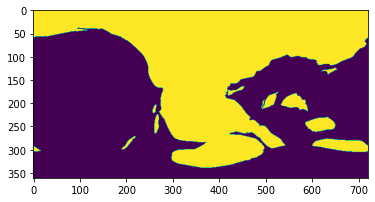

Working on Time 304.00Ma

Selected Time is in the stage 302.00Ma to 328.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_302Ma/m_fig26_323_296_PresentDay_Paleogeog_Matthews2016_302.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_328Ma/m_fig24_338_323_PresentDay_Paleogeog_Matthews2016_328.00Ma.shp']


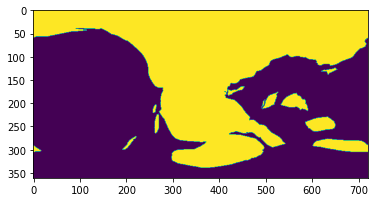

Working on Time 305.00Ma

Selected Time is in the stage 302.00Ma to 328.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_302Ma/m_fig26_323_296_PresentDay_Paleogeog_Matthews2016_302.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_328Ma/m_fig24_338_323_PresentDay_Paleogeog_Matthews2016_328.00Ma.shp']


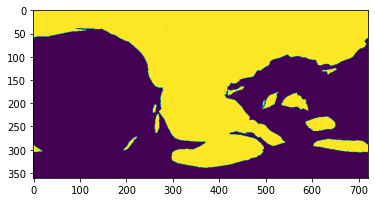

Working on Time 306.00Ma

Selected Time is in the stage 302.00Ma to 328.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_302Ma/m_fig26_323_296_PresentDay_Paleogeog_Matthews2016_302.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_328Ma/m_fig24_338_323_PresentDay_Paleogeog_Matthews2016_328.00Ma.shp']


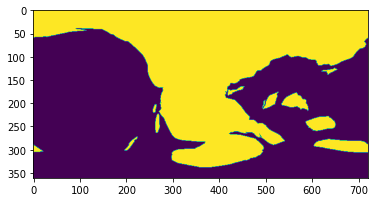

Working on Time 307.00Ma

Selected Time is in the stage 302.00Ma to 328.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_302Ma/m_fig26_323_296_PresentDay_Paleogeog_Matthews2016_302.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_328Ma/m_fig24_338_323_PresentDay_Paleogeog_Matthews2016_328.00Ma.shp']


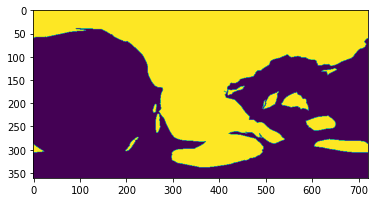

Working on Time 308.00Ma

Selected Time is in the stage 302.00Ma to 328.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_302Ma/m_fig26_323_296_PresentDay_Paleogeog_Matthews2016_302.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_328Ma/m_fig24_338_323_PresentDay_Paleogeog_Matthews2016_328.00Ma.shp']


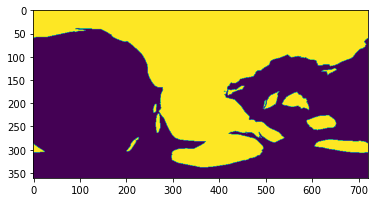

Working on Time 309.00Ma

Selected Time is in the stage 302.00Ma to 328.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_302Ma/m_fig26_323_296_PresentDay_Paleogeog_Matthews2016_302.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_328Ma/m_fig24_338_323_PresentDay_Paleogeog_Matthews2016_328.00Ma.shp']


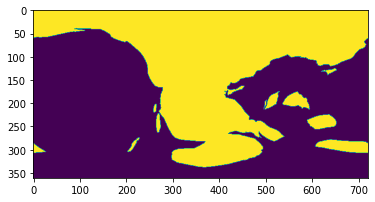

Working on Time 310.00Ma

Selected Time is in the stage 302.00Ma to 328.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_302Ma/m_fig26_323_296_PresentDay_Paleogeog_Matthews2016_302.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_328Ma/m_fig24_338_323_PresentDay_Paleogeog_Matthews2016_328.00Ma.shp']


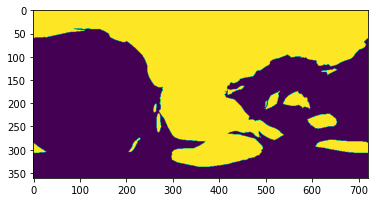

Working on Time 311.00Ma

Selected Time is in the stage 302.00Ma to 328.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_302Ma/m_fig26_323_296_PresentDay_Paleogeog_Matthews2016_302.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_328Ma/m_fig24_338_323_PresentDay_Paleogeog_Matthews2016_328.00Ma.shp']


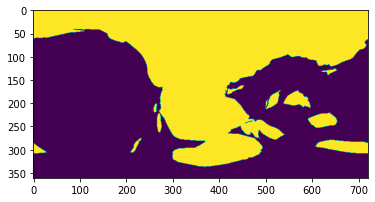

Working on Time 312.00Ma

Selected Time is in the stage 302.00Ma to 328.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_302Ma/m_fig26_323_296_PresentDay_Paleogeog_Matthews2016_302.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_328Ma/m_fig24_338_323_PresentDay_Paleogeog_Matthews2016_328.00Ma.shp']


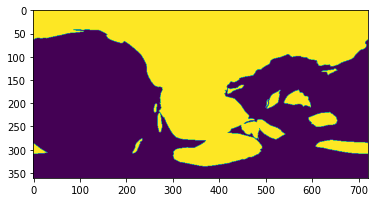

Working on Time 313.00Ma

Selected Time is in the stage 302.00Ma to 328.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_302Ma/m_fig26_323_296_PresentDay_Paleogeog_Matthews2016_302.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_328Ma/m_fig24_338_323_PresentDay_Paleogeog_Matthews2016_328.00Ma.shp']


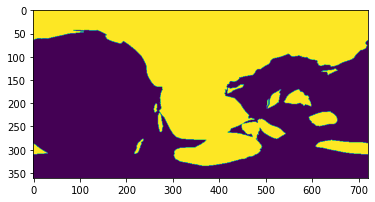

Working on Time 314.00Ma

Selected Time is in the stage 302.00Ma to 328.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_302Ma/m_fig26_323_296_PresentDay_Paleogeog_Matthews2016_302.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_328Ma/m_fig24_338_323_PresentDay_Paleogeog_Matthews2016_328.00Ma.shp']


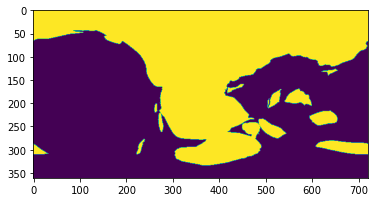

Working on Time 315.00Ma

Selected Time is in the stage 302.00Ma to 328.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_302Ma/m_fig26_323_296_PresentDay_Paleogeog_Matthews2016_302.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_328Ma/m_fig24_338_323_PresentDay_Paleogeog_Matthews2016_328.00Ma.shp']


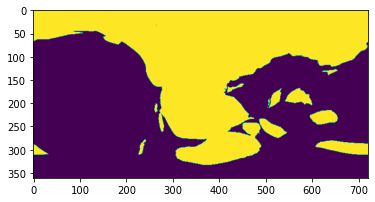

Working on Time 316.00Ma

Selected Time is in the stage 302.00Ma to 328.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_302Ma/m_fig26_323_296_PresentDay_Paleogeog_Matthews2016_302.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_328Ma/m_fig24_338_323_PresentDay_Paleogeog_Matthews2016_328.00Ma.shp']


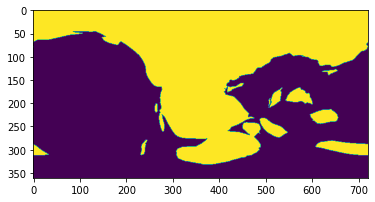

Working on Time 317.00Ma

Selected Time is in the stage 302.00Ma to 328.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_302Ma/m_fig26_323_296_PresentDay_Paleogeog_Matthews2016_302.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_328Ma/m_fig24_338_323_PresentDay_Paleogeog_Matthews2016_328.00Ma.shp']


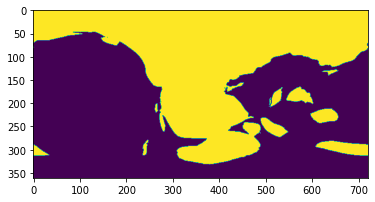

Working on Time 318.00Ma

Selected Time is in the stage 302.00Ma to 328.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_302Ma/m_fig26_323_296_PresentDay_Paleogeog_Matthews2016_302.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_328Ma/m_fig24_338_323_PresentDay_Paleogeog_Matthews2016_328.00Ma.shp']


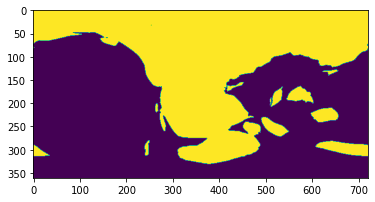

Working on Time 319.00Ma

Selected Time is in the stage 302.00Ma to 328.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_302Ma/m_fig26_323_296_PresentDay_Paleogeog_Matthews2016_302.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_328Ma/m_fig24_338_323_PresentDay_Paleogeog_Matthews2016_328.00Ma.shp']


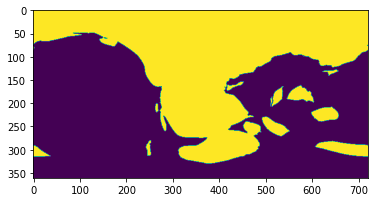

Working on Time 320.00Ma

Selected Time is in the stage 302.00Ma to 328.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_302Ma/m_fig26_323_296_PresentDay_Paleogeog_Matthews2016_302.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_328Ma/m_fig24_338_323_PresentDay_Paleogeog_Matthews2016_328.00Ma.shp']


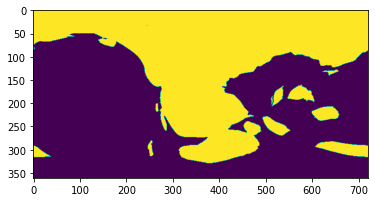

Working on Time 321.00Ma

Selected Time is in the stage 302.00Ma to 328.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_302Ma/m_fig26_323_296_PresentDay_Paleogeog_Matthews2016_302.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_328Ma/m_fig24_338_323_PresentDay_Paleogeog_Matthews2016_328.00Ma.shp']


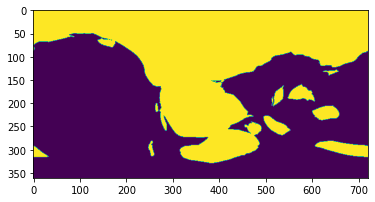

Working on Time 322.00Ma

Selected Time is in the stage 302.00Ma to 328.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_302Ma/m_fig26_323_296_PresentDay_Paleogeog_Matthews2016_302.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_328Ma/m_fig24_338_323_PresentDay_Paleogeog_Matthews2016_328.00Ma.shp']


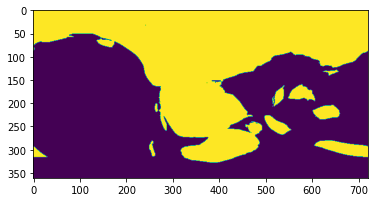

Working on Time 323.00Ma

Selected Time is in the stage 302.00Ma to 328.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_302Ma/m_fig26_323_296_PresentDay_Paleogeog_Matthews2016_302.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_328Ma/m_fig24_338_323_PresentDay_Paleogeog_Matthews2016_328.00Ma.shp']


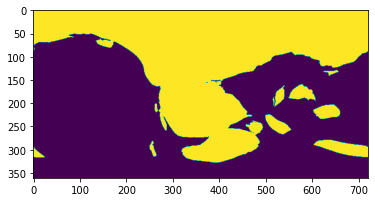

Working on Time 324.00Ma

Selected Time is in the stage 302.00Ma to 328.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_302Ma/m_fig26_323_296_PresentDay_Paleogeog_Matthews2016_302.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_328Ma/m_fig24_338_323_PresentDay_Paleogeog_Matthews2016_328.00Ma.shp']


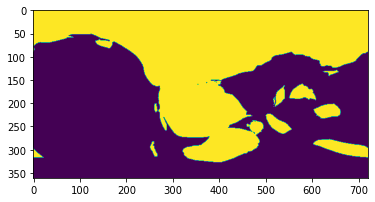

Working on Time 325.00Ma

Selected Time is in the stage 302.00Ma to 328.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_302Ma/m_fig26_323_296_PresentDay_Paleogeog_Matthews2016_302.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_328Ma/m_fig24_338_323_PresentDay_Paleogeog_Matthews2016_328.00Ma.shp']


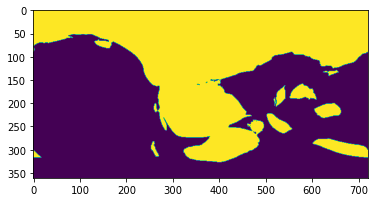

Working on Time 326.00Ma

Selected Time is in the stage 302.00Ma to 328.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_302Ma/m_fig26_323_296_PresentDay_Paleogeog_Matthews2016_302.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_328Ma/m_fig24_338_323_PresentDay_Paleogeog_Matthews2016_328.00Ma.shp']


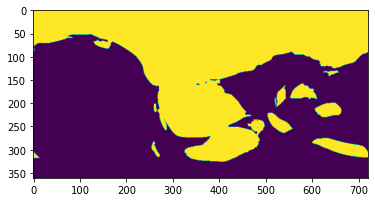

Working on Time 327.00Ma

Selected Time is in the stage 302.00Ma to 328.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_302Ma/m_fig26_323_296_PresentDay_Paleogeog_Matthews2016_302.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_328Ma/m_fig24_338_323_PresentDay_Paleogeog_Matthews2016_328.00Ma.shp']


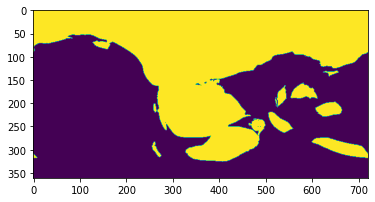

Working on Time 328.00Ma

Selected Time is in the stage 328.00Ma to 348.00Ma
Temporary fix for valid time
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_328Ma/m_fig24_338_323_PresentDay_Paleogeog_Matthews2016_328.00Ma.shp']


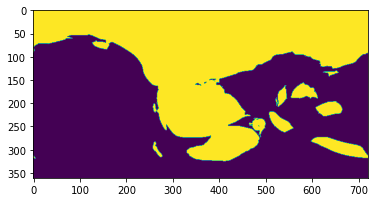

Working on Time 329.00Ma

Selected Time is in the stage 328.00Ma to 348.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_328Ma/m_fig24_338_323_PresentDay_Paleogeog_Matthews2016_328.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_348Ma/m_fig22_359_338_PresentDay_Paleogeog_Matthews2016_348.00Ma.shp']


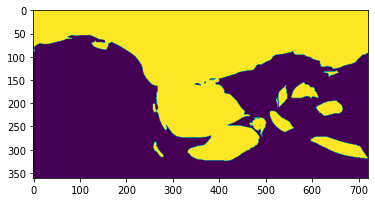

Working on Time 330.00Ma

Selected Time is in the stage 328.00Ma to 348.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_328Ma/m_fig24_338_323_PresentDay_Paleogeog_Matthews2016_328.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_348Ma/m_fig22_359_338_PresentDay_Paleogeog_Matthews2016_348.00Ma.shp']


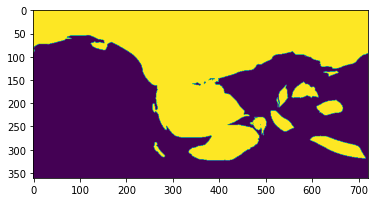

Working on Time 331.00Ma

Selected Time is in the stage 328.00Ma to 348.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_328Ma/m_fig24_338_323_PresentDay_Paleogeog_Matthews2016_328.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_348Ma/m_fig22_359_338_PresentDay_Paleogeog_Matthews2016_348.00Ma.shp']


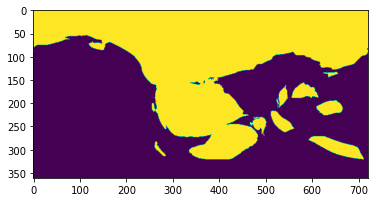

Working on Time 332.00Ma

Selected Time is in the stage 328.00Ma to 348.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_328Ma/m_fig24_338_323_PresentDay_Paleogeog_Matthews2016_328.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_348Ma/m_fig22_359_338_PresentDay_Paleogeog_Matthews2016_348.00Ma.shp']


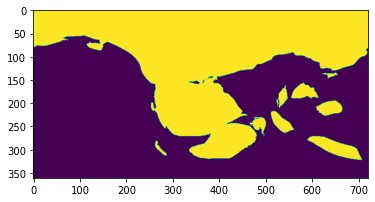

Working on Time 333.00Ma

Selected Time is in the stage 328.00Ma to 348.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_328Ma/m_fig24_338_323_PresentDay_Paleogeog_Matthews2016_328.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_348Ma/m_fig22_359_338_PresentDay_Paleogeog_Matthews2016_348.00Ma.shp']


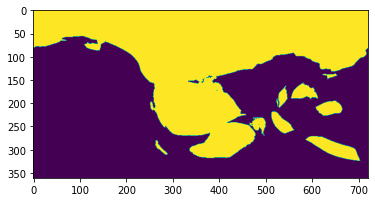

Working on Time 334.00Ma

Selected Time is in the stage 328.00Ma to 348.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_328Ma/m_fig24_338_323_PresentDay_Paleogeog_Matthews2016_328.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_348Ma/m_fig22_359_338_PresentDay_Paleogeog_Matthews2016_348.00Ma.shp']


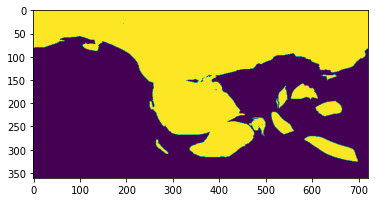

Working on Time 335.00Ma

Selected Time is in the stage 328.00Ma to 348.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_328Ma/m_fig24_338_323_PresentDay_Paleogeog_Matthews2016_328.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_348Ma/m_fig22_359_338_PresentDay_Paleogeog_Matthews2016_348.00Ma.shp']


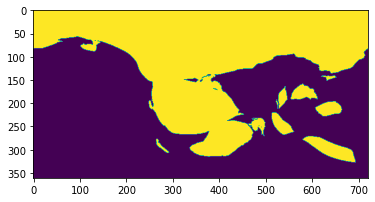

Working on Time 336.00Ma

Selected Time is in the stage 328.00Ma to 348.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_328Ma/m_fig24_338_323_PresentDay_Paleogeog_Matthews2016_328.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_348Ma/m_fig22_359_338_PresentDay_Paleogeog_Matthews2016_348.00Ma.shp']


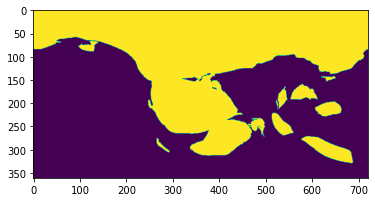

Working on Time 337.00Ma

Selected Time is in the stage 328.00Ma to 348.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_328Ma/m_fig24_338_323_PresentDay_Paleogeog_Matthews2016_328.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_348Ma/m_fig22_359_338_PresentDay_Paleogeog_Matthews2016_348.00Ma.shp']


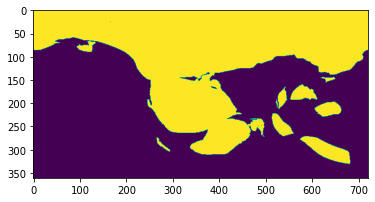

Working on Time 338.00Ma

Selected Time is in the stage 328.00Ma to 348.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_328Ma/m_fig24_338_323_PresentDay_Paleogeog_Matthews2016_328.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_348Ma/m_fig22_359_338_PresentDay_Paleogeog_Matthews2016_348.00Ma.shp']


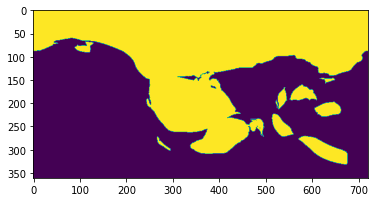

Working on Time 339.00Ma

Selected Time is in the stage 328.00Ma to 348.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_328Ma/m_fig24_338_323_PresentDay_Paleogeog_Matthews2016_328.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_348Ma/m_fig22_359_338_PresentDay_Paleogeog_Matthews2016_348.00Ma.shp']


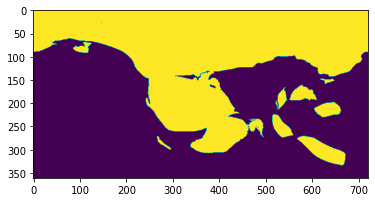

Working on Time 340.00Ma

Selected Time is in the stage 328.00Ma to 348.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_328Ma/m_fig24_338_323_PresentDay_Paleogeog_Matthews2016_328.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_348Ma/m_fig22_359_338_PresentDay_Paleogeog_Matthews2016_348.00Ma.shp']


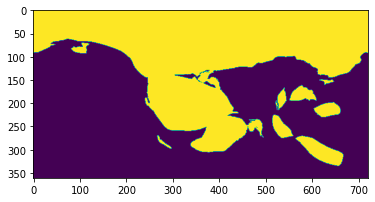

Working on Time 341.00Ma

Selected Time is in the stage 328.00Ma to 348.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_328Ma/m_fig24_338_323_PresentDay_Paleogeog_Matthews2016_328.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_348Ma/m_fig22_359_338_PresentDay_Paleogeog_Matthews2016_348.00Ma.shp']


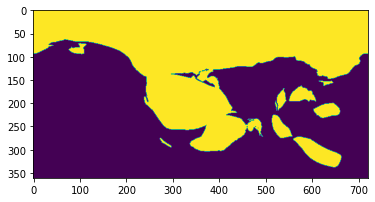

Working on Time 342.00Ma

Selected Time is in the stage 328.00Ma to 348.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_328Ma/m_fig24_338_323_PresentDay_Paleogeog_Matthews2016_328.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_348Ma/m_fig22_359_338_PresentDay_Paleogeog_Matthews2016_348.00Ma.shp']


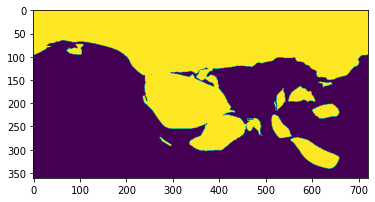

Working on Time 343.00Ma

Selected Time is in the stage 328.00Ma to 348.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_328Ma/m_fig24_338_323_PresentDay_Paleogeog_Matthews2016_328.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_348Ma/m_fig22_359_338_PresentDay_Paleogeog_Matthews2016_348.00Ma.shp']


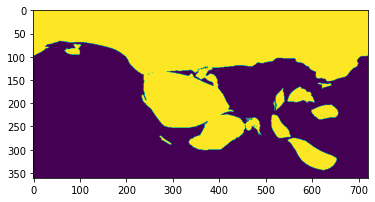

Working on Time 344.00Ma

Selected Time is in the stage 328.00Ma to 348.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_328Ma/m_fig24_338_323_PresentDay_Paleogeog_Matthews2016_328.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_348Ma/m_fig22_359_338_PresentDay_Paleogeog_Matthews2016_348.00Ma.shp']


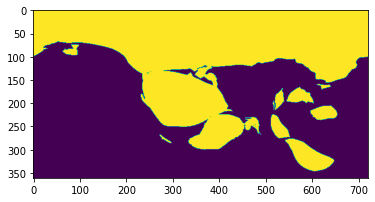

Working on Time 345.00Ma

Selected Time is in the stage 328.00Ma to 348.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_328Ma/m_fig24_338_323_PresentDay_Paleogeog_Matthews2016_328.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_348Ma/m_fig22_359_338_PresentDay_Paleogeog_Matthews2016_348.00Ma.shp']


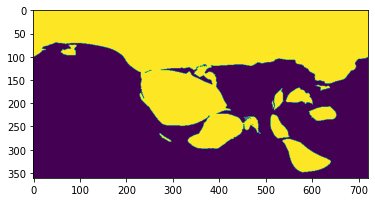

Working on Time 346.00Ma

Selected Time is in the stage 328.00Ma to 348.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_328Ma/m_fig24_338_323_PresentDay_Paleogeog_Matthews2016_328.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_348Ma/m_fig22_359_338_PresentDay_Paleogeog_Matthews2016_348.00Ma.shp']


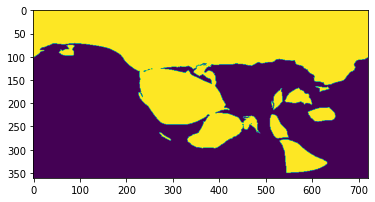

Working on Time 347.00Ma

Selected Time is in the stage 328.00Ma to 348.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_328Ma/m_fig24_338_323_PresentDay_Paleogeog_Matthews2016_328.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_348Ma/m_fig22_359_338_PresentDay_Paleogeog_Matthews2016_348.00Ma.shp']


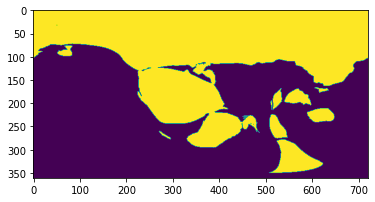

Working on Time 348.00Ma

Selected Time is in the stage 348.00Ma to 368.00Ma
Temporary fix for valid time
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_348Ma/m_fig22_359_338_PresentDay_Paleogeog_Matthews2016_348.00Ma.shp']


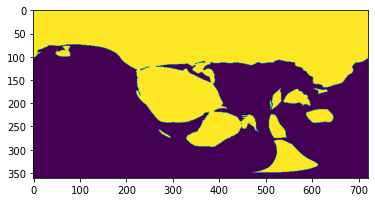

Working on Time 349.00Ma

Selected Time is in the stage 348.00Ma to 368.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_348Ma/m_fig22_359_338_PresentDay_Paleogeog_Matthews2016_348.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_368Ma/m_fig20_380_359_PresentDay_Paleogeog_Matthews2016_368.00Ma.shp']


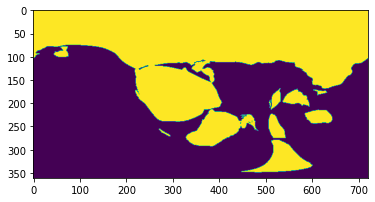

Working on Time 350.00Ma

Selected Time is in the stage 348.00Ma to 368.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_348Ma/m_fig22_359_338_PresentDay_Paleogeog_Matthews2016_348.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_368Ma/m_fig20_380_359_PresentDay_Paleogeog_Matthews2016_368.00Ma.shp']


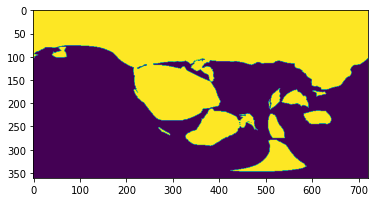

Working on Time 351.00Ma

Selected Time is in the stage 348.00Ma to 368.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_348Ma/m_fig22_359_338_PresentDay_Paleogeog_Matthews2016_348.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_368Ma/m_fig20_380_359_PresentDay_Paleogeog_Matthews2016_368.00Ma.shp']


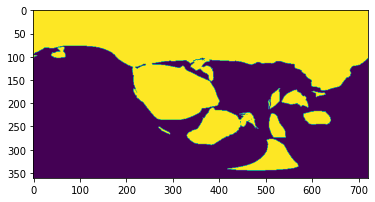

Working on Time 352.00Ma

Selected Time is in the stage 348.00Ma to 368.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_348Ma/m_fig22_359_338_PresentDay_Paleogeog_Matthews2016_348.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_368Ma/m_fig20_380_359_PresentDay_Paleogeog_Matthews2016_368.00Ma.shp']


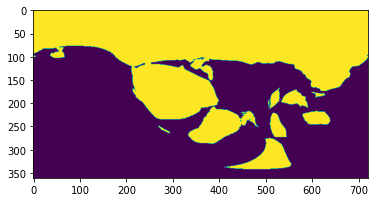

Working on Time 353.00Ma

Selected Time is in the stage 348.00Ma to 368.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_348Ma/m_fig22_359_338_PresentDay_Paleogeog_Matthews2016_348.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_368Ma/m_fig20_380_359_PresentDay_Paleogeog_Matthews2016_368.00Ma.shp']


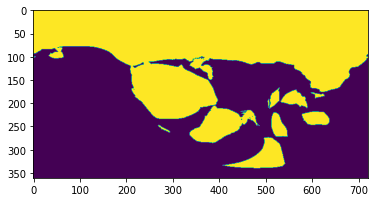

Working on Time 354.00Ma

Selected Time is in the stage 348.00Ma to 368.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_348Ma/m_fig22_359_338_PresentDay_Paleogeog_Matthews2016_348.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_368Ma/m_fig20_380_359_PresentDay_Paleogeog_Matthews2016_368.00Ma.shp']


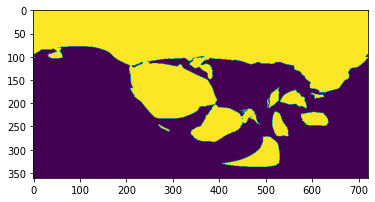

Working on Time 355.00Ma

Selected Time is in the stage 348.00Ma to 368.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_348Ma/m_fig22_359_338_PresentDay_Paleogeog_Matthews2016_348.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_368Ma/m_fig20_380_359_PresentDay_Paleogeog_Matthews2016_368.00Ma.shp']


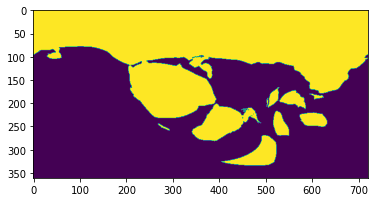

Working on Time 356.00Ma

Selected Time is in the stage 348.00Ma to 368.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_348Ma/m_fig22_359_338_PresentDay_Paleogeog_Matthews2016_348.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_368Ma/m_fig20_380_359_PresentDay_Paleogeog_Matthews2016_368.00Ma.shp']


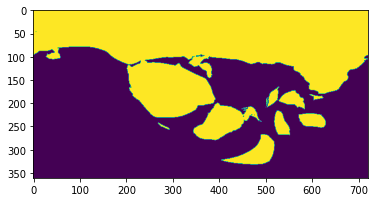

Working on Time 357.00Ma

Selected Time is in the stage 348.00Ma to 368.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_348Ma/m_fig22_359_338_PresentDay_Paleogeog_Matthews2016_348.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_368Ma/m_fig20_380_359_PresentDay_Paleogeog_Matthews2016_368.00Ma.shp']


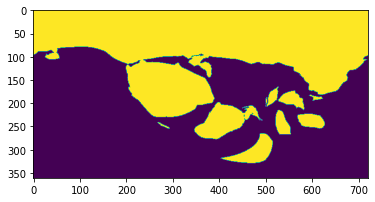

Working on Time 358.00Ma

Selected Time is in the stage 348.00Ma to 368.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_348Ma/m_fig22_359_338_PresentDay_Paleogeog_Matthews2016_348.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_368Ma/m_fig20_380_359_PresentDay_Paleogeog_Matthews2016_368.00Ma.shp']


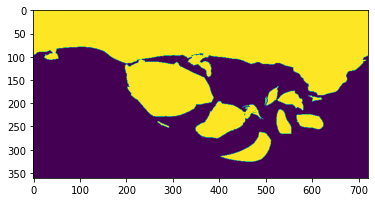

Working on Time 359.00Ma

Selected Time is in the stage 348.00Ma to 368.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_348Ma/m_fig22_359_338_PresentDay_Paleogeog_Matthews2016_348.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_368Ma/m_fig20_380_359_PresentDay_Paleogeog_Matthews2016_368.00Ma.shp']


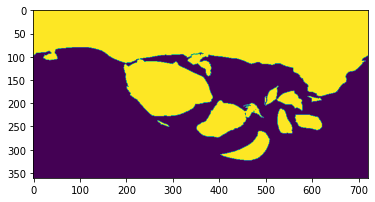

Working on Time 360.00Ma

Selected Time is in the stage 348.00Ma to 368.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_348Ma/m_fig22_359_338_PresentDay_Paleogeog_Matthews2016_348.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_368Ma/m_fig20_380_359_PresentDay_Paleogeog_Matthews2016_368.00Ma.shp']


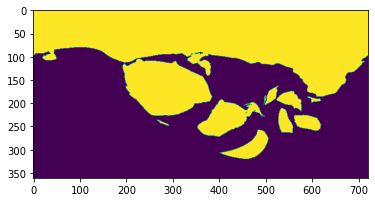

Working on Time 361.00Ma

Selected Time is in the stage 348.00Ma to 368.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_348Ma/m_fig22_359_338_PresentDay_Paleogeog_Matthews2016_348.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_368Ma/m_fig20_380_359_PresentDay_Paleogeog_Matthews2016_368.00Ma.shp']


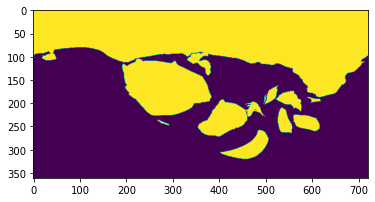

Working on Time 362.00Ma

Selected Time is in the stage 348.00Ma to 368.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_348Ma/m_fig22_359_338_PresentDay_Paleogeog_Matthews2016_348.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_368Ma/m_fig20_380_359_PresentDay_Paleogeog_Matthews2016_368.00Ma.shp']


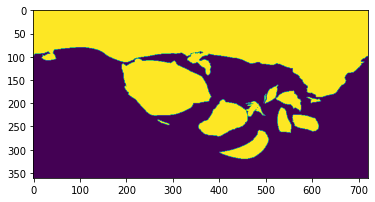

Working on Time 363.00Ma

Selected Time is in the stage 348.00Ma to 368.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_348Ma/m_fig22_359_338_PresentDay_Paleogeog_Matthews2016_348.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_368Ma/m_fig20_380_359_PresentDay_Paleogeog_Matthews2016_368.00Ma.shp']


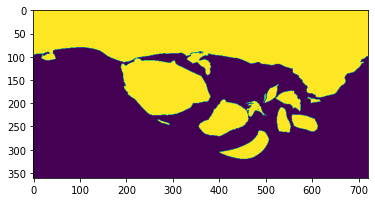

Working on Time 364.00Ma

Selected Time is in the stage 348.00Ma to 368.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_348Ma/m_fig22_359_338_PresentDay_Paleogeog_Matthews2016_348.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_368Ma/m_fig20_380_359_PresentDay_Paleogeog_Matthews2016_368.00Ma.shp']


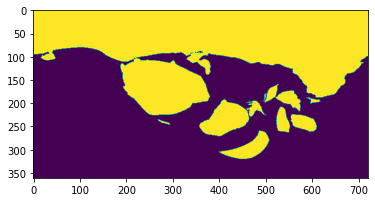

Working on Time 365.00Ma

Selected Time is in the stage 348.00Ma to 368.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_348Ma/m_fig22_359_338_PresentDay_Paleogeog_Matthews2016_348.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_368Ma/m_fig20_380_359_PresentDay_Paleogeog_Matthews2016_368.00Ma.shp']


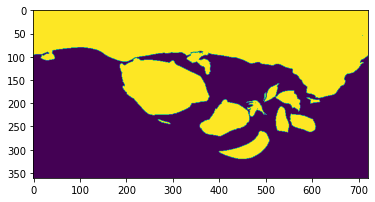

Working on Time 366.00Ma

Selected Time is in the stage 348.00Ma to 368.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_348Ma/m_fig22_359_338_PresentDay_Paleogeog_Matthews2016_348.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_368Ma/m_fig20_380_359_PresentDay_Paleogeog_Matthews2016_368.00Ma.shp']


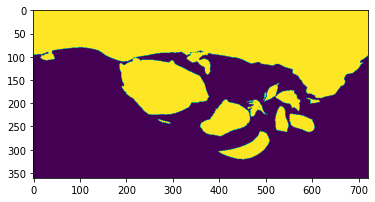

Working on Time 367.00Ma

Selected Time is in the stage 348.00Ma to 368.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_348Ma/m_fig22_359_338_PresentDay_Paleogeog_Matthews2016_348.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_368Ma/m_fig20_380_359_PresentDay_Paleogeog_Matthews2016_368.00Ma.shp']


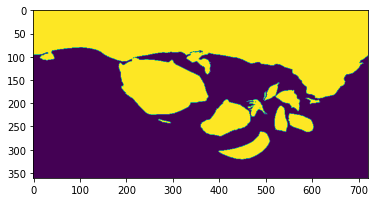

Working on Time 368.00Ma

Selected Time is in the stage 368.00Ma to 396.00Ma
Temporary fix for valid time
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_368Ma/m_fig20_380_359_PresentDay_Paleogeog_Matthews2016_368.00Ma.shp']


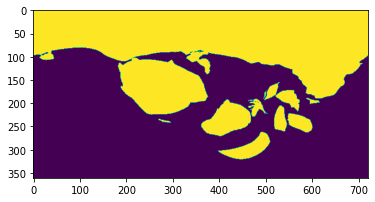

Working on Time 369.00Ma

Selected Time is in the stage 368.00Ma to 396.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_368Ma/m_fig20_380_359_PresentDay_Paleogeog_Matthews2016_368.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_396Ma/m_fig18_402_380_PresentDay_Paleogeog_Matthews2016_396.00Ma.shp']


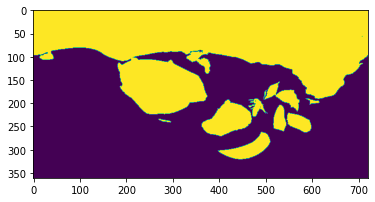

Working on Time 370.00Ma

Selected Time is in the stage 368.00Ma to 396.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_368Ma/m_fig20_380_359_PresentDay_Paleogeog_Matthews2016_368.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_396Ma/m_fig18_402_380_PresentDay_Paleogeog_Matthews2016_396.00Ma.shp']


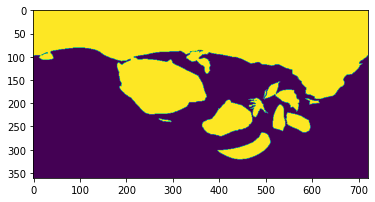

Working on Time 371.00Ma

Selected Time is in the stage 368.00Ma to 396.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_368Ma/m_fig20_380_359_PresentDay_Paleogeog_Matthews2016_368.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_396Ma/m_fig18_402_380_PresentDay_Paleogeog_Matthews2016_396.00Ma.shp']


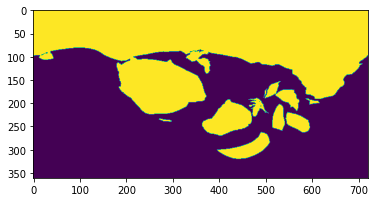

Working on Time 372.00Ma

Selected Time is in the stage 368.00Ma to 396.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_368Ma/m_fig20_380_359_PresentDay_Paleogeog_Matthews2016_368.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_396Ma/m_fig18_402_380_PresentDay_Paleogeog_Matthews2016_396.00Ma.shp']


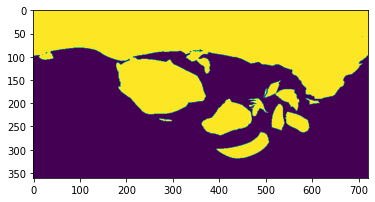

Working on Time 373.00Ma

Selected Time is in the stage 368.00Ma to 396.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_368Ma/m_fig20_380_359_PresentDay_Paleogeog_Matthews2016_368.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_396Ma/m_fig18_402_380_PresentDay_Paleogeog_Matthews2016_396.00Ma.shp']


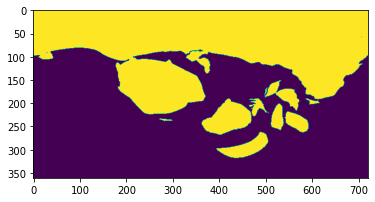

Working on Time 374.00Ma

Selected Time is in the stage 368.00Ma to 396.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_368Ma/m_fig20_380_359_PresentDay_Paleogeog_Matthews2016_368.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_396Ma/m_fig18_402_380_PresentDay_Paleogeog_Matthews2016_396.00Ma.shp']


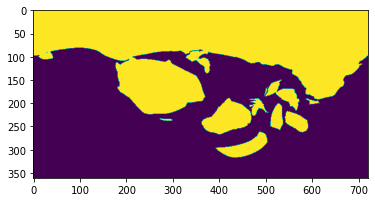

Working on Time 375.00Ma

Selected Time is in the stage 368.00Ma to 396.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_368Ma/m_fig20_380_359_PresentDay_Paleogeog_Matthews2016_368.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_396Ma/m_fig18_402_380_PresentDay_Paleogeog_Matthews2016_396.00Ma.shp']


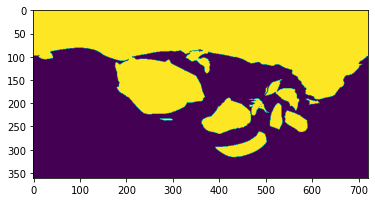

Working on Time 376.00Ma

Selected Time is in the stage 368.00Ma to 396.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_368Ma/m_fig20_380_359_PresentDay_Paleogeog_Matthews2016_368.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_396Ma/m_fig18_402_380_PresentDay_Paleogeog_Matthews2016_396.00Ma.shp']


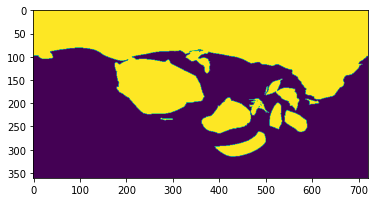

Working on Time 377.00Ma

Selected Time is in the stage 368.00Ma to 396.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_368Ma/m_fig20_380_359_PresentDay_Paleogeog_Matthews2016_368.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_396Ma/m_fig18_402_380_PresentDay_Paleogeog_Matthews2016_396.00Ma.shp']


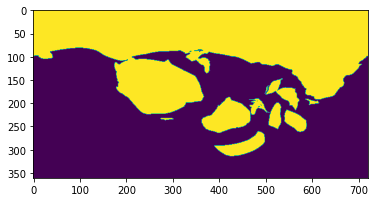

Working on Time 378.00Ma

Selected Time is in the stage 368.00Ma to 396.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_368Ma/m_fig20_380_359_PresentDay_Paleogeog_Matthews2016_368.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_396Ma/m_fig18_402_380_PresentDay_Paleogeog_Matthews2016_396.00Ma.shp']


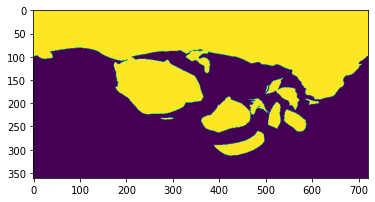

Working on Time 379.00Ma

Selected Time is in the stage 368.00Ma to 396.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_368Ma/m_fig20_380_359_PresentDay_Paleogeog_Matthews2016_368.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_396Ma/m_fig18_402_380_PresentDay_Paleogeog_Matthews2016_396.00Ma.shp']


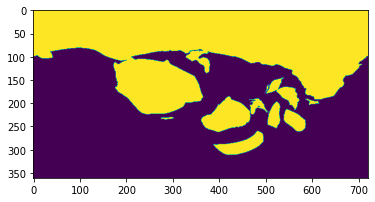

Working on Time 380.00Ma

Selected Time is in the stage 368.00Ma to 396.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_368Ma/m_fig20_380_359_PresentDay_Paleogeog_Matthews2016_368.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_396Ma/m_fig18_402_380_PresentDay_Paleogeog_Matthews2016_396.00Ma.shp']


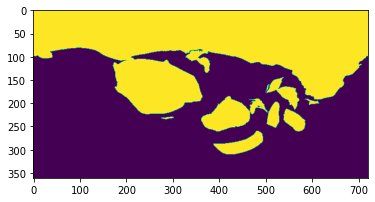

Working on Time 381.00Ma

Selected Time is in the stage 368.00Ma to 396.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_368Ma/m_fig20_380_359_PresentDay_Paleogeog_Matthews2016_368.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_396Ma/m_fig18_402_380_PresentDay_Paleogeog_Matthews2016_396.00Ma.shp']


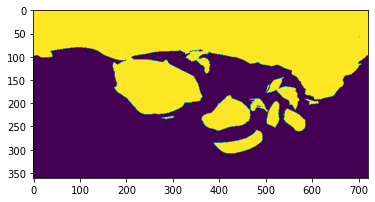

Working on Time 382.00Ma

Selected Time is in the stage 368.00Ma to 396.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_368Ma/m_fig20_380_359_PresentDay_Paleogeog_Matthews2016_368.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_396Ma/m_fig18_402_380_PresentDay_Paleogeog_Matthews2016_396.00Ma.shp']


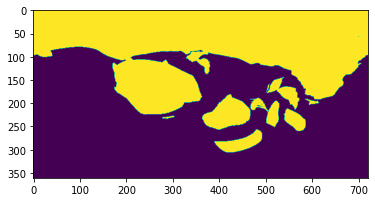

Working on Time 383.00Ma

Selected Time is in the stage 368.00Ma to 396.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_368Ma/m_fig20_380_359_PresentDay_Paleogeog_Matthews2016_368.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_396Ma/m_fig18_402_380_PresentDay_Paleogeog_Matthews2016_396.00Ma.shp']


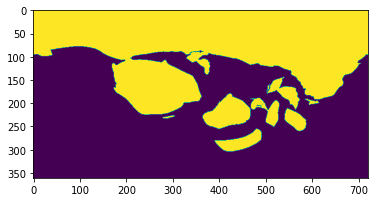

Working on Time 384.00Ma

Selected Time is in the stage 368.00Ma to 396.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_368Ma/m_fig20_380_359_PresentDay_Paleogeog_Matthews2016_368.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_396Ma/m_fig18_402_380_PresentDay_Paleogeog_Matthews2016_396.00Ma.shp']


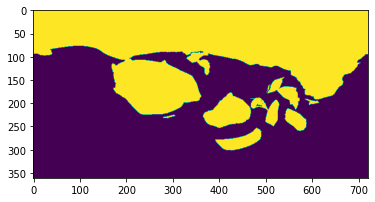

Working on Time 385.00Ma

Selected Time is in the stage 368.00Ma to 396.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_368Ma/m_fig20_380_359_PresentDay_Paleogeog_Matthews2016_368.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_396Ma/m_fig18_402_380_PresentDay_Paleogeog_Matthews2016_396.00Ma.shp']


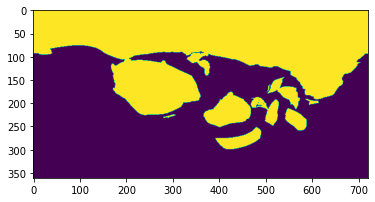

Working on Time 386.00Ma

Selected Time is in the stage 368.00Ma to 396.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_368Ma/m_fig20_380_359_PresentDay_Paleogeog_Matthews2016_368.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_396Ma/m_fig18_402_380_PresentDay_Paleogeog_Matthews2016_396.00Ma.shp']


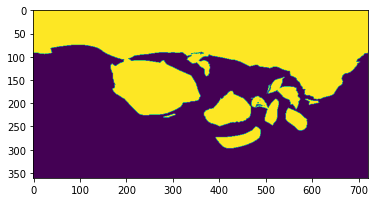

Working on Time 387.00Ma

Selected Time is in the stage 368.00Ma to 396.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_368Ma/m_fig20_380_359_PresentDay_Paleogeog_Matthews2016_368.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_396Ma/m_fig18_402_380_PresentDay_Paleogeog_Matthews2016_396.00Ma.shp']


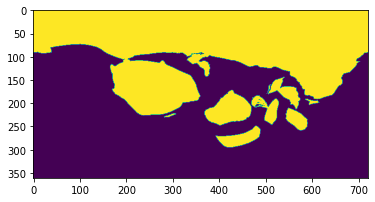

Working on Time 388.00Ma

Selected Time is in the stage 368.00Ma to 396.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_368Ma/m_fig20_380_359_PresentDay_Paleogeog_Matthews2016_368.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_396Ma/m_fig18_402_380_PresentDay_Paleogeog_Matthews2016_396.00Ma.shp']


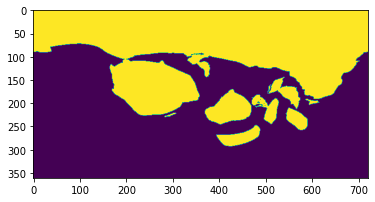

Working on Time 389.00Ma

Selected Time is in the stage 368.00Ma to 396.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_368Ma/m_fig20_380_359_PresentDay_Paleogeog_Matthews2016_368.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_396Ma/m_fig18_402_380_PresentDay_Paleogeog_Matthews2016_396.00Ma.shp']


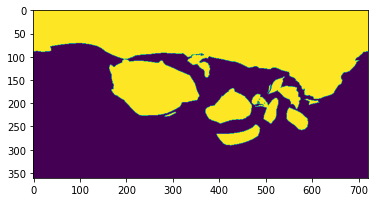

Working on Time 390.00Ma

Selected Time is in the stage 368.00Ma to 396.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_368Ma/m_fig20_380_359_PresentDay_Paleogeog_Matthews2016_368.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_396Ma/m_fig18_402_380_PresentDay_Paleogeog_Matthews2016_396.00Ma.shp']


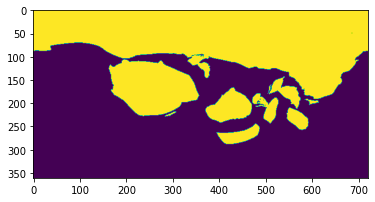

Working on Time 391.00Ma

Selected Time is in the stage 368.00Ma to 396.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_368Ma/m_fig20_380_359_PresentDay_Paleogeog_Matthews2016_368.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_396Ma/m_fig18_402_380_PresentDay_Paleogeog_Matthews2016_396.00Ma.shp']


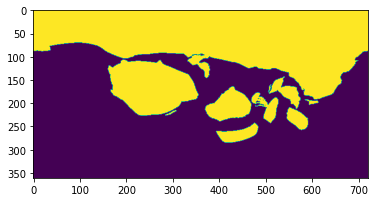

Working on Time 392.00Ma

Selected Time is in the stage 368.00Ma to 396.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_368Ma/m_fig20_380_359_PresentDay_Paleogeog_Matthews2016_368.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_396Ma/m_fig18_402_380_PresentDay_Paleogeog_Matthews2016_396.00Ma.shp']


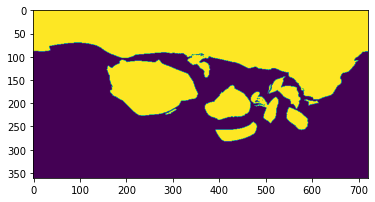

Working on Time 393.00Ma

Selected Time is in the stage 368.00Ma to 396.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_368Ma/m_fig20_380_359_PresentDay_Paleogeog_Matthews2016_368.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_396Ma/m_fig18_402_380_PresentDay_Paleogeog_Matthews2016_396.00Ma.shp']


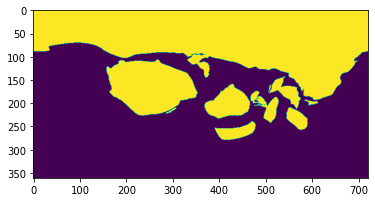

Working on Time 394.00Ma

Selected Time is in the stage 368.00Ma to 396.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_368Ma/m_fig20_380_359_PresentDay_Paleogeog_Matthews2016_368.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_396Ma/m_fig18_402_380_PresentDay_Paleogeog_Matthews2016_396.00Ma.shp']


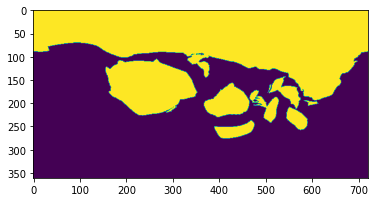

Working on Time 395.00Ma

Selected Time is in the stage 368.00Ma to 396.00Ma
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_368Ma/m_fig20_380_359_PresentDay_Paleogeog_Matthews2016_368.00Ma.shp']
['/Users/simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_396Ma/m_fig18_402_380_PresentDay_Paleogeog_Matthews2016_396.00Ma.shp']


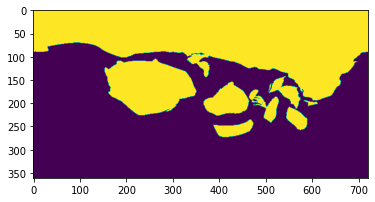

Working on Time 396.00Ma



IndexError: index 0 is out of bounds for axis 0 with size 0

In [24]:
from joblib import Parallel, delayed

# prepend 0 to the list, since this is not covered in published paleogeography sequence
paleogeography_timeslice_list = np.hstack((0,paleogeography_timeslice_list))
 
num_cpus = 1

#time_min = 260.
#time_max = 261.
#time_step = 5.

if num_cpus==1:
    
    for reconstruction_time in np.arange(time_min,time_max+time_step,time_step):

        pt.paleotopography_job(reconstruction_time, paleogeography_timeslice_list, 
                               tween_basedir, reconstruction_basedir, output_dir, 
                               file_format, rotation_file, COBterrane_file, agegrid_file_template,
                               lowland_elevation, shallow_marine_elevation, max_mountain_elevation, depth_for_unknown_ocean, 
                               sampling, mountain_buffer_distance_degrees, area_threshold,
                               grid_smoothing_wavelength_kms, merge_with_bathymetry, land_or_ocean_precedence,
                               netcdf3_output)

else:
    Parallel(n_jobs=num_cpus)(delayed(pt.paleotopography_job) \
                              (reconstruction_time, paleogeography_timeslice_list, 
                               tween_basedir, reconstruction_basedir, output_dir, 
                               file_format, rotation_file, COBterrane_file, agegrid_file_template,
                               lowland_elevation, shallow_marine_elevation, max_mountain_elevation, depth_for_unknown_ocean, 
                               sampling, mountain_buffer_distance_degrees, area_threshold,
                               grid_smoothing_wavelength_kms, merge_with_bathymetry, land_or_ocean_precedence,
                               netcdf3_output)
                              for reconstruction_time in np.arange(time_min,time_max+time_step,time_step))
                              
                              

In [43]:
GW = pygplates.FeatureCollection('GatewayMasks.gpml')

for feature in GW:
    tmp = feature.get(pygplates.PropertyName.create_gpml('subcategory'))  #value('gpml:subcategory')
    print tmp


gpml:subcategory [ gateway ]


In [28]:
print(paleogeography_timeslice_list)
np.where(paleogeography_timeslice_list>reconstruction_time)

[  0.   6.  14.  22.  33.  45.  53.  76.  90. 105. 126. 140. 152. 169.
 195. 218. 232. 255. 277. 287. 302. 328. 348. 368. 396.]


(array([], dtype=int64),)